In [1]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 3070


In [2]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.2, random_state=39)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [01:59, 74.55it/s]


In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [69]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(24192, 128)
        # originally tried relu layers, but wanted something non-linear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,2)
        self.fc3 = nn.Linear(128, 1)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 2)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
        self.mult = torch.tensor([512,384])
        self.mult = self.mult.to(device)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        # out_x = self.conv_layer3(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool3(out_x)
        # out_x = self.conv_layer4(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool4(out_x)

        out_x = out_x.reshape(out_x.size(0), -1)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        out_x = out_x * self.mult
        # out_x = self.fc3(out_x)
        # out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [88]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 80
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001
learning_rate = 0.0000001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 750

In [89]:
dataset = ImageDataset(X_train, y_train)
test = ImageDataset(X_test, y_test)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)


# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model = ConvNeuralNet(2)
model.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# # it lets me train in chunks over time.
checkpoint = torch.load('model_duo.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_start = checkpoint['epoch']
loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model.train()

losses = []
losses_val = []


C:\Users\Yile0\AppData\Local\Temp\ipykernel_58624\1901619840.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model_duo.pth')


In [90]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in tqdm(range(epoch_start, epoch_start + num_epochs)):
        start = time.time()
        model.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            output = model(images)
            # process into the separate multipliers. 
            
            loss = criterion(output, labels)
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss.backward()
            optimizer.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")
        model.eval()
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            output = model(images)
            # process into the separate multipliers. 
            loss_valid = criterion(output, labels)
            
        print('val')
        print(labels)
        print(output)

        # step lr scheduler
        # add so I can graph later
        losses.append(loss.item())
        losses_val.append(loss_valid.item())
        print('validate Loss_X: {:.10f}'.format(loss_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Time: {:.10f}'.format(epoch + 1, num_epochs + epoch_start, loss.item(), end-start))

    # torch.save({
    #                 'epoch': num_epochs,
    #                 'model_x_state_dict': model_x.state_dict(),
    #                 'optimizer_x_state_dict': optimizer_x.state_dict(),
    #                 'model_y_state_dict': model_y.state_dict(),
    #                 'optimizer_y_state_dict': optimizer_y.state_dict(),
    #                 'loss': criterion,
    #             }, "model.pth")
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, "model_duo.pth")


if __name__ == '__main__':
    main()

  0%|          | 1/750 [00:02<26:52,  2.15s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.6507, 165.0964],
        [262.8319, 157.2151],
        [297.0245, 209.3325],
        [229.8374, 157.1217],
        [253.1635, 189.9515],
        [239.6158, 153.3317],
        [273.2911,

  0%|          | 2/750 [00:03<23:04,  1.85s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.6990, 165.0873],
        [262.9062, 157.2166],
        [297.0570, 209.3290],
        [229.8549, 157.1218],
        [253.1926, 189.9620],
        [239.6480, 153.3216],
        [273.3271,

  0%|          | 3/750 [00:05<21:50,  1.75s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.7562, 165.0718],
        [263.0053, 157.2213],
        [297.0841, 209.3259],
        [229.8562, 157.1239],
        [253.2163, 189.9813],
        [239.6678, 153.3045],
        [273.3562,

  1%|          | 4/750 [00:07<21:27,  1.73s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.8220, 165.0499],
        [263.1286, 157.2288],
        [297.1043, 209.3233],
        [229.8389, 157.1286],
        [253.2316, 190.0107],
        [239.6720, 153.2811],
        [273.3765,

  1%|          | 5/750 [00:08<21:01,  1.69s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.8929, 165.0203],
        [263.2738, 157.2399],
        [297.1106, 209.3211],
        [229.8000, 157.1359],
        [253.2366, 190.0488],
        [239.6574, 153.2505],
        [273.3821,

  1%|          | 6/750 [00:10<20:45,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.9636, 164.9827],
        [263.4326, 157.2549],
        [297.0984, 209.3199],
        [229.7312, 157.1467],
        [253.2220, 190.0981],
        [239.6154, 153.2130],
        [273.3683,

  1%|          | 7/750 [00:12<20:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.0390, 164.9361],
        [263.6129, 157.2736],
        [297.0711, 209.3185],
        [229.6335, 157.1590],
        [253.1917, 190.1588],
        [239.5490, 153.1656],
        [273.3370,

  1%|          | 8/750 [00:13<20:27,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.1071, 164.8820],
        [263.8047, 157.2953],
        [297.0178, 209.3183],
        [229.5022, 157.1765],
        [253.1385, 190.2305],
        [239.4481, 153.1122],
        [273.2765,

  1%|          | 9/750 [00:15<20:21,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.1809, 164.8196],
        [264.0176, 157.3217],
        [296.9482, 209.3193],
        [229.3449, 157.1970],
        [253.0726, 190.3136],
        [239.3246, 153.0488],
        [273.2027,

  1%|▏         | 10/750 [00:16<20:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.2515, 164.7485],
        [264.2388, 157.3520],
        [296.8544, 209.3211],
        [229.1576, 157.2221],
        [252.9850, 190.4085],
        [239.1706, 152.9789],
        [273.1037,

  1%|▏         | 11/750 [00:18<20:22,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.3185, 164.6684],
        [264.4726, 157.3862],
        [296.7350, 209.3249],
        [228.9386, 157.2507],
        [252.8751, 190.5134],
        [238.9881, 152.9000],
        [272.9811,

  2%|▏         | 12/750 [00:20<20:17,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.3917, 164.5803],
        [264.7286, 157.4246],
        [296.6031, 209.3297],
        [228.6992, 157.2827],
        [252.7518, 190.6293],
        [238.7868, 152.8138],
        [272.8465,

  2%|▏         | 13/750 [00:21<20:13,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.4642, 164.4827],
        [264.9993, 157.4671],
        [296.4540, 209.3346],
        [228.4374, 157.3187],
        [252.6157, 190.7541],
        [238.5607, 152.7194],
        [272.6968,

  2%|▏         | 14/750 [00:23<20:10,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.5336, 164.3773],
        [265.2837, 157.5116],
        [296.2821, 209.3402],
        [228.1518, 157.3577],
        [252.4581, 190.8879],
        [238.3158, 152.6187],
        [272.5276,

  2%|▏         | 15/750 [00:25<20:07,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.6122, 164.2633],
        [265.5957, 157.5598],
        [296.1023, 209.3475],
        [227.8556, 157.4006],
        [252.2970, 191.0309],
        [238.0638, 152.5109],
        [272.3580,

  2%|▏         | 16/750 [00:26<20:14,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.6961, 164.1411],
        [265.9235, 157.6103],
        [295.9100, 209.3539],
        [227.5472, 157.4455],
        [252.1232, 191.1812],
        [237.7999, 152.3968],
        [272.1774,

  2%|▏         | 17/750 [00:28<20:09,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.7919, 164.0109],
        [266.2852, 157.6622],
        [295.7155, 209.3593],
        [227.2358, 157.4921],
        [251.9523, 191.3367],
        [237.5401, 152.2734],
        [272.0036,

  2%|▏         | 18/750 [00:30<20:06,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.8989, 163.8735],
        [266.6670, 157.7151],
        [295.5209, 209.3676],
        [226.9188, 157.5400],
        [251.7788, 191.5012],
        [237.2812, 152.1437],
        [271.8332,

  3%|▎         | 19/750 [00:31<20:03,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.0303, 163.7282],
        [267.0934, 157.7700],
        [295.3337, 209.3731],
        [226.6118, 157.5906],
        [251.6183, 191.6696],
        [237.0367, 152.0092],
        [271.6863,

  3%|▎         | 20/750 [00:33<20:00,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.1611, 163.5778],
        [267.5299, 157.8280],
        [295.1309, 209.3783],
        [226.2986, 157.6447],
        [251.4496, 191.8426],
        [236.7919, 151.8704],
        [271.5294,

  3%|▎         | 21/750 [00:35<19:57,  1.64s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.3136, 163.4212],
        [268.0013, 157.8872],
        [294.9395, 209.3841],
        [225.9989, 157.6988],
        [251.2938, 192.0215],
        [236.5643, 151.7265],
        [271.3914,

  3%|▎         | 22/750 [00:36<20:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.4829, 163.2591],
        [268.5044, 157.9468],
        [294.7524, 209.3882],
        [225.7079, 157.7567],
        [251.1454, 192.2012],
        [236.3545, 151.5762],
        [271.2689,

  3%|▎         | 23/750 [00:38<20:00,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.6583, 163.0923],
        [269.0214, 158.0089],
        [294.5590, 209.3940],
        [225.4174, 157.8151],
        [250.9992, 192.3849],
        [236.1556, 151.4270],
        [271.1486,

  3%|▎         | 24/750 [00:40<19:56,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.8489, 162.9227],
        [269.5591, 158.0737],
        [294.3617, 209.3979],
        [225.1411, 157.8756],
        [250.8576, 192.5693],
        [235.9682, 151.2748],
        [271.0406,

  3%|▎         | 25/750 [00:41<19:54,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.0511, 162.7505],
        [270.1146, 158.1403],
        [294.1646, 209.4029],
        [224.8748, 157.9395],
        [250.7224, 192.7584],
        [235.8008, 151.1223],
        [270.9441,

  3%|▎         | 26/750 [00:43<19:51,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.2481, 162.5775],
        [270.6710, 158.2107],
        [293.9463, 209.4101],
        [224.6050, 158.0055],
        [250.5816, 192.9506],
        [235.6375, 150.9720],
        [270.8376,

  4%|▎         | 27/750 [00:44<19:49,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.4521, 162.4018],
        [271.2363, 158.2841],
        [293.7201, 209.4186],
        [224.3445, 158.0748],
        [250.4444, 193.1414],
        [235.4897, 150.8221],
        [270.7353,

  4%|▎         | 28/750 [00:46<19:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.6553, 162.2282],
        [271.7994, 158.3591],
        [293.4775, 209.4302],
        [224.0852, 158.1465],
        [250.2993, 193.3337],
        [235.3475, 150.6772],
        [270.6273,

  4%|▍         | 29/750 [00:48<19:52,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.8481, 162.0568],
        [272.3441, 158.4387],
        [293.2030, 209.4443],
        [223.8199, 158.2222],
        [250.1446, 193.5288],
        [235.2051, 150.5366],
        [270.5012,

  4%|▍         | 30/750 [00:49<19:48,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.0412, 161.8868],
        [272.8835, 158.5213],
        [292.9113, 209.4597],
        [223.5606, 158.2997],
        [249.9857, 193.7214],
        [235.0726, 150.4016],
        [270.3702,

  4%|▍         | 31/750 [00:51<19:45,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.2272, 161.7206],
        [273.4111, 158.6076],
        [292.5960, 209.4803],
        [223.2986, 158.3801],
        [249.8176, 193.9152],
        [234.9478, 150.2703],
        [270.2309,

  4%|▍         | 32/750 [00:53<19:42,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.4024, 161.5578],
        [273.9137, 158.6992],
        [292.2481, 209.5022],
        [223.0390, 158.4660],
        [249.6429, 194.1063],
        [234.8206, 150.1501],
        [270.0692,

  4%|▍         | 33/750 [00:54<19:40,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.5754, 161.3995],
        [274.4081, 158.7926],
        [291.8851, 209.5312],
        [222.7874, 158.5514],
        [249.4674, 194.2977],
        [234.7163, 150.0345],
        [269.9079,

  5%|▍         | 34/750 [00:56<19:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.7399, 161.2459],
        [274.8864, 158.8925],
        [291.4987, 209.5619],
        [222.5399, 158.6395],
        [249.2885, 194.4829],
        [234.6175, 149.9320],
        [269.7317,

  5%|▍         | 35/750 [00:58<19:42,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.8999, 161.0975],
        [275.3400, 158.9940],
        [291.0878, 209.5964],
        [222.3033, 158.7296],
        [249.1099, 194.6632],
        [234.5307, 149.8339],
        [269.5479,

  5%|▍         | 36/750 [00:59<19:39,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.0610, 160.9542],
        [275.7802, 159.1023],
        [290.6633, 209.6321],
        [222.0799, 158.8218],
        [248.9401, 194.8421],
        [234.4633, 149.7461],
        [269.3636,

  5%|▍         | 37/750 [01:01<19:36,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.2355, 160.8172],
        [276.2341, 159.2121],
        [290.2436, 209.6743],
        [221.8830, 158.9132],
        [248.7891, 195.0116],
        [234.4399, 149.6651],
        [269.1932,

  5%|▌         | 38/750 [01:03<19:34,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.4063, 160.6858],
        [276.6645, 159.3255],
        [289.8021, 209.7155],
        [221.7035, 159.0048],
        [248.6470, 195.1736],
        [234.4295, 149.5938],
        [269.0199,

  5%|▌         | 39/750 [01:04<19:33,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.5865, 160.5594],
        [277.0901, 159.4410],
        [289.3647, 209.7593],
        [221.5496, 159.0969],
        [248.5297, 195.3276],
        [234.4515, 149.5295],
        [268.8597,

  5%|▌         | 40/750 [01:06<19:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.7824, 160.4405],
        [277.5253, 159.5601],
        [288.9327, 209.8038],
        [221.4331, 159.1865],
        [248.4405, 195.4738],
        [234.5171, 149.4737],
        [268.7194,

  5%|▌         | 41/750 [01:08<19:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.9790, 160.3277],
        [277.9419, 159.6808],
        [288.4870, 209.8512],
        [221.3288, 159.2763],
        [248.3584, 195.6127],
        [234.6033, 149.4247],
        [268.5788,

  6%|▌         | 42/750 [01:09<19:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.1840, 160.2207],
        [278.3551, 159.8039],
        [288.0462, 209.8993],
        [221.2612, 159.3618],
        [248.3119, 195.7370],
        [234.7253, 149.3852],
        [268.4568,

  6%|▌         | 43/750 [01:11<19:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.4035, 160.1218],
        [278.7690, 159.9309],
        [287.6126, 209.9503],
        [221.2220, 159.4482],
        [248.2922, 195.8552],
        [234.8821, 149.3540],
        [268.3499,

  6%|▌         | 44/750 [01:13<19:26,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.6175, 160.0294],
        [279.1601, 160.0602],
        [287.1655, 210.0021],
        [221.2006, 159.5311],
        [248.2813, 195.9615],
        [235.0585, 149.3322],
        [268.2390,

  6%|▌         | 45/750 [01:14<19:23,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.8372, 159.9433],
        [279.5446, 160.1908],
        [286.7198, 210.0565],
        [221.2012, 159.6114],
        [248.2940, 196.0588],
        [235.2546, 149.3168],
        [268.1397,

  6%|▌         | 46/750 [01:16<19:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.0525, 159.8673],
        [279.9052, 160.3276],
        [286.2636, 210.1127],
        [221.2212, 159.6914],
        [248.3228, 196.1445],
        [235.4679, 149.3102],
        [268.0346,

  6%|▋         | 47/750 [01:18<19:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.2627, 159.7964],
        [280.2434, 160.4651],
        [285.7940, 210.1716],
        [221.2523, 159.7690],
        [248.3641, 196.2226],
        [235.6871, 149.3145],
        [267.9255,

  6%|▋         | 48/750 [01:19<19:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.4650, 159.7343],
        [280.5540, 160.6081],
        [285.3144, 210.2337],
        [221.2969, 159.8456],
        [248.4148, 196.2913],
        [235.9196, 149.3273],
        [267.8115,

  7%|▋         | 49/750 [01:21<19:19,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.6554, 159.6817],
        [280.8423, 160.7552],
        [284.8170, 210.3022],
        [221.3478, 159.9221],
        [248.4724, 196.3515],
        [236.1554, 149.3479],
        [267.6882,

  7%|▋         | 50/750 [01:23<19:16,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.8376, 159.6357],
        [281.0934, 160.9061],
        [284.3087, 210.3680],
        [221.4147, 159.9947],
        [248.5451, 196.4028],
        [236.3950, 149.3784],
        [267.5567,

  7%|▋         | 51/750 [01:24<19:14,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.0050, 159.5964],
        [281.3205, 161.0623],
        [283.7858, 210.4417],
        [221.4854, 160.0677],
        [248.6197, 196.4478],
        [236.6351, 149.4170],
        [267.4112,

  7%|▋         | 52/750 [01:26<19:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.1703, 159.5642],
        [281.5273, 161.2185],
        [283.2581, 210.5166],
        [221.5668, 160.1372],
        [248.7077, 196.4849],
        [236.8795, 149.4628],
        [267.2675,

  7%|▋         | 53/750 [01:28<19:16,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.3174, 159.5397],
        [281.7052, 161.3817],
        [282.7167, 210.5925],
        [221.6575, 160.2056],
        [248.8021, 196.5150],
        [237.1207, 149.5164],
        [267.1126,

  7%|▋         | 54/750 [01:29<19:12,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.4642, 159.5203],
        [281.8671, 161.5463],
        [282.1703, 210.6699],
        [221.7603, 160.2728],
        [248.9110, 196.5374],
        [237.3735, 149.5754],
        [266.9604,

  7%|▋         | 55/750 [01:31<19:09,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.6086, 159.5067],
        [282.0200, 161.7135],
        [281.6309, 210.7491],
        [221.8835, 160.3350],
        [249.0424, 196.5525],
        [237.6392, 149.6386],
        [266.8136,

  7%|▋         | 56/750 [01:32<19:07,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.7556, 159.4974],
        [282.1618, 161.8812],
        [281.0976, 210.8280],
        [222.0220, 160.3952],
        [249.1922, 196.5630],
        [237.9161, 149.7073],
        [266.6746,

  8%|▊         | 57/750 [01:34<19:04,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.8904, 159.4926],
        [282.2832, 162.0515],
        [280.5600, 210.9059],
        [222.1693, 160.4537],
        [249.3470, 196.5662],
        [238.1956, 149.7805],
        [266.5340,

  8%|▊         | 58/750 [01:36<19:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.0423, 159.4921],
        [282.4158, 162.2225],
        [280.0493, 210.9833],
        [222.3514, 160.5057],
        [249.5375, 196.5637],
        [238.4987, 149.8537],
        [266.4188,

  8%|▊         | 59/750 [01:37<19:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.1835, 159.4956],
        [282.5310, 162.3949],
        [279.5352, 211.0610],
        [222.5383, 160.5560],
        [249.7404, 196.5555],
        [238.8056, 149.9323],
        [266.3048,

  8%|▊         | 60/750 [01:39<19:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.3283, 159.5009],
        [282.6494, 162.5649],
        [279.0340, 211.1365],
        [222.7426, 160.6014],
        [249.9596, 196.5451],
        [239.1257, 150.0099],
        [266.2031,

  8%|▊         | 61/750 [01:41<18:59,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.4776, 159.5096],
        [282.7607, 162.7374],
        [278.5443, 211.2109],
        [222.9669, 160.6425],
        [250.2012, 196.5284],
        [239.4565, 150.0893],
        [266.1097,

  8%|▊         | 62/750 [01:42<18:56,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.6160, 159.5207],
        [282.8578, 162.9090],
        [278.0543, 211.2861],
        [223.1931, 160.6825],
        [250.4484, 196.5108],
        [239.7827, 150.1711],
        [266.0209,

  8%|▊         | 63/750 [01:44<18:54,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.7573, 159.5342],
        [282.9594, 163.0824],
        [277.5767, 211.3599],
        [223.4341, 160.7187],
        [250.7119, 196.4920],
        [240.1147, 150.2529],
        [265.9341,

  9%|▊         | 64/750 [01:46<19:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.8968, 159.5483],
        [283.0442, 163.2521],
        [277.0990, 211.4290],
        [223.6800, 160.7496],
        [250.9759, 196.4731],
        [240.4500, 150.3344],
        [265.8557,

  9%|▊         | 65/750 [01:47<18:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.0210, 159.5640],
        [283.1209, 163.4257],
        [276.6220, 211.5017],
        [223.9276, 160.7811],
        [251.2511, 196.4526],
        [240.7790, 150.4192],
        [265.7731,

  9%|▉         | 66/750 [01:49<18:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.1418, 159.5825],
        [283.1846, 163.5978],
        [276.1429, 211.5719],
        [224.1762, 160.8078],
        [251.5230, 196.4315],
        [241.1034, 150.4992],
        [265.6851,

  9%|▉         | 67/750 [01:51<18:49,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.2496, 159.6005],
        [283.2329, 163.7666],
        [275.6604, 211.6402],
        [224.4226, 160.8324],
        [251.7929, 196.4147],
        [241.4174, 150.5806],
        [265.5921,

  9%|▉         | 68/750 [01:52<18:47,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.3487, 159.6211],
        [283.2790, 163.9385],
        [275.1789, 211.7122],
        [224.6675, 160.8551],
        [252.0604, 196.3998],
        [241.7247, 150.6625],
        [265.4998,

  9%|▉         | 69/750 [01:54<18:44,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.4438, 159.6376],
        [283.3192, 164.1080],
        [274.7010, 211.7785],
        [224.9146, 160.8750],
        [252.3338, 196.3859],
        [242.0306, 150.7417],
        [265.4071,

  9%|▉         | 70/750 [01:56<18:51,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.5309, 159.6568],
        [283.3415, 164.2760],
        [274.2191, 211.8469],
        [225.1560, 160.8935],
        [252.5999, 196.3764],
        [242.3229, 150.8187],
        [265.3039,

  9%|▉         | 71/750 [01:57<18:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.6107, 159.6748],
        [283.3681, 164.4421],
        [273.7416, 211.9126],
        [225.3974, 160.9055],
        [252.8700, 196.3724],
        [242.6113, 150.8944],
        [265.2077,

 10%|▉         | 72/750 [01:59<18:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.6944, 159.6890],
        [283.3977, 164.6061],
        [273.2794, 211.9747],
        [225.6465, 160.9178],
        [253.1449, 196.3652],
        [242.9021, 150.9630],
        [265.1187,

 10%|▉         | 73/750 [02:01<18:39,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.7643, 159.7039],
        [283.4163, 164.7686],
        [272.8050, 212.0377],
        [225.8889, 160.9285],
        [253.4139, 196.3671],
        [243.1833, 151.0315],
        [265.0225,

 10%|▉         | 74/750 [02:02<18:37,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.8443, 159.7157],
        [283.4520, 164.9297],
        [272.3581, 212.0980],
        [226.1404, 160.9328],
        [253.6879, 196.3740],
        [243.4702, 151.0934],
        [264.9427,

 10%|█         | 75/750 [02:04<18:34,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.9217, 159.7241],
        [283.4901, 165.0863],
        [271.9160, 212.1541],
        [226.3909, 160.9354],
        [253.9707, 196.3792],
        [243.7550, 151.1508],
        [264.8653,

 10%|█         | 76/750 [02:06<18:41,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.9957, 159.7313],
        [283.5243, 165.2425],
        [271.4739, 212.2120],
        [226.6410, 160.9350],
        [254.2451, 196.3937],
        [244.0355, 151.2056],
        [264.7871,

 10%|█         | 77/750 [02:07<18:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.0791, 159.7350],
        [283.5771, 165.3958],
        [271.0507, 212.2654],
        [226.8983, 160.9332],
        [254.5289, 196.4114],
        [244.3209, 151.2520],
        [264.7296,

 10%|█         | 78/750 [02:09<18:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.1543, 159.7365],
        [283.6301, 165.5449],
        [270.6317, 212.3157],
        [227.1501, 160.9278],
        [254.8098, 196.4344],
        [244.5991, 151.2953],
        [264.6659,

 11%|█         | 79/750 [02:11<18:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.2354, 159.7351],
        [283.6916, 165.6932],
        [270.2221, 212.3677],
        [227.4031, 160.9189],
        [255.0948, 196.4619],
        [244.8786, 151.3334],
        [264.6143,

 11%|█         | 80/750 [02:12<18:27,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.3119, 159.7312],
        [283.7526, 165.8394],
        [269.8140, 212.4166],
        [227.6512, 160.9111],
        [255.3659, 196.4958],
        [245.1477, 151.3690],
        [264.5591,

 11%|█         | 81/750 [02:14<18:24,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.3905, 159.7246],
        [283.8232, 165.9813],
        [269.4189, 212.4631],
        [227.8996, 160.8986],
        [255.6470, 196.5321],
        [245.4225, 151.3981],
        [264.5133,

 11%|█         | 82/750 [02:16<18:32,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.4556, 159.7150],
        [283.8901, 166.1231],
        [269.0192, 212.5110],
        [228.1381, 160.8858],
        [255.9091, 196.5762],
        [245.6732, 151.4229],
        [264.4520,

 11%|█         | 83/750 [02:17<18:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.5196, 159.7035],
        [283.9539, 166.2612],
        [268.6201, 212.5547],
        [228.3674, 160.8722],
        [256.1659, 196.6266],
        [245.9245, 151.4449],
        [264.3999,

 11%|█         | 84/750 [02:19<18:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.5879, 159.6886],
        [284.0329, 166.3978],
        [268.2248, 212.5974],
        [228.5956, 160.8567],
        [256.4191, 196.6819],
        [246.1657, 151.4599],
        [264.3443,

 11%|█▏        | 85/750 [02:21<18:20,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.6501, 159.6715],
        [284.1098, 166.5333],
        [267.8409, 212.6412],
        [228.8163, 160.8400],
        [256.6663, 196.7433],
        [246.3996, 151.4719],
        [264.2902,

 11%|█▏        | 86/750 [02:22<18:18,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.7038, 159.6528],
        [284.1811, 166.6648],
        [267.4424, 212.6824],
        [229.0229, 160.8229],
        [256.8967, 196.8107],
        [246.6203, 151.4804],
        [264.2261,

 12%|█▏        | 87/750 [02:24<18:16,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.7595, 159.6296],
        [284.2684, 166.7973],
        [267.0586, 212.7215],
        [229.2325, 160.8031],
        [257.1302, 196.8832],
        [246.8404, 151.4833],
        [264.1684,

 12%|█▏        | 88/750 [02:26<18:23,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.8118, 159.6038],
        [284.3549, 166.9275],
        [266.6761, 212.7594],
        [229.4282, 160.7834],
        [257.3503, 196.9607],
        [247.0464, 151.4840],
        [264.1081,

 12%|█▏        | 89/750 [02:27<18:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.8553, 159.5777],
        [284.4379, 167.0539],
        [266.2875, 212.7975],
        [229.6147, 160.7627],
        [257.5559, 197.0438],
        [247.2394, 151.4815],
        [264.0393,

 12%|█▏        | 90/750 [02:29<18:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.9109, 159.5459],
        [284.5444, 167.1782],
        [265.9167, 212.8320],
        [229.8045, 160.7394],
        [257.7701, 197.1310],
        [247.4404, 151.4717],
        [263.9894,

 12%|█▏        | 91/750 [02:30<18:12,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.9649, 159.5140],
        [284.6573, 167.3038],
        [265.5568, 212.8687],
        [229.9885, 160.7168],
        [257.9787, 197.2232],
        [247.6367, 151.4609],
        [263.9363,

 12%|█▏        | 92/750 [02:32<18:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0132, 159.4793],
        [284.7686, 167.4262],
        [265.1836, 212.9015],
        [230.1620, 160.6938],
        [258.1704, 197.3209],
        [247.8192, 151.4468],
        [263.8762,

 12%|█▏        | 93/750 [02:34<18:07,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0703, 159.4408],
        [284.9025, 167.5462],
        [264.8380, 212.9331],
        [230.3386, 160.6680],
        [258.3716, 197.4195],
        [248.0112, 151.4264],
        [263.8357,

 13%|█▎        | 94/750 [02:35<18:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1315, 159.3996],
        [285.0424, 167.6635],
        [264.4913, 212.9641],
        [230.5119, 160.6408],
        [258.5645, 197.5253],
        [248.1962, 151.4052],
        [263.7944,

 13%|█▎        | 95/750 [02:37<18:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1830, 159.3569],
        [285.1846, 167.7823],
        [264.1451, 212.9957],
        [230.6712, 160.6176],
        [258.7447, 197.6332],
        [248.3725, 151.3820],
        [263.7503,

 13%|█▎        | 96/750 [02:39<18:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.2450, 159.3131],
        [285.3414, 167.9010],
        [263.8096, 213.0243],
        [230.8329, 160.5890],
        [258.9312, 197.7449],
        [248.5503, 151.3540],
        [263.7153,

 13%|█▎        | 97/750 [02:40<18:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3044, 159.2671],
        [285.5025, 168.0141],
        [263.4738, 213.0544],
        [230.9851, 160.5621],
        [259.1055, 197.8616],
        [248.7196, 151.3242],
        [263.6752,

 13%|█▎        | 98/750 [02:42<18:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3560, 159.2213],
        [285.6602, 168.1322],
        [263.1361, 213.0818],
        [231.1251, 160.5381],
        [259.2657, 197.9802],
        [248.8777, 151.2952],
        [263.6315,

 13%|█▎        | 99/750 [02:44<17:57,  1.65s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4138, 159.1705],
        [285.8354, 168.2462],
        [262.8062, 213.1102],
        [231.2643, 160.5107],
        [259.4267, 198.1009],
        [249.0354, 151.2618],
        [263.5915,

 13%|█▎        | 100/750 [02:45<18:03,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4723, 159.1207],
        [286.0086, 168.3615],
        [262.4802, 213.1390],
        [231.3967, 160.4820],
        [259.5806, 198.2286],
        [249.1866, 151.2243],
        [263.5532,

 13%|█▎        | 101/750 [02:47<17:58,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5190, 159.0680],
        [286.1830, 168.4771],
        [262.1460, 213.1658],
        [231.5168, 160.4577],
        [259.7193, 198.3544],
        [249.3221, 151.1902],
        [263.5024,

 14%|█▎        | 102/750 [02:49<17:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5728, 159.0169],
        [286.3645, 168.5921],
        [261.8189, 213.1949],
        [231.6302, 160.4322],
        [259.8557, 198.4846],
        [249.4579, 151.1526],
        [263.4571,

 14%|█▎        | 103/750 [02:50<17:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6278, 158.9611],
        [286.5583, 168.7052],
        [261.4986, 213.2237],
        [231.7391, 160.4052],
        [259.9878, 198.6176],
        [249.5908, 151.1119],
        [263.4147,

 14%|█▍        | 104/750 [02:52<17:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6722, 158.9059],
        [286.7456, 168.8209],
        [261.1719, 213.2482],
        [231.8384, 160.3792],
        [260.1019, 198.7518],
        [249.7115, 151.0748],
        [263.3666,

 14%|█▍        | 105/750 [02:54<17:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7246, 158.8507],
        [286.9403, 168.9359],
        [260.8470, 213.2775],
        [231.9305, 160.3538],
        [260.2184, 198.8885],
        [249.8253, 151.0334],
        [263.3142,

 14%|█▍        | 106/750 [02:55<17:55,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7778, 158.7928],
        [287.1462, 169.0534],
        [260.5360, 213.3054],
        [232.0224, 160.3275],
        [260.3365, 199.0248],
        [249.9424, 150.9906],
        [263.2752,

 14%|█▍        | 107/750 [02:57<17:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8252, 158.7357],
        [287.3576, 169.1667],
        [260.2237, 213.3322],
        [232.1095, 160.3015],
        [260.4411, 199.1613],
        [250.0540, 150.9474],
        [263.2257,

 14%|█▍        | 108/750 [02:59<17:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8784, 158.6754],
        [287.5736, 169.2843],
        [259.9106, 213.3587],
        [232.1874, 160.2757],
        [260.5406, 199.2979],
        [250.1559, 150.9019],
        [263.1822,

 15%|█▍        | 109/750 [03:00<17:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9311, 158.6170],
        [287.7975, 169.4016],
        [259.6096, 213.3847],
        [232.2644, 160.2490],
        [260.6467, 199.4368],
        [250.2643, 150.8560],
        [263.1425,

 15%|█▍        | 110/750 [03:02<17:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9829, 158.5559],
        [288.0246, 169.5166],
        [259.3055, 213.4106],
        [232.3338, 160.2229],
        [260.7417, 199.5754],
        [250.3598, 150.8116],
        [263.0982,

 15%|█▍        | 111/750 [03:04<17:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0350, 158.4949],
        [288.2578, 169.6354],
        [259.0075, 213.4373],
        [232.4022, 160.1971],
        [260.8338, 199.7121],
        [250.4539, 150.7637],
        [263.0551,

 15%|█▍        | 112/750 [03:05<17:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0926, 158.4318],
        [288.4982, 169.7522],
        [258.7155, 213.4640],
        [232.4679, 160.1702],
        [260.9230, 199.8522],
        [250.5466, 150.7159],
        [263.0204,

 15%|█▌        | 113/750 [03:07<17:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1468, 158.3709],
        [288.7473, 169.8722],
        [258.4226, 213.4876],
        [232.5279, 160.1459],
        [261.0112, 199.9893],
        [250.6358, 150.6679],
        [262.9789,

 15%|█▌        | 114/750 [03:09<17:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1982, 158.3075],
        [288.9950, 169.9930],
        [258.1353, 213.5156],
        [232.5844, 160.1195],
        [261.1008, 200.1265],
        [250.7211, 150.6196],
        [262.9415,

 15%|█▌        | 115/750 [03:10<17:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2506, 158.2457],
        [289.2458, 170.1150],
        [257.8456, 213.5420],
        [232.6357, 160.0945],
        [261.1735, 200.2652],
        [250.8012, 150.5704],
        [262.9021,

 15%|█▌        | 116/750 [03:12<17:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3014, 158.1825],
        [289.5016, 170.2381],
        [257.5612, 213.5672],
        [232.6771, 160.0705],
        [261.2497, 200.4028],
        [250.8749, 150.5215],
        [262.8567,

 16%|█▌        | 117/750 [03:14<17:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3523, 158.1202],
        [289.7609, 170.3634],
        [257.2808, 213.5961],
        [232.7205, 160.0453],
        [261.3265, 200.5410],
        [250.9414, 150.4722],
        [262.8156,

 16%|█▌        | 118/750 [03:15<17:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3976, 158.0562],
        [290.0189, 170.4893],
        [256.9983, 213.6228],
        [232.7594, 160.0204],
        [261.3887, 200.6773],
        [251.0036, 150.4216],
        [262.7706,

 16%|█▌        | 119/750 [03:17<17:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4514, 157.9944],
        [290.2814, 170.6151],
        [256.7156, 213.6517],
        [232.7914, 159.9971],
        [261.4574, 200.8138],
        [251.0667, 150.3731],
        [262.7289,

 16%|█▌        | 120/750 [03:19<17:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4923, 157.9324],
        [290.5481, 170.7458],
        [256.4397, 213.6803],
        [232.8241, 159.9749],
        [261.5238, 200.9493],
        [251.1230, 150.3261],
        [262.6898,

 16%|█▌        | 121/750 [03:20<17:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5456, 157.8697],
        [290.8186, 170.8772],
        [256.1667, 213.7091],
        [232.8531, 159.9502],
        [261.5842, 201.0847],
        [251.1761, 150.2751],
        [262.6422,

 16%|█▋        | 122/750 [03:22<17:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5873, 157.8050],
        [291.0920, 171.0094],
        [255.8938, 213.7384],
        [232.8723, 159.9288],
        [261.6454, 201.2189],
        [251.2234, 150.2252],
        [262.6004,

 16%|█▋        | 123/750 [03:24<17:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6321, 157.7442],
        [291.3688, 171.1428],
        [255.6249, 213.7670],
        [232.8981, 159.9052],
        [261.6989, 201.3533],
        [251.2741, 150.1780],
        [262.5607,

 17%|█▋        | 124/750 [03:25<17:25,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6736, 157.6818],
        [291.6366, 171.2800],
        [255.3561, 213.7982],
        [232.9152, 159.8853],
        [261.7539, 201.4855],
        [251.3102, 150.1284],
        [262.5123,

 17%|█▋        | 125/750 [03:27<17:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7179, 157.6179],
        [291.9214, 171.4156],
        [255.0855, 213.8275],
        [232.9302, 159.8620],
        [261.8091, 201.6172],
        [251.3505, 150.0777],
        [262.4675,

 17%|█▋        | 126/750 [03:29<17:16,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7599, 157.5557],
        [292.2047, 171.5546],
        [254.8291, 213.8598],
        [232.9504, 159.8391],
        [261.8635, 201.7491],
        [251.3857, 150.0281],
        [262.4326,

 17%|█▋        | 127/750 [03:30<17:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8006, 157.4944],
        [292.4829, 171.6967],
        [254.5654, 213.8892],
        [232.9570, 159.8194],
        [261.9115, 201.8794],
        [251.4180, 149.9820],
        [262.3839,

 17%|█▋        | 128/750 [03:32<17:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8431, 157.4309],
        [292.7746, 171.8352],
        [254.3110, 213.9194],
        [232.9758, 159.7959],
        [261.9685, 202.0075],
        [251.4551, 149.9296],
        [262.3480,

 17%|█▋        | 129/750 [03:34<17:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8837, 157.3695],
        [293.0624, 171.9814],
        [254.0583, 213.9525],
        [232.9837, 159.7786],
        [262.0233, 202.1366],
        [251.4837, 149.8830],
        [262.3057,

 17%|█▋        | 130/750 [03:35<17:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9251, 157.3069],
        [293.3540, 172.1275],
        [253.8101, 213.9832],
        [232.9917, 159.7575],
        [262.0710, 202.2649],
        [251.5124, 149.8335],
        [262.2654,

 17%|█▋        | 131/750 [03:37<17:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9608, 157.2447],
        [293.6404, 172.2713],
        [253.5557, 214.0156],
        [232.9998, 159.7346],
        [262.1172, 202.3912],
        [251.5282, 149.7847],
        [262.2272,

 18%|█▊        | 132/750 [03:39<17:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0020, 157.1837],
        [293.9355, 172.4204],
        [253.3133, 214.0488],
        [233.0061, 159.7162],
        [262.1722, 202.5149],
        [251.5523, 149.7354],
        [262.1873,

 18%|█▊        | 133/750 [03:40<17:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0431, 157.1217],
        [294.2313, 172.5732],
        [253.0690, 214.0811],
        [233.0112, 159.6956],
        [262.2224, 202.6384],
        [251.5713, 149.6854],
        [262.1498,

 18%|█▊        | 134/750 [03:42<17:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0764, 157.0605],
        [294.5221, 172.7235],
        [252.8239, 214.1140],
        [233.0089, 159.6763],
        [262.2647, 202.7662],
        [251.5848, 149.6378],
        [262.1131,

 18%|█▊        | 135/750 [03:44<16:58,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1092, 156.9993],
        [294.8227, 172.8791],
        [252.5887, 214.1463],
        [233.0152, 159.6572],
        [262.3135, 202.8886],
        [251.5937, 149.5901],
        [262.0713,

 18%|█▊        | 136/750 [03:45<17:05,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1458, 156.9385],
        [295.1152, 173.0336],
        [252.3468, 214.1810],
        [233.0117, 159.6394],
        [262.3614, 203.0118],
        [251.6034, 149.5428],
        [262.0279,

 18%|█▊        | 137/750 [03:47<17:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1812, 156.8767],
        [295.4132, 173.1905],
        [252.1138, 214.2139],
        [233.0143, 159.6178],
        [262.4118, 203.1323],
        [251.6113, 149.4940],
        [261.9937,

 18%|█▊        | 138/750 [03:49<16:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2083, 156.8156],
        [295.7050, 173.3499],
        [251.8746, 214.2479],
        [233.0091, 159.5999],
        [262.4548, 203.2551],
        [251.6149, 149.4446],
        [261.9441,

 19%|█▊        | 139/750 [03:50<16:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2396, 156.7543],
        [296.0078, 173.5094],
        [251.6464, 214.2835],
        [233.0071, 159.5817],
        [262.5058, 203.3739],
        [251.6148, 149.3974],
        [261.9086,

 19%|█▊        | 140/750 [03:52<16:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2751, 156.6932],
        [296.3089, 173.6721],
        [251.4216, 214.3185],
        [233.0107, 159.5622],
        [262.5576, 203.4943],
        [251.6185, 149.3486],
        [261.8715,

 19%|█▉        | 141/750 [03:54<16:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2953, 156.6342],
        [296.5924, 173.8363],
        [251.1846, 214.3538],
        [232.9969, 159.5476],
        [262.5955, 203.6159],
        [251.6044, 149.3015],
        [261.8257,

 19%|█▉        | 142/750 [03:55<16:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3308, 156.5741],
        [296.8983, 174.0003],
        [250.9642, 214.3890],
        [232.9936, 159.5286],
        [262.6476, 203.7343],
        [251.6027, 149.2521],
        [261.7891,

 19%|█▉        | 143/750 [03:57<16:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3626, 156.5146],
        [297.2062, 174.1675],
        [250.7513, 214.4269],
        [232.9966, 159.5103],
        [262.7057, 203.8522],
        [251.5966, 149.2057],
        [261.7567,

 19%|█▉        | 144/750 [03:59<16:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3782, 156.4536],
        [297.4798, 174.3348],
        [250.5115, 214.4616],
        [232.9772, 159.4950],
        [262.7369, 203.9700],
        [251.5731, 149.1564],
        [261.6992,

 19%|█▉        | 145/750 [04:00<16:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4142, 156.3938],
        [297.7952, 174.5031],
        [250.3042, 214.5002],
        [232.9706, 159.4763],
        [262.7973, 204.0892],
        [251.5632, 149.1071],
        [261.6712,

 19%|█▉        | 146/750 [04:02<16:41,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4393, 156.3352],
        [298.0933, 174.6768],
        [250.0943, 214.5379],
        [232.9709, 159.4581],
        [262.8487, 204.2067],
        [251.5504, 149.0586],
        [261.6385,

 20%|█▉        | 147/750 [04:03<16:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4548, 156.2745],
        [298.3830, 174.8477],
        [249.8651, 214.5749],
        [232.9514, 159.4448],
        [262.8907, 204.3238],
        [251.5205, 149.0097],
        [261.5820,

 20%|█▉        | 148/750 [04:05<16:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4918, 156.2137],
        [298.6945, 175.0225],
        [249.6652, 214.6149],
        [232.9518, 159.4244],
        [262.9492, 204.4423],
        [251.5115, 148.9576],
        [261.5634,

 20%|█▉        | 149/750 [04:07<16:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5141, 156.1540],
        [298.9850, 175.1976],
        [249.4504, 214.6519],
        [232.9427, 159.4087],
        [262.9979, 204.5567],
        [251.4839, 148.9086],
        [261.5208,

 20%|██        | 150/750 [04:08<16:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5275, 156.0929],
        [299.2750, 175.3724],
        [249.2403, 214.6883],
        [232.9242, 159.3905],
        [263.0432, 204.6742],
        [251.4483, 148.8547],
        [261.4741,

 20%|██        | 151/750 [04:10<16:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5612, 156.0337],
        [299.5901, 175.5520],
        [249.0418, 214.7324],
        [232.9269, 159.3727],
        [263.1133, 204.7894],
        [251.4297, 148.8036],
        [261.4551,

 20%|██        | 152/750 [04:12<16:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5828, 155.9732],
        [299.8774, 175.7294],
        [248.8260, 214.7709],
        [232.9082, 159.3541],
        [263.1537, 204.9075],
        [251.3891, 148.7498],
        [261.4035,

 20%|██        | 153/750 [04:13<16:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5965, 155.9124],
        [300.1713, 175.9106],
        [248.6231, 214.8089],
        [232.8939, 159.3352],
        [263.2021, 205.0226],
        [251.3468, 148.6953],
        [261.3639,

 21%|██        | 154/750 [04:15<16:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6228, 155.8529],
        [300.4764, 176.0934],
        [248.4310, 214.8530],
        [232.8923, 159.3186],
        [263.2639, 205.1383],
        [251.3202, 148.6419],
        [261.3367,

 21%|██        | 155/750 [04:17<16:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6493, 155.7917],
        [300.7774, 176.2732],
        [248.2299, 214.8929],
        [232.8763, 159.2996],
        [263.3154, 205.2573],
        [251.2792, 148.5875],
        [261.3033,

 21%|██        | 156/750 [04:18<16:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6639, 155.7300],
        [301.0662, 176.4571],
        [248.0296, 214.9326],
        [232.8641, 159.2786],
        [263.3737, 205.3734],
        [251.2321, 148.5292],
        [261.2577,

 21%|██        | 157/750 [04:20<16:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6866, 155.6691],
        [301.3635, 176.6441],
        [247.8373, 214.9745],
        [232.8560, 159.2610],
        [263.4276, 205.4884],
        [251.1890, 148.4743],
        [261.2285,

 21%|██        | 158/750 [04:22<16:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7112, 155.6076],
        [301.6656, 176.8270],
        [247.6409, 215.0167],
        [232.8394, 159.2410],
        [263.4862, 205.6087],
        [251.1387, 148.4157],
        [261.1945,

 21%|██        | 159/750 [04:23<16:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7202, 155.5456],
        [301.9583, 177.0154],
        [247.4484, 215.0592],
        [232.8270, 159.2195],
        [263.5404, 205.7213],
        [251.0857, 148.3557],
        [261.1519,

 21%|██▏       | 160/750 [04:25<16:25,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7428, 155.4846],
        [302.2513, 177.2029],
        [247.2608, 215.1007],
        [232.8179, 159.2005],
        [263.6020, 205.8391],
        [251.0342, 148.2979],
        [261.1208,

 21%|██▏       | 161/750 [04:27<16:20,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7613, 155.4210],
        [302.5514, 177.3911],
        [247.0694, 215.1421],
        [232.8004, 159.1797],
        [263.6582, 205.9580],
        [250.9753, 148.2355],
        [261.0853,

 22%|██▏       | 162/750 [04:28<16:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7751, 155.3604],
        [302.8415, 177.5819],
        [246.8819, 215.1848],
        [232.7833, 159.1586],
        [263.7169, 206.0763],
        [250.9151, 148.1735],
        [261.0502,

 22%|██▏       | 163/750 [04:30<16:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7887, 155.2977],
        [303.1331, 177.7736],
        [246.6852, 215.2272],
        [232.7628, 159.1373],
        [263.7704, 206.1967],
        [250.8457, 148.1114],
        [261.0084,

 22%|██▏       | 164/750 [04:32<16:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8105, 155.2312],
        [303.4348, 177.9658],
        [246.5125, 215.2708],
        [232.7532, 159.1153],
        [263.8330, 206.3138],
        [250.7874, 148.0450],
        [260.9851,

 22%|██▏       | 165/750 [04:33<16:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8222, 155.1689],
        [303.7259, 178.1591],
        [246.3245, 215.3133],
        [232.7362, 159.0938],
        [263.8964, 206.4299],
        [250.7212, 147.9815],
        [260.9402,

 22%|██▏       | 166/750 [04:35<16:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8414, 155.1073],
        [304.0167, 178.3520],
        [246.1445, 215.3547],
        [232.7188, 159.0727],
        [263.9593, 206.5527],
        [250.6502, 147.9156],
        [260.9142,

 22%|██▏       | 167/750 [04:37<16:10,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8585, 155.0420],
        [304.3152, 178.5490],
        [245.9653, 215.3989],
        [232.7067, 159.0492],
        [264.0184, 206.6714],
        [250.5805, 147.8478],
        [260.8805,

 22%|██▏       | 168/750 [04:38<16:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8687, 154.9763],
        [304.6074, 178.7433],
        [245.7853, 215.4418],
        [232.6827, 159.0262],
        [264.0842, 206.7946],
        [250.4967, 147.7803],
        [260.8450,

 23%|██▎       | 169/750 [04:40<16:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8823, 154.9125],
        [304.8961, 178.9384],
        [245.6079, 215.4849],
        [232.6617, 159.0054],
        [264.1432, 206.9150],
        [250.4232, 147.7097],
        [260.8090,

 23%|██▎       | 170/750 [04:42<16:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9009, 154.8480],
        [305.1957, 179.1424],
        [245.4381, 215.5307],
        [232.6539, 158.9801],
        [264.2137, 207.0341],
        [250.3481, 147.6405],
        [260.7802,

 23%|██▎       | 171/750 [04:43<15:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9110, 154.7808],
        [305.4887, 179.3378],
        [245.2610, 215.5732],
        [232.6264, 158.9571],
        [264.2723, 207.1582],
        [250.2651, 147.5688],
        [260.7495,

 23%|██▎       | 172/750 [04:45<16:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9246, 154.7159],
        [305.7752, 179.5388],
        [245.0850, 215.6172],
        [232.6086, 158.9336],
        [264.3313, 207.2809],
        [250.1770, 147.4957],
        [260.7149,

 23%|██▎       | 173/750 [04:47<16:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9402, 154.6505],
        [306.0706, 179.7406],
        [244.9174, 215.6605],
        [232.5959, 158.9076],
        [264.3976, 207.4029],
        [250.0911, 147.4234],
        [260.6856,

 23%|██▎       | 174/750 [04:48<15:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9542, 154.5835],
        [306.3674, 179.9392],
        [244.7565, 215.7051],
        [232.5740, 158.8834],
        [264.4626, 207.5289],
        [250.0119, 147.3476],
        [260.6546,

 23%|██▎       | 175/750 [04:50<15:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9630, 154.5166],
        [306.6508, 180.1437],
        [244.5791, 215.7493],
        [232.5473, 158.8583],
        [264.5226, 207.6512],
        [249.9038, 147.2740],
        [260.6189,

 23%|██▎       | 176/750 [04:52<15:51,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9755, 154.4482],
        [306.9548, 180.3487],
        [244.4218, 215.7936],
        [232.5328, 158.8344],
        [264.5904, 207.7764],
        [249.8237, 147.1965],
        [260.5934,

 24%|██▎       | 177/750 [04:53<15:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9910, 154.3810],
        [307.2399, 180.5508],
        [244.2542, 215.8361],
        [232.5105, 158.8092],
        [264.6506, 207.9022],
        [249.7261, 147.1194],
        [260.5650,

 24%|██▎       | 178/750 [04:55<15:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9977, 154.3126],
        [307.5346, 180.7596],
        [244.0926, 215.8825],
        [232.4882, 158.7825],
        [264.7180, 208.0257],
        [249.6279, 147.0422],
        [260.5348,

 24%|██▍       | 179/750 [04:57<15:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0140, 154.2449],
        [307.8293, 180.9646],
        [243.9369, 215.9258],
        [232.4699, 158.7582],
        [264.7781, 208.1560],
        [249.5311, 146.9639],
        [260.5121,

 24%|██▍       | 180/750 [04:58<15:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0294, 154.1749],
        [308.1214, 181.1739],
        [243.7731, 215.9710],
        [232.4424, 158.7313],
        [264.8482, 208.2811],
        [249.4310, 146.8850],
        [260.4840,

 24%|██▍       | 181/750 [05:00<15:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0330, 154.1046],
        [308.4195, 181.3803],
        [243.6227, 216.0144],
        [232.4221, 158.7040],
        [264.9018, 208.4063],
        [249.3215, 146.8013],
        [260.4543,

 24%|██▍       | 182/750 [05:02<15:41,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0434, 154.0376],
        [308.7018, 181.5912],
        [243.4538, 216.0612],
        [232.3977, 158.6789],
        [264.9599, 208.5357],
        [249.2131, 146.7213],
        [260.4271,

 24%|██▍       | 183/750 [05:03<15:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0615, 153.9664],
        [309.0051, 181.8016],
        [243.3116, 216.1032],
        [232.3824, 158.6522],
        [265.0346, 208.6616],
        [249.1187, 146.6382],
        [260.4100,

 25%|██▍       | 184/750 [05:05<15:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0710, 153.8947],
        [309.2939, 182.0087],
        [243.1563, 216.1491],
        [232.3561, 158.6232],
        [265.0839, 208.7906],
        [249.0016, 146.5547],
        [260.3863,

 25%|██▍       | 185/750 [05:07<15:40,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0737, 153.8250],
        [309.5819, 182.2218],
        [243.0001, 216.1908],
        [232.3292, 158.5988],
        [265.1454, 208.9203],
        [248.8876, 146.4725],
        [260.3567,

 25%|██▍       | 186/750 [05:08<15:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0982, 153.7547],
        [309.8905, 182.4359],
        [242.8665, 216.2376],
        [232.3212, 158.5681],
        [265.2249, 209.0449],
        [248.7954, 146.3872],
        [260.3547,

 25%|██▍       | 187/750 [05:10<15:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0997, 153.6819],
        [310.1729, 182.6478],
        [242.7026, 216.2804],
        [232.2807, 158.5408],
        [265.2651, 209.1772],
        [248.6643, 146.3017],
        [260.3188,

 25%|██▌       | 188/750 [05:12<15:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1115, 153.6112],
        [310.4611, 182.8624],
        [242.5533, 216.3264],
        [232.2608, 158.5141],
        [265.3255, 209.3045],
        [248.5461, 146.2171],
        [260.3012,

 25%|██▌       | 189/750 [05:13<15:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1277, 153.5395],
        [310.7659, 183.0775],
        [242.4142, 216.3717],
        [232.2388, 158.4841],
        [265.3936, 209.4355],
        [248.4387, 146.1303],
        [260.2877,

 25%|██▌       | 190/750 [05:15<15:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1353, 153.4676],
        [311.0554, 183.2928],
        [242.2645, 216.4157],
        [232.2146, 158.4581],
        [265.4446, 209.5663],
        [248.3107, 146.0461],
        [260.2681,

 25%|██▌       | 191/750 [05:17<15:30,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1393, 153.3932],
        [311.3344, 183.5100],
        [242.1172, 216.4592],
        [232.1895, 158.4276],
        [265.4964, 209.6940],
        [248.1897, 145.9583],
        [260.2412,

 26%|██▌       | 192/750 [05:18<15:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1499, 153.3223],
        [311.6348, 183.7274],
        [241.9761, 216.5039],
        [232.1652, 158.4009],
        [265.5490, 209.8270],
        [248.0751, 145.8736],
        [260.2313,

 26%|██▌       | 193/750 [05:20<15:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1637, 153.2493],
        [311.9291, 183.9446],
        [241.8384, 216.5478],
        [232.1443, 158.3734],
        [265.6064, 209.9594],
        [247.9498, 145.7850],
        [260.2189,

 26%|██▌       | 194/750 [05:22<15:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1791, 153.1758],
        [312.2209, 184.1655],
        [241.7026, 216.5924],
        [232.1231, 158.3430],
        [265.6653, 210.0880],
        [247.8255, 145.6960],
        [260.2093,

 26%|██▌       | 195/750 [05:23<15:20,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1861, 153.1056],
        [312.5201, 184.3833],
        [241.5606, 216.6362],
        [232.0995, 158.3154],
        [265.7165, 210.2194],
        [247.7066, 145.6131],
        [260.1954,

 26%|██▌       | 196/750 [05:25<15:25,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1956, 153.0312],
        [312.8078, 184.6052],
        [241.4177, 216.6802],
        [232.0748, 158.2858],
        [265.7626, 210.3536],
        [247.5731, 145.5231],
        [260.1863,

 26%|██▋       | 197/750 [05:27<15:20,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2007, 152.9576],
        [313.0967, 184.8254],
        [241.2806, 216.7225],
        [232.0507, 158.2573],
        [265.8203, 210.4847],
        [247.4427, 145.4345],
        [260.1751,

 26%|██▋       | 198/750 [05:28<15:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2163, 152.8833],
        [313.3993, 185.0451],
        [241.1525, 216.7658],
        [232.0375, 158.2284],
        [265.8682, 210.6169],
        [247.3228, 145.3489],
        [260.1740,

 27%|██▋       | 199/750 [05:30<15:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2224, 152.8126],
        [313.6854, 185.2709],
        [241.0105, 216.8132],
        [232.0061, 158.2000],
        [265.9156, 210.7522],
        [247.1796, 145.2602],
        [260.1620,

 27%|██▋       | 200/750 [05:32<15:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2301, 152.7379],
        [313.9852, 185.4905],
        [240.8775, 216.8546],
        [231.9924, 158.1714],
        [265.9709, 210.8855],
        [247.0567, 145.1735],
        [260.1605,

 27%|██▋       | 201/750 [05:33<15:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2380, 152.6628],
        [314.2705, 185.7140],
        [240.7365, 216.8980],
        [231.9688, 158.1416],
        [266.0085, 211.0171],
        [246.9218, 145.0837],
        [260.1570,

 27%|██▋       | 202/750 [05:35<15:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2509, 152.5896],
        [314.5638, 185.9395],
        [240.6066, 216.9423],
        [231.9455, 158.1147],
        [266.0565, 211.1501],
        [246.7860, 144.9978],
        [260.1547,

 27%|██▋       | 203/750 [05:37<15:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2557, 152.5136],
        [314.8570, 186.1601],
        [240.4705, 216.9840],
        [231.9324, 158.0829],
        [266.1080, 211.2826],
        [246.6501, 144.9079],
        [260.1517,

 27%|██▋       | 204/750 [05:38<15:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2584, 152.4408],
        [315.1368, 186.3885],
        [240.3314, 217.0253],
        [231.8984, 158.0563],
        [266.1374, 211.4202],
        [246.5087, 144.8226],
        [260.1482,

 27%|██▋       | 205/750 [05:40<15:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2635, 152.3646],
        [315.4353, 186.6117],
        [240.1965, 217.0709],
        [231.8847, 158.0255],
        [266.1888, 211.5495],
        [246.3707, 144.7318],
        [260.1466,

 27%|██▋       | 206/750 [05:42<15:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2795, 152.2882],
        [315.7343, 186.8393],
        [240.0802, 217.1085],
        [231.8698, 157.9951],
        [266.2324, 211.6854],
        [246.2366, 144.6437],
        [260.1527,

 28%|██▊       | 207/750 [05:43<15:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2717, 152.2140],
        [316.0112, 187.0667],
        [239.9303, 217.1525],
        [231.8396, 157.9672],
        [266.2584, 211.8195],
        [246.0903, 144.5566],
        [260.1412,

 28%|██▊       | 208/750 [05:45<15:05,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2857, 152.1392],
        [316.3120, 187.2919],
        [239.8072, 217.1913],
        [231.8288, 157.9367],
        [266.3095, 211.9507],
        [245.9492, 144.4680],
        [260.1537,

 28%|██▊       | 209/750 [05:47<15:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2865, 152.0633],
        [316.6024, 187.5194],
        [239.6733, 217.2366],
        [231.8047, 157.9089],
        [266.3414, 212.0863],
        [245.8088, 144.3793],
        [260.1572,

 28%|██▊       | 210/750 [05:48<14:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2879, 151.9865],
        [316.8862, 187.7448],
        [239.5376, 217.2712],
        [231.7836, 157.8782],
        [266.3759, 212.2198],
        [245.6570, 144.2917],
        [260.1587,

 28%|██▊       | 211/750 [05:50<14:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3013, 151.9111],
        [317.1889, 187.9718],
        [239.4213, 217.3112],
        [231.7689, 157.8468],
        [266.4127, 212.3545],
        [245.5195, 144.2014],
        [260.1750,

 28%|██▊       | 212/750 [05:52<14:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2964, 151.8354],
        [317.4749, 188.2015],
        [239.2842, 217.3528],
        [231.7461, 157.8181],
        [266.4435, 212.4920],
        [245.3707, 144.1147],
        [260.1749,

 28%|██▊       | 213/750 [05:53<14:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2999, 151.7609],
        [317.7573, 188.4281],
        [239.1460, 217.3896],
        [231.7236, 157.7893],
        [266.4680, 212.6241],
        [245.2113, 144.0255],
        [260.1838,

 29%|██▊       | 214/750 [05:55<14:55,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3121, 151.6809],
        [318.0659, 188.6563],
        [239.0325, 217.4294],
        [231.7144, 157.7574],
        [266.5022, 212.7593],
        [245.0759, 143.9362],
        [260.1963,

 29%|██▊       | 215/750 [05:57<14:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3088, 151.6079],
        [318.3536, 188.8909],
        [238.9033, 217.4741],
        [231.6995, 157.7314],
        [266.5305, 212.8951],
        [244.9236, 143.8538],
        [260.2069,

 29%|██▉       | 216/750 [05:58<14:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3087, 151.5316],
        [318.6432, 189.1185],
        [238.7706, 217.5081],
        [231.6723, 157.7019],
        [266.5560, 213.0310],
        [244.7669, 143.7635],
        [260.2186,

 29%|██▉       | 217/750 [06:00<14:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3094, 151.4537],
        [318.9341, 189.3485],
        [238.6447, 217.5461],
        [231.6549, 157.6709],
        [266.5752, 213.1668],
        [244.6239, 143.6767],
        [260.2322,

 29%|██▉       | 218/750 [06:01<14:42,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3042, 151.3779],
        [319.2265, 189.5829],
        [238.5103, 217.5875],
        [231.6383, 157.6418],
        [266.5905, 213.3044],
        [244.4546, 143.5909],
        [260.2398,

 29%|██▉       | 219/750 [06:03<14:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3123, 151.2999],
        [319.5211, 189.8125],
        [238.3896, 217.6210],
        [231.6232, 157.6105],
        [266.6280, 213.4369],
        [244.3085, 143.5009],
        [260.2638,

 29%|██▉       | 220/750 [06:05<14:45,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3146, 151.2258],
        [319.8103, 190.0439],
        [238.2628, 217.6580],
        [231.6110, 157.5808],
        [266.6439, 213.5749],
        [244.1546, 143.4165],
        [260.2803,

 29%|██▉       | 221/750 [06:06<14:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3091, 151.1478],
        [320.1011, 190.2795],
        [238.1329, 217.6955],
        [231.5863, 157.5539],
        [266.6595, 213.7136],
        [243.9904, 143.3332],
        [260.2946,

 30%|██▉       | 222/750 [06:08<14:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3134, 151.0700],
        [320.4000, 190.5111],
        [238.0120, 217.7326],
        [231.5800, 157.5190],
        [266.6887, 213.8466],
        [243.8420, 143.2443],
        [260.3204,

 30%|██▉       | 223/750 [06:10<14:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3066, 150.9952],
        [320.6824, 190.7422],
        [237.8783, 217.7681],
        [231.5560, 157.4909],
        [266.6907, 213.9840],
        [243.6716, 143.1581],
        [260.3289,

 30%|██▉       | 224/750 [06:11<14:32,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3073, 150.9175],
        [320.9768, 190.9751],
        [237.7572, 217.8023],
        [231.5442, 157.4621],
        [266.7136, 214.1191],
        [243.5148, 143.0726],
        [260.3510,

 30%|███       | 225/750 [06:13<14:30,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3019, 150.8384],
        [321.2654, 191.2109],
        [237.6256, 217.8366],
        [231.5267, 157.4301],
        [266.7246, 214.2568],
        [243.3540, 142.9865],
        [260.3770,

 30%|███       | 226/750 [06:15<14:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2994, 150.7623],
        [321.5560, 191.4422],
        [237.4928, 217.8722],
        [231.5155, 157.4019],
        [266.7335, 214.3896],
        [243.1838, 142.8998],
        [260.3917,

 30%|███       | 227/750 [06:16<14:30,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.3006, 150.6845],
        [321.8498, 191.6739],
        [237.3737, 217.9054],
        [231.4994, 157.3707],
        [266.7478, 214.5239],
        [243.0259, 142.8138],
        [260.4207,

 30%|███       | 228/750 [06:18<14:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2936, 150.6063],
        [322.1369, 191.9077],
        [237.2445, 217.9431],
        [231.4897, 157.3441],
        [266.7568, 214.6599],
        [242.8667, 142.7260],
        [260.4467,

 31%|███       | 229/750 [06:20<14:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2911, 150.5294],
        [322.4302, 192.1428],
        [237.1204, 217.9745],
        [231.4703, 157.3106],
        [266.7551, 214.7981],
        [242.6919, 142.6442],
        [260.4747,

 31%|███       | 230/750 [06:21<14:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2914, 150.4499],
        [322.7170, 192.3758],
        [236.9894, 218.0070],
        [231.4617, 157.2821],
        [266.7672, 214.9305],
        [242.5310, 142.5551],
        [260.5038,

 31%|███       | 231/750 [06:23<14:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2828, 150.3707],
        [323.0121, 192.6099],
        [236.8660, 218.0425],
        [231.4443, 157.2513],
        [266.7684, 215.0687],
        [242.3643, 142.4703],
        [260.5312,

 31%|███       | 232/750 [06:25<14:25,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2794, 150.2930],
        [323.2991, 192.8432],
        [236.7353, 218.0750],
        [231.4336, 157.2216],
        [266.7788, 215.1992],
        [242.1881, 142.3836],
        [260.5604,

 31%|███       | 233/750 [06:26<14:20,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2785, 150.2120],
        [323.5909, 193.0782],
        [236.6165, 218.1069],
        [231.4218, 157.1912],
        [266.7836, 215.3341],
        [242.0258, 142.2986],
        [260.5983,

 31%|███       | 234/750 [06:28<14:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2632, 150.1331],
        [323.8683, 193.3130],
        [236.4738, 218.1398],
        [231.4031, 157.1604],
        [266.7698, 215.4696],
        [241.8406, 142.2112],
        [260.6228,

 31%|███▏      | 235/750 [06:30<14:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2659, 150.0551],
        [324.1639, 193.5469],
        [236.3562, 218.1716],
        [231.3961, 157.1304],
        [266.7745, 215.6037],
        [241.6779, 142.1267],
        [260.6635,

 31%|███▏      | 236/750 [06:31<14:12,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2558, 149.9732],
        [324.4456, 193.7835],
        [236.2236, 218.2078],
        [231.3802, 157.1006],
        [266.7722, 215.7396],
        [241.5045, 142.0402],
        [260.6952,

 32%|███▏      | 237/750 [06:33<14:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2442, 149.8942],
        [324.7277, 194.0178],
        [236.0918, 218.2351],
        [231.3658, 157.0690],
        [266.7626, 215.8729],
        [241.3232, 141.9546],
        [260.7239,

 32%|███▏      | 238/750 [06:35<14:15,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2452, 149.8140],
        [325.0243, 194.2530],
        [235.9720, 218.2673],
        [231.3628, 157.0390],
        [266.7668, 216.0071],
        [241.1592, 141.8685],
        [260.7752,

 32%|███▏      | 239/750 [06:36<14:10,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2375, 149.7344],
        [325.3113, 194.4894],
        [235.8416, 218.2986],
        [231.3488, 157.0062],
        [266.7616, 216.1386],
        [240.9776, 141.7806],
        [260.8069,

 32%|███▏      | 240/750 [06:38<14:07,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2286, 149.6539],
        [325.5991, 194.7278],
        [235.7150, 218.3320],
        [231.3427, 156.9754],
        [266.7543, 216.2715],
        [240.8056, 141.6972],
        [260.8524,

 32%|███▏      | 241/750 [06:40<14:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2163, 149.5726],
        [325.8864, 194.9632],
        [235.5855, 218.3628],
        [231.3256, 156.9473],
        [266.7416, 216.4063],
        [240.6239, 141.6107],
        [260.8898,

 32%|███▏      | 242/750 [06:41<14:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2072, 149.4915],
        [326.1694, 195.1963],
        [235.4504, 218.3924],
        [231.3146, 156.9157],
        [266.7284, 216.5371],
        [240.4444, 141.5257],
        [260.9288,

 32%|███▏      | 243/750 [06:43<14:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.2011, 149.4108],
        [326.4630, 195.4354],
        [235.3333, 218.4210],
        [231.3181, 156.8818],
        [266.7339, 216.6682],
        [240.2746, 141.4384],
        [260.9819,

 33%|███▎      | 244/750 [06:45<14:05,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1898, 149.3282],
        [326.7444, 195.6720],
        [235.1968, 218.4519],
        [231.2958, 156.8520],
        [266.7137, 216.8020],
        [240.0832, 141.3516],
        [261.0216,

 33%|███▎      | 245/750 [06:46<14:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1754, 149.2449],
        [327.0303, 195.9093],
        [235.0684, 218.4826],
        [231.2879, 156.8206],
        [266.6985, 216.9312],
        [239.9083, 141.2698],
        [261.0681,

 33%|███▎      | 246/750 [06:48<13:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1723, 149.1638],
        [327.3221, 196.1438],
        [234.9422, 218.5107],
        [231.2866, 156.7879],
        [266.6959, 217.0600],
        [239.7268, 141.1773],
        [261.1167,

 33%|███▎      | 247/750 [06:50<13:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1562, 149.0823],
        [327.6009, 196.3845],
        [234.8062, 218.5406],
        [231.2705, 156.7588],
        [266.6733, 217.1934],
        [239.5412, 141.0960],
        [261.1608,

 33%|███▎      | 248/750 [06:51<13:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1425, 149.0013],
        [327.8834, 196.6224],
        [234.6777, 218.5685],
        [231.2619, 156.7271],
        [266.6533, 217.3224],
        [239.3541, 141.0119],
        [261.2105,

 33%|███▎      | 249/750 [06:53<13:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1287, 148.9196],
        [328.1669, 196.8587],
        [234.5535, 218.5981],
        [231.2512, 156.6947],
        [266.6378, 217.4557],
        [239.1589, 140.9245],
        [261.2599,

 33%|███▎      | 250/750 [06:55<13:55,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1191, 148.8369],
        [328.4496, 197.0962],
        [234.4164, 218.6262],
        [231.2410, 156.6651],
        [266.6106, 217.5817],
        [238.9757, 140.8416],
        [261.3125,

 33%|███▎      | 251/750 [06:56<13:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.1076, 148.7525],
        [328.7447, 197.3338],
        [234.2971, 218.6520],
        [231.2385, 156.6307],
        [266.6104, 217.7079],
        [238.7984, 140.7563],
        [261.3676,

 34%|███▎      | 252/750 [06:58<13:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0929, 148.6693],
        [329.0252, 197.5707],
        [234.1677, 218.6836],
        [231.2343, 156.5986],
        [266.5817, 217.8365],
        [238.6109, 140.6685],
        [261.4215,

 34%|███▎      | 253/750 [07:00<13:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0725, 148.5872],
        [329.3031, 197.8089],
        [234.0284, 218.7118],
        [231.2243, 156.5689],
        [266.5534, 217.9695],
        [238.4141, 140.5863],
        [261.4731,

 34%|███▍      | 254/750 [07:01<13:42,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0657, 148.5045],
        [329.5868, 198.0497],
        [233.9081, 218.7407],
        [231.2159, 156.5358],
        [266.5412, 218.0956],
        [238.2205, 140.5047],
        [261.5351,

 34%|███▍      | 255/750 [07:03<13:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0432, 148.4192],
        [329.8738, 198.2857],
        [233.7786, 218.7659],
        [231.2160, 156.5055],
        [266.5191, 218.2216],
        [238.0319, 140.4177],
        [261.5896,

 34%|███▍      | 256/750 [07:05<13:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0318, 148.3382],
        [330.1575, 198.5258],
        [233.6413, 218.7962],
        [231.2125, 156.4727],
        [266.4853, 218.3491],
        [237.8355, 140.3356],
        [261.6456,

 34%|███▍      | 257/750 [07:06<13:40,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[296.0128, 148.2518],
        [330.4310, 198.7657],
        [233.5127, 218.8244],
        [231.2048, 156.4405],
        [266.4600, 218.4764],
        [237.6467, 140.2484],
        [261.7013,

 34%|███▍      | 258/750 [07:08<13:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9933, 148.1676],
        [330.7144, 199.0033],
        [233.3835, 218.8519],
        [231.1975, 156.4112],
        [266.4349, 218.6021],
        [237.4514, 140.1632],
        [261.7637,

 35%|███▍      | 259/750 [07:10<13:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9795, 148.0822],
        [330.9952, 199.2411],
        [233.2485, 218.8790],
        [231.1978, 156.3766],
        [266.4036, 218.7256],
        [237.2634, 140.0787],
        [261.8214,

 35%|███▍      | 260/750 [07:11<13:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9595, 147.9966],
        [331.2721, 199.4794],
        [233.1246, 218.9103],
        [231.1994, 156.3443],
        [266.3805, 218.8553],
        [237.0690, 139.9925],
        [261.8879,

 35%|███▍      | 261/750 [07:13<13:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9431, 147.9150],
        [331.5496, 199.7206],
        [232.9869, 218.9415],
        [231.1921, 156.3159],
        [266.3536, 218.9789],
        [236.8719, 139.9077],
        [261.9559,

 35%|███▍      | 262/750 [07:15<13:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9194, 147.8271],
        [331.8291, 199.9570],
        [232.8650, 218.9648],
        [231.1910, 156.2819],
        [266.3141, 219.1043],
        [236.6682, 139.8241],
        [262.0108,

 35%|███▌      | 263/750 [07:16<13:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.9019, 147.7424],
        [332.1096, 200.2001],
        [232.7273, 218.9968],
        [231.1914, 156.2510],
        [266.2843, 219.2295],
        [236.4829, 139.7389],
        [262.0809,

 35%|███▌      | 264/750 [07:18<13:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8785, 147.6573],
        [332.3834, 200.4350],
        [232.5944, 219.0256],
        [231.1876, 156.2166],
        [266.2545, 219.3558],
        [236.2778, 139.6541],
        [262.1456,

 35%|███▌      | 265/750 [07:20<13:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8577, 147.5708],
        [332.6604, 200.6772],
        [232.4639, 219.0582],
        [231.1943, 156.1843],
        [266.2204, 219.4762],
        [236.0864, 139.5704],
        [262.2185,

 35%|███▌      | 266/750 [07:21<13:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8441, 147.4858],
        [332.9388, 200.9168],
        [232.3326, 219.0863],
        [231.1942, 156.1544],
        [266.1836, 219.6019],
        [235.8872, 139.4853],
        [262.2874,

 36%|███▌      | 267/750 [07:23<13:20,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8144, 147.3990],
        [333.2079, 201.1591],
        [232.1982, 219.1177],
        [231.1885, 156.1227],
        [266.1432, 219.7255],
        [235.6887, 139.4010],
        [262.3534,

 36%|███▌      | 268/750 [07:25<13:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.8019, 147.3086],
        [333.4905, 201.3971],
        [232.0804, 219.1483],
        [231.2016, 156.0891],
        [266.1172, 219.8485],
        [235.4980, 139.3162],
        [262.4387,

 36%|███▌      | 269/750 [07:26<13:20,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7769, 147.2246],
        [333.7615, 201.6363],
        [231.9426, 219.1783],
        [231.2026, 156.0574],
        [266.0708, 219.9693],
        [235.2950, 139.2294],
        [262.5053,

 36%|███▌      | 270/750 [07:28<13:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7507, 147.1385],
        [334.0243, 201.8761],
        [231.8042, 219.2097],
        [231.2006, 156.0242],
        [266.0264, 220.0941],
        [235.0873, 139.1481],
        [262.5728,

 36%|███▌      | 271/750 [07:30<13:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7334, 147.0498],
        [334.3047, 202.1192],
        [231.6776, 219.2408],
        [231.2087, 155.9926],
        [265.9914, 220.2151],
        [234.8941, 139.0625],
        [262.6542,

 36%|███▋      | 272/750 [07:31<13:12,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.7159, 146.9623],
        [334.5768, 202.3561],
        [231.5421, 219.2736],
        [231.2175, 155.9601],
        [265.9437, 220.3386],
        [234.7066, 138.9750],
        [262.7378,

 36%|███▋      | 273/750 [07:33<13:10,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6878, 146.8718],
        [334.8438, 202.5992],
        [231.4098, 219.3064],
        [231.2164, 155.9277],
        [265.9003, 220.4580],
        [234.4980, 138.8910],
        [262.8086,

 37%|███▋      | 274/750 [07:35<13:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6632, 146.7864],
        [335.1084, 202.8397],
        [231.2733, 219.3356],
        [231.2280, 155.8930],
        [265.8601, 220.5794],
        [234.2995, 138.8059],
        [262.8905,

 37%|███▋      | 275/750 [07:36<13:10,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6416, 146.6992],
        [335.3824, 203.0803],
        [231.1459, 219.3686],
        [231.2358, 155.8627],
        [265.8148, 220.6988],
        [234.0982, 138.7208],
        [262.9708,

 37%|███▋      | 276/750 [07:38<13:07,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6229, 146.6092],
        [335.6476, 203.3201],
        [231.0155, 219.4030],
        [231.2487, 155.8310],
        [265.7630, 220.8213],
        [233.9055, 138.6384],
        [263.0605,

 37%|███▋      | 277/750 [07:40<13:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.6049, 146.5199],
        [335.9189, 203.5635],
        [230.8851, 219.4317],
        [231.2556, 155.7966],
        [265.7234, 220.9387],
        [233.7070, 138.5483],
        [263.1422,

 37%|███▋      | 278/750 [07:41<13:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5749, 146.4322],
        [336.1788, 203.8033],
        [230.7509, 219.4667],
        [231.2601, 155.7646],
        [265.6624, 221.0581],
        [233.5026, 138.4660],
        [263.2265,

 37%|███▋      | 279/750 [07:43<13:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5553, 146.3443],
        [336.4527, 204.0455],
        [230.6173, 219.4996],
        [231.2779, 155.7327],
        [265.6271, 221.1778],
        [233.3128, 138.3805],
        [263.3162,

 37%|███▋      | 280/750 [07:45<13:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5356, 146.2531],
        [336.7143, 204.2901],
        [230.4914, 219.5287],
        [231.2898, 155.7010],
        [265.5742, 221.2964],
        [233.1071, 138.2956],
        [263.4091,

 37%|███▋      | 281/750 [07:46<13:00,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.5125, 146.1637],
        [336.9802, 204.5259],
        [230.3512, 219.5637],
        [231.3029, 155.6692],
        [265.5209, 221.4144],
        [232.9171, 138.2114],
        [263.5008,

 38%|███▊      | 282/750 [07:48<12:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4930, 146.0741],
        [337.2385, 204.7697],
        [230.2097, 219.5964],
        [231.3103, 155.6346],
        [265.4645, 221.5332],
        [232.7119, 138.1268],
        [263.5901,

 38%|███▊      | 283/750 [07:50<12:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4687, 145.9858],
        [337.5085, 205.0119],
        [230.0827, 219.6279],
        [231.3344, 155.6010],
        [265.4120, 221.6471],
        [232.5192, 138.0402],
        [263.6849,

 38%|███▊      | 284/750 [07:51<12:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4504, 145.8967],
        [337.7672, 205.2556],
        [229.9550, 219.6602],
        [231.3458, 155.5688],
        [265.3577, 221.7663],
        [232.3143, 137.9571],
        [263.7869,

 38%|███▊      | 285/750 [07:53<12:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4317, 145.8044],
        [338.0346, 205.4986],
        [229.8200, 219.6912],
        [231.3607, 155.5398],
        [265.3122, 221.8848],
        [232.1212, 137.8682],
        [263.8887,

 38%|███▊      | 286/750 [07:55<12:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.4065, 145.7162],
        [338.2868, 205.7404],
        [229.6778, 219.7242],
        [231.3847, 155.5040],
        [265.2440, 221.9995],
        [231.9233, 137.7857],
        [263.9806,

 38%|███▊      | 287/750 [07:56<12:50,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3904, 145.6256],
        [338.5539, 205.9821],
        [229.5604, 219.7546],
        [231.3984, 155.4742],
        [265.1974, 222.1152],
        [231.7238, 137.6980],
        [264.0978,

 38%|███▊      | 288/750 [07:58<12:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3642, 145.5329],
        [338.8095, 206.2250],
        [229.4116, 219.7875],
        [231.4178, 155.4417],
        [265.1270, 222.2264],
        [231.5323, 137.6112],
        [264.1899,

 39%|███▊      | 289/750 [08:00<12:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3492, 145.4428],
        [339.0680, 206.4699],
        [229.2833, 219.8201],
        [231.4354, 155.4073],
        [265.0732, 222.3438],
        [231.3221, 137.5279],
        [264.2998,

 39%|███▊      | 290/750 [08:01<12:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3303, 145.3531],
        [339.3262, 206.7090],
        [229.1473, 219.8506],
        [231.4563, 155.3750],
        [265.0153, 222.4587],
        [231.1323, 137.4395],
        [264.4106,

 39%|███▉      | 291/750 [08:03<12:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.3103, 145.2641],
        [339.5797, 206.9548],
        [229.0110, 219.8814],
        [231.4772, 155.3429],
        [264.9548, 222.5720],
        [230.9353, 137.3533],
        [264.5204,

 39%|███▉      | 292/750 [08:05<12:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2989, 145.1713],
        [339.8405, 207.1982],
        [228.8884, 219.9168],
        [231.4995, 155.3124],
        [264.8933, 222.6886],
        [230.7290, 137.2725],
        [264.6310,

 39%|███▉      | 293/750 [08:06<12:40,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2751, 145.0768],
        [340.0975, 207.4410],
        [228.7492, 219.9481],
        [231.5254, 155.2779],
        [264.8283, 222.8017],
        [230.5361, 137.1839],
        [264.7449,

 39%|███▉      | 294/750 [08:08<12:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2583, 144.9887],
        [340.3474, 207.6822],
        [228.6131, 219.9776],
        [231.5510, 155.2464],
        [264.7639, 222.9128],
        [230.3364, 137.0967],
        [264.8544,

 39%|███▉      | 295/750 [08:09<12:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2405, 144.8951],
        [340.6038, 207.9275],
        [228.4806, 220.0069],
        [231.5742, 155.2173],
        [264.7029, 223.0255],
        [230.1351, 137.0126],
        [264.9694,

 39%|███▉      | 296/750 [08:11<12:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2226, 144.8012],
        [340.8577, 208.1676],
        [228.3443, 220.0421],
        [231.5944, 155.1811],
        [264.6366, 223.1413],
        [229.9397, 136.9259],
        [265.0941,

 40%|███▉      | 297/750 [08:13<12:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.2034, 144.7124],
        [341.1096, 208.4124],
        [228.2131, 220.0690],
        [231.6247, 155.1509],
        [264.5727, 223.2507],
        [229.7382, 136.8403],
        [265.2051,

 40%|███▉      | 298/750 [08:14<12:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1913, 144.6184],
        [341.3650, 208.6545],
        [228.0732, 220.1076],
        [231.6491, 155.1197],
        [264.5075, 223.3622],
        [229.5417, 136.7523],
        [265.3324,

 40%|███▉      | 299/750 [08:16<12:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1595, 144.5221],
        [341.6023, 208.8999],
        [227.9355, 220.1372],
        [231.6646, 155.0860],
        [264.4387, 223.4738],
        [229.3336, 136.6675],
        [265.4465,

 40%|████      | 300/750 [08:18<12:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1544, 144.4318],
        [341.8653, 209.1407],
        [227.8131, 220.1672],
        [231.7036, 155.0535],
        [264.3669, 223.5876],
        [229.1339, 136.5791],
        [265.5838,

 40%|████      | 301/750 [08:19<12:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1373, 144.3379],
        [342.1104, 209.3837],
        [227.6784, 220.1968],
        [231.7282, 155.0232],
        [264.3093, 223.6941],
        [228.9451, 136.4942],
        [265.7057,

 40%|████      | 302/750 [08:21<12:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1157, 144.2435],
        [342.3509, 209.6216],
        [227.5405, 220.2329],
        [231.7551, 154.9899],
        [264.2343, 223.8040],
        [228.7325, 136.4100],
        [265.8320,

 40%|████      | 303/750 [08:23<12:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.1042, 144.1492],
        [342.5959, 209.8704],
        [227.4050, 220.2603],
        [231.7795, 154.9594],
        [264.1541, 223.9148],
        [228.5261, 136.3223],
        [265.9656,

 41%|████      | 304/750 [08:24<12:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0831, 144.0564],
        [342.8431, 210.1092],
        [227.2672, 220.2968],
        [231.8124, 154.9291],
        [264.0876, 224.0226],
        [228.3300, 136.2375],
        [266.0841,

 41%|████      | 305/750 [08:26<12:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0733, 143.9603],
        [343.0879, 210.3519],
        [227.1411, 220.3215],
        [231.8450, 154.8931],
        [264.0178, 224.1302],
        [228.1292, 136.1498],
        [266.2264,

 41%|████      | 306/750 [08:28<12:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0522, 143.8677],
        [343.3301, 210.5941],
        [227.0027, 220.3583],
        [231.8708, 154.8655],
        [263.9489, 224.2413],
        [227.9279, 136.0651],
        [266.3540,

 41%|████      | 307/750 [08:29<12:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0371, 143.7719],
        [343.5773, 210.8395],
        [226.8737, 220.3860],
        [231.9025, 154.8321],
        [263.8766, 224.3455],
        [227.7270, 135.9771],
        [266.4969,

 41%|████      | 308/750 [08:31<12:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0247, 143.6764],
        [343.8121, 211.0804],
        [226.7342, 220.4190],
        [231.9327, 154.8042],
        [263.7947, 224.4570],
        [227.5236, 135.8920],
        [266.6284,

 41%|████      | 309/750 [08:33<12:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[295.0087, 143.5837],
        [344.0513, 211.3212],
        [226.5981, 220.4525],
        [231.9634, 154.7721],
        [263.7278, 224.5631],
        [227.3126, 135.8077],
        [266.7675,

 41%|████▏     | 310/750 [08:34<12:15,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9886, 143.4886],
        [344.2828, 211.5642],
        [226.4708, 220.4810],
        [231.9902, 154.7409],
        [263.6453, 224.6682],
        [227.1096, 135.7172],
        [266.8983,

 41%|████▏     | 311/750 [08:36<12:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9760, 143.3917],
        [344.5320, 211.8014],
        [226.3297, 220.5139],
        [232.0276, 154.7113],
        [263.5669, 224.7797],
        [226.9052, 135.6333],
        [267.0522,

 42%|████▏     | 312/750 [08:38<12:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9620, 143.2951],
        [344.7681, 212.0449],
        [226.2053, 220.5411],
        [232.0554, 154.6778],
        [263.5011, 224.8840],
        [226.7116, 135.5452],
        [267.1921,

 42%|████▏     | 313/750 [08:39<12:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9417, 143.2015],
        [345.0007, 212.2918],
        [226.0636, 220.5762],
        [232.0921, 154.6507],
        [263.4154, 224.9878],
        [226.5033, 135.4603],
        [267.3250,

 42%|████▏     | 314/750 [08:41<12:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9298, 143.1032],
        [345.2394, 212.5275],
        [225.9394, 220.6043],
        [232.1298, 154.6182],
        [263.3430, 225.0983],
        [226.3005, 135.3733],
        [267.4866,

 42%|████▏     | 315/750 [08:43<12:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9090, 143.0054],
        [345.4718, 212.7714],
        [225.7894, 220.6338],
        [232.1472, 154.5901],
        [263.2500, 225.2024],
        [226.0891, 135.2860],
        [267.6265,

 42%|████▏     | 316/750 [08:44<12:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.9004, 142.9114],
        [345.7146, 213.0111],
        [225.6705, 220.6683],
        [232.1908, 154.5645],
        [263.1798, 225.3042],
        [225.8855, 135.2006],
        [267.7783,

 42%|████▏     | 317/750 [08:46<12:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8852, 142.8139],
        [345.9351, 213.2507],
        [225.5357, 220.6988],
        [232.2277, 154.5282],
        [263.1052, 225.4126],
        [225.6789, 135.1097],
        [267.9233,

 42%|████▏     | 318/750 [08:48<11:59,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8672, 142.7155],
        [346.1691, 213.4956],
        [225.4024, 220.7292],
        [232.2503, 154.4992],
        [263.0068, 225.5188],
        [225.4716, 135.0239],
        [268.0768,

 43%|████▎     | 319/750 [08:49<11:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8544, 142.6206],
        [346.4088, 213.7323],
        [225.2739, 220.7604],
        [232.2902, 154.4719],
        [262.9373, 225.6223],
        [225.2755, 134.9375],
        [268.2391,

 43%|████▎     | 320/750 [08:51<11:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8347, 142.5212],
        [346.6315, 213.9729],
        [225.1440, 220.7881],
        [232.3258, 154.4430],
        [262.8528, 225.7278],
        [225.0613, 134.8501],
        [268.3847,

 43%|████▎     | 321/750 [08:53<11:51,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8319, 142.4236],
        [346.8666, 214.2106],
        [225.0095, 220.8201],
        [232.3602, 154.4150],
        [262.7690, 225.8334],
        [224.8568, 134.7591],
        [268.5455,

 43%|████▎     | 322/750 [08:54<11:55,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.8110, 142.3259],
        [347.0905, 214.4534],
        [224.8861, 220.8522],
        [232.3954, 154.3840],
        [262.6848, 225.9347],
        [224.6521, 134.6740],
        [268.7060,

 43%|████▎     | 323/750 [08:56<11:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7934, 142.2293],
        [347.3194, 214.6907],
        [224.7509, 220.8821],
        [232.4263, 154.3568],
        [262.6020, 226.0427],
        [224.4369, 134.5880],
        [268.8577,

 43%|████▎     | 324/750 [08:58<11:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7946, 142.1315],
        [347.5544, 214.9341],
        [224.6286, 220.9105],
        [232.4712, 154.3266],
        [262.5255, 226.1461],
        [224.2446, 134.4955],
        [269.0363,

 43%|████▎     | 325/750 [08:59<11:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7673, 142.0290],
        [347.7765, 215.1727],
        [224.4944, 220.9406],
        [232.5056, 154.2953],
        [262.4274, 226.2479],
        [224.0289, 134.4085],
        [269.1888,

 43%|████▎     | 326/750 [09:01<11:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7669, 141.9295],
        [348.0028, 215.4121],
        [224.3741, 220.9718],
        [232.5435, 154.2701],
        [262.3531, 226.3526],
        [223.8273, 134.3197],
        [269.3509,

 44%|████▎     | 327/750 [09:03<11:41,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7434, 141.8319],
        [348.2267, 215.6484],
        [224.2398, 220.9969],
        [232.5708, 154.2369],
        [262.2599, 226.4569],
        [223.6173, 134.2325],
        [269.5250,

 44%|████▎     | 328/750 [09:04<11:45,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7301, 141.7336],
        [348.4485, 215.8867],
        [224.1051, 221.0267],
        [232.6010, 154.2109],
        [262.1679, 226.5609],
        [223.4189, 134.1414],
        [269.6858,

 44%|████▍     | 329/750 [09:06<11:42,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7280, 141.6356],
        [348.6811, 216.1260],
        [223.9929, 221.0616],
        [232.6418, 154.1835],
        [262.0859, 226.6676],
        [223.2099, 134.0542],
        [269.8646,

 44%|████▍     | 330/750 [09:08<11:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7070, 141.5354],
        [348.8913, 216.3616],
        [223.8572, 221.0847],
        [232.6751, 154.1537],
        [261.9934, 226.7695],
        [223.0019, 133.9676],
        [270.0332,

 44%|████▍     | 331/750 [09:09<11:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.7009, 141.4338],
        [349.1235, 216.5999],
        [223.7330, 221.1170],
        [232.7187, 154.1257],
        [261.9038, 226.8705],
        [222.8015, 133.8737],
        [270.2035,

 44%|████▍     | 332/750 [09:11<11:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6861, 141.3335],
        [349.3433, 216.8367],
        [223.6064, 221.1423],
        [232.7498, 154.0981],
        [261.8242, 226.9740],
        [222.5965, 133.7875],
        [270.3785,

 44%|████▍     | 333/750 [09:13<11:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6633, 141.2332],
        [349.5503, 217.0756],
        [223.4747, 221.1738],
        [232.7834, 154.0676],
        [261.7201, 227.0780],
        [222.3762, 133.6984],
        [270.5493,

 45%|████▍     | 334/750 [09:14<11:35,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6725, 141.1342],
        [349.7878, 217.3096],
        [223.3686, 221.2027],
        [232.8311, 154.0408],
        [261.6501, 227.1805],
        [222.1901, 133.6074],
        [270.7393,

 45%|████▍     | 335/750 [09:16<11:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6466, 141.0334],
        [349.9981, 217.5453],
        [223.2382, 221.2311],
        [232.8608, 154.0130],
        [261.5471, 227.2844],
        [221.9744, 133.5194],
        [270.9134,

 45%|████▍     | 336/750 [09:18<11:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6273, 140.9288],
        [350.2135, 217.7815],
        [223.1038, 221.2638],
        [232.8874, 153.9852],
        [261.4527, 227.3855],
        [221.7637, 133.4314],
        [271.0895,

 45%|████▍     | 337/750 [09:19<11:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6301, 140.8319],
        [350.4364, 218.0182],
        [222.9955, 221.2913],
        [232.9352, 153.9561],
        [261.3697, 227.4892],
        [221.5625, 133.3425],
        [271.2914,

 45%|████▌     | 338/750 [09:21<11:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5997, 140.7281],
        [350.6381, 218.2525],
        [222.8575, 221.3188],
        [232.9664, 153.9310],
        [261.2712, 227.5891],
        [221.3487, 133.2528],
        [271.4628,

 45%|████▌     | 339/750 [09:23<11:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.6007, 140.6271],
        [350.8680, 218.4898],
        [222.7433, 221.3485],
        [233.0092, 153.8985],
        [261.1805, 227.6895],
        [221.1484, 133.1594],
        [271.6553,

 45%|████▌     | 340/750 [09:24<11:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5778, 140.5229],
        [351.0719, 218.7232],
        [222.6256, 221.3783],
        [233.0438, 153.8728],
        [261.0832, 227.7957],
        [220.9339, 133.0724],
        [271.8326,

 45%|████▌     | 341/750 [09:26<11:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5682, 140.4249],
        [351.2816, 218.9627],
        [222.4930, 221.4063],
        [233.0773, 153.8428],
        [260.9998, 227.8939],
        [220.7321, 132.9815],
        [272.0248,

 46%|████▌     | 342/750 [09:28<11:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5648, 140.3199],
        [351.4998, 219.2006],
        [222.3819, 221.4356],
        [233.1168, 153.8126],
        [260.9093, 227.9954],
        [220.5219, 132.8902],
        [272.2163,

 46%|████▌     | 343/750 [09:29<11:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5342, 140.2186],
        [351.7039, 219.4337],
        [222.2550, 221.4601],
        [233.1514, 153.7867],
        [260.8098, 228.0949],
        [220.3171, 132.8043],
        [272.3953,

 46%|████▌     | 344/750 [09:31<11:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5332, 140.1138],
        [351.9247, 219.6674],
        [222.1555, 221.4919],
        [233.1914, 153.7557],
        [260.7227, 228.1966],
        [220.1099, 132.7104],
        [272.6134,

 46%|████▌     | 345/750 [09:33<11:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.5113, 140.0114],
        [352.1271, 219.9051],
        [222.0169, 221.5189],
        [233.2181, 153.7272],
        [260.6341, 228.2953],
        [219.8978, 132.6252],
        [272.7991,

 46%|████▌     | 346/750 [09:34<11:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4931, 139.9087],
        [352.3230, 220.1428],
        [221.8975, 221.5483],
        [233.2521, 153.7042],
        [260.5277, 228.3966],
        [219.6815, 132.5338],
        [272.9807,

 46%|████▋     | 347/750 [09:36<11:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4873, 139.8063],
        [352.5467, 220.3769],
        [221.7968, 221.5726],
        [233.2980, 153.6736],
        [260.4468, 228.4969],
        [219.4821, 132.4434],
        [273.1944,

 46%|████▋     | 348/750 [09:38<11:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4699, 139.6995],
        [352.7430, 220.6126],
        [221.6673, 221.6020],
        [233.3310, 153.6436],
        [260.3526, 228.5923],
        [219.2767, 132.3486],
        [273.3932,

 47%|████▋     | 349/750 [09:39<11:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4615, 139.5979],
        [352.9525, 220.8447],
        [221.5557, 221.6250],
        [233.3610, 153.6186],
        [260.2654, 228.6943],
        [219.0600, 132.2607],
        [273.5866,

 47%|████▋     | 350/750 [09:41<11:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4422, 139.4944],
        [353.1530, 221.0813],
        [221.4371, 221.6561],
        [233.3918, 153.5890],
        [260.1723, 228.7928],
        [218.8522, 132.1722],
        [273.7958,

 47%|████▋     | 351/750 [09:43<11:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4225, 139.3910],
        [353.3551, 221.3142],
        [221.3172, 221.6822],
        [233.4254, 153.5581],
        [260.0757, 228.8922],
        [218.6386, 132.0780],
        [273.9942,

 47%|████▋     | 352/750 [09:44<11:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4194, 139.2857],
        [353.5594, 221.5508],
        [221.2104, 221.7054],
        [233.4544, 153.5307],
        [259.9879, 228.9917],
        [218.4358, 131.9904],
        [274.2068,

 47%|████▋     | 353/750 [09:46<11:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4034, 139.1829],
        [353.7583, 221.7845],
        [221.0923, 221.7333],
        [233.4969, 153.5072],
        [259.9069, 229.0852],
        [218.2229, 131.9007],
        [274.4140,

 47%|████▋     | 354/750 [09:48<10:58,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.4002, 139.0780],
        [353.9597, 222.0148],
        [220.9816, 221.7605],
        [233.5173, 153.4728],
        [259.8043, 229.1879],
        [218.0122, 131.8082],
        [274.6204,

 47%|████▋     | 355/750 [09:49<10:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3783, 138.9743],
        [354.1537, 222.2520],
        [220.8644, 221.7862],
        [233.5554, 153.4477],
        [259.7179, 229.2833],
        [217.8065, 131.7162],
        [274.8271,

 47%|████▋     | 356/750 [09:51<10:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3625, 138.8698],
        [354.3598, 222.4842],
        [220.7536, 221.8088],
        [233.5846, 153.4194],
        [259.6360, 229.3832],
        [217.5970, 131.6251],
        [275.0376,

 48%|████▊     | 357/750 [09:53<10:51,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3545, 138.7646],
        [354.5573, 222.7120],
        [220.6444, 221.8364],
        [233.6256, 153.3855],
        [259.5459, 229.4801],
        [217.3878, 131.5344],
        [275.2595,

 48%|████▊     | 358/750 [09:54<10:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3403, 138.6625],
        [354.7514, 222.9490],
        [220.5264, 221.8620],
        [233.6422, 153.3599],
        [259.4466, 229.5808],
        [217.1679, 131.4401],
        [275.4700,

 48%|████▊     | 359/750 [09:56<10:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3216, 138.5526],
        [354.9494, 223.1799],
        [220.4203, 221.8822],
        [233.6732, 153.3307],
        [259.3648, 229.6725],
        [216.9644, 131.3504],
        [275.6859,

 48%|████▊     | 360/750 [09:58<10:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.3113, 138.4516],
        [355.1444, 223.4127],
        [220.3126, 221.9095],
        [233.6953, 153.3020],
        [259.2774, 229.7722],
        [216.7553, 131.2595],
        [275.9026,

 48%|████▊     | 361/750 [09:59<10:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2975, 138.3455],
        [355.3346, 223.6470],
        [220.2003, 221.9313],
        [233.7233, 153.2747],
        [259.1906, 229.8698],
        [216.5385, 131.1638],
        [276.1145,

 48%|████▊     | 362/750 [10:01<10:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2875, 138.2410],
        [355.5338, 223.8761],
        [220.0980, 221.9571],
        [233.7579, 153.2381],
        [259.1098, 229.9627],
        [216.3322, 131.0696],
        [276.3493,

 48%|████▊     | 363/750 [10:03<10:41,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2653, 138.1382],
        [355.7114, 224.1077],
        [219.9816, 221.9816],
        [233.7765, 153.2170],
        [259.0145, 230.0619],
        [216.1199, 130.9802],
        [276.5589,

 49%|████▊     | 364/750 [10:04<10:45,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2579, 138.0335],
        [355.9220, 224.3367],
        [219.8916, 222.0053],
        [233.8152, 153.1790],
        [258.9409, 230.1615],
        [215.9195, 130.8832],
        [276.7950,

 49%|████▊     | 365/750 [10:06<10:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2392, 137.9285],
        [356.1013, 224.5733],
        [219.7695, 222.0285],
        [233.8292, 153.1507],
        [258.8480, 230.2549],
        [215.6914, 130.7902],
        [277.0080,

 49%|████▉     | 366/750 [10:08<10:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2247, 137.8250],
        [356.2827, 224.7996],
        [219.6708, 222.0547],
        [233.8521, 153.1248],
        [258.7628, 230.3472],
        [215.4787, 130.6985],
        [277.2362,

 49%|████▉     | 367/750 [10:09<10:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.2232, 137.7162],
        [356.4800, 225.0278],
        [219.5800, 222.0701],
        [233.8921, 153.0883],
        [258.6903, 230.4425],
        [215.2848, 130.6054],
        [277.4806,

 49%|████▉     | 368/750 [10:11<10:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1979, 137.6134],
        [356.6591, 225.2627],
        [219.4591, 222.0975],
        [233.9052, 153.0616],
        [258.5883, 230.5436],
        [215.0700, 130.5119],
        [277.6968,

 49%|████▉     | 369/750 [10:13<10:32,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1884, 137.5067],
        [356.8496, 225.4925],
        [219.3664, 222.1173],
        [233.9329, 153.0338],
        [258.5234, 230.6315],
        [214.8707, 130.4131],
        [277.9358,

 49%|████▉     | 370/750 [10:14<10:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1843, 137.4016],
        [357.0279, 225.7229],
        [219.2667, 222.1438],
        [233.9533, 153.0011],
        [258.4493, 230.7308],
        [214.6570, 130.3222],
        [278.1689,

 49%|████▉     | 371/750 [10:16<10:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1670, 137.2999],
        [357.2111, 225.9516],
        [219.1597, 222.1653],
        [233.9747, 152.9722],
        [258.3484, 230.8288],
        [214.4354, 130.2261],
        [278.4048,

 50%|████▉     | 372/750 [10:18<10:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1591, 137.1939],
        [357.3981, 226.1851],
        [219.0638, 222.1828],
        [234.0053, 152.9436],
        [258.2742, 230.9156],
        [214.2435, 130.1321],
        [278.6489,

 50%|████▉     | 373/750 [10:19<10:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1349, 137.0883],
        [357.5734, 226.4149],
        [218.9624, 222.2093],
        [234.0232, 152.9143],
        [258.1856, 231.0170],
        [214.0166, 130.0373],
        [278.8829,

 50%|████▉     | 374/750 [10:21<10:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1362, 136.9816],
        [357.7511, 226.6439],
        [218.8698, 222.2308],
        [234.0542, 152.8841],
        [258.1240, 231.1101],
        [213.8196, 129.9406],
        [279.1325,

 50%|█████     | 375/750 [10:23<10:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1201, 136.8829],
        [357.9255, 226.8726],
        [218.7580, 222.2566],
        [234.0660, 152.8526],
        [258.0281, 231.2019],
        [213.6094, 129.8459],
        [279.3584,

 50%|█████     | 376/750 [10:24<10:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1026, 136.7762],
        [358.1026, 227.1040],
        [218.6645, 222.2738],
        [234.0855, 152.8230],
        [257.9534, 231.2953],
        [213.3950, 129.7571],
        [279.6111,

 50%|█████     | 377/750 [10:26<10:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.1024, 136.6738],
        [358.2722, 227.3305],
        [218.5720, 222.2953],
        [234.1136, 152.7888],
        [257.8727, 231.3877],
        [213.1924, 129.6573],
        [279.8583,

 50%|█████     | 378/750 [10:28<10:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0784, 136.5730],
        [358.4420, 227.5599],
        [218.4621, 222.3230],
        [234.1253, 152.7585],
        [257.7846, 231.4823],
        [212.9733, 129.5628],
        [280.0975,

 51%|█████     | 379/750 [10:29<10:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0675, 136.4699],
        [358.6083, 227.7863],
        [218.3660, 222.3342],
        [234.1450, 152.7337],
        [257.7163, 231.5733],
        [212.7666, 129.4667],
        [280.3417,

 51%|█████     | 380/750 [10:31<10:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0562, 136.3645],
        [358.7818, 228.0107],
        [218.2777, 222.3625],
        [234.1692, 152.7011],
        [257.6405, 231.6645],
        [212.5584, 129.3699],
        [280.5951,

 51%|█████     | 381/750 [10:32<10:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0537, 136.2624],
        [358.9514, 228.2448],
        [218.1837, 222.3844],
        [234.1867, 152.6702],
        [257.5539, 231.7595],
        [212.3550, 129.2731],
        [280.8434,

 51%|█████     | 382/750 [10:34<10:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0409, 136.1596],
        [359.1179, 228.4701],
        [218.0846, 222.4018],
        [234.2070, 152.6342],
        [257.4864, 231.8422],
        [212.1508, 129.1766],
        [281.0864,

 51%|█████     | 383/750 [10:36<10:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0231, 136.0588],
        [359.2793, 228.6972],
        [217.9884, 222.4240],
        [234.2193, 152.6071],
        [257.4035, 231.9413],
        [211.9301, 129.0853],
        [281.3430,

 51%|█████     | 384/750 [10:37<10:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0169, 135.9520],
        [359.4435, 228.9195],
        [217.9013, 222.4407],
        [234.2464, 152.5705],
        [257.3295, 232.0299],
        [211.7231, 128.9788],
        [281.5995,

 51%|█████▏    | 385/750 [10:39<10:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[294.0037, 135.8473],
        [359.6130, 229.1510],
        [217.8091, 222.4647],
        [234.2600, 152.5437],
        [257.2592, 232.1202],
        [211.5220, 128.8810],
        [281.8416,

 51%|█████▏    | 386/750 [10:41<10:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9977, 135.7450],
        [359.7668, 229.3671],
        [217.7172, 222.4823],
        [234.2822, 152.5079],
        [257.1826, 232.2068],
        [211.3094, 128.7817],
        [282.1042,

 52%|█████▏    | 387/750 [10:42<10:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9940, 135.6424],
        [359.9384, 229.5919],
        [217.6438, 222.4988],
        [234.3110, 152.4692],
        [257.1241, 232.2976],
        [211.1156, 128.6848],
        [282.3761,

 52%|█████▏    | 388/750 [10:44<10:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9753, 135.5371],
        [360.0842, 229.8194],
        [217.5531, 222.5175],
        [234.3178, 152.4448],
        [257.0410, 232.3934],
        [210.9008, 128.5863],
        [282.6203,

 52%|█████▏    | 389/750 [10:46<10:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9647, 135.4383],
        [360.2408, 230.0436],
        [217.4475, 222.5362],
        [234.3343, 152.4099],
        [256.9718, 232.4757],
        [210.6827, 128.4827],
        [282.8799,

 52%|█████▏    | 390/750 [10:47<09:58,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9625, 135.3349],
        [360.4026, 230.2609],
        [217.3761, 222.5548],
        [234.3549, 152.3745],
        [256.9076, 232.5675],
        [210.4780, 128.3818],
        [283.1503,

 52%|█████▏    | 391/750 [10:49<09:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9409, 135.2333],
        [360.5547, 230.4897],
        [217.2874, 222.5728],
        [234.3659, 152.3444],
        [256.8279, 232.6619],
        [210.2646, 128.2831],
        [283.3953,

 52%|█████▏    | 392/750 [10:51<09:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9354, 135.1324],
        [360.7129, 230.7141],
        [217.1983, 222.5914],
        [234.3869, 152.3109],
        [256.7617, 232.7485],
        [210.0667, 128.1808],
        [283.6716,

 52%|█████▏    | 393/750 [10:52<09:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9231, 135.0322],
        [360.8651, 230.9363],
        [217.1228, 222.6116],
        [234.4030, 152.2767],
        [256.6989, 232.8370],
        [209.8490, 128.0836],
        [283.9334,

 53%|█████▎    | 394/750 [10:54<09:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9185, 134.9300],
        [361.0050, 231.1619],
        [217.0386, 222.6289],
        [234.4206, 152.2464],
        [256.6201, 232.9286],
        [209.6296, 127.9827],
        [284.1955,

 53%|█████▎    | 395/750 [10:56<09:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.9010, 134.8298],
        [361.1646, 231.3847],
        [216.9497, 222.6528],
        [234.4343, 152.2108],
        [256.5540, 233.0155],
        [209.4283, 127.8800],
        [284.4619,

 53%|█████▎    | 396/750 [10:57<09:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8867, 134.7271],
        [361.3164, 231.6102],
        [216.8734, 222.6634],
        [234.4441, 152.1742],
        [256.4794, 233.0994],
        [209.2088, 127.7802],
        [284.7169,

 53%|█████▎    | 397/750 [10:59<09:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8903, 134.6301],
        [361.4668, 231.8295],
        [216.7976, 222.6844],
        [234.4715, 152.1462],
        [256.4285, 233.1855],
        [209.0078, 127.6774],
        [284.9903,

 53%|█████▎    | 398/750 [11:01<09:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8614, 134.5306],
        [361.5987, 232.0513],
        [216.7124, 222.6983],
        [234.4762, 152.1102],
        [256.3459, 233.2765],
        [208.7831, 127.5773],
        [285.2587,

 53%|█████▎    | 399/750 [11:02<09:42,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8519, 134.4313],
        [361.7568, 232.2775],
        [216.6324, 222.7188],
        [234.4829, 152.0775],
        [256.2813, 233.3627],
        [208.5730, 127.4787],
        [285.5194,

 53%|█████▎    | 400/750 [11:04<09:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8533, 134.3300],
        [361.8994, 232.4940],
        [216.5626, 222.7301],
        [234.5054, 152.0424],
        [256.2208, 233.4471],
        [208.3668, 127.3727],
        [285.7900,

 53%|█████▎    | 401/750 [11:06<09:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8309, 134.2309],
        [362.0409, 232.7167],
        [216.4845, 222.7446],
        [234.5168, 152.0062],
        [256.1357, 233.5302],
        [208.1541, 127.2713],
        [286.0658,

 54%|█████▎    | 402/750 [11:07<09:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8293, 134.1299],
        [362.1899, 232.9352],
        [216.4129, 222.7604],
        [234.5252, 151.9725],
        [256.0831, 233.6135],
        [207.9405, 127.1703],
        [286.3295,

 54%|█████▎    | 403/750 [11:09<09:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.8116, 134.0312],
        [362.3271, 233.1572],
        [216.3242, 222.7753],
        [234.5332, 151.9379],
        [256.0148, 233.7000],
        [207.7172, 127.0695],
        [286.6051,

 54%|█████▍    | 404/750 [11:11<09:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7909, 133.9331],
        [362.4695, 233.3791],
        [216.2556, 222.7931],
        [234.5486, 151.8994],
        [255.9467, 233.7805],
        [207.5012, 126.9669],
        [286.8751,

 54%|█████▍    | 405/750 [11:12<09:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7892, 133.8326],
        [362.6043, 233.5972],
        [216.1887, 222.8054],
        [234.5526, 151.8709],
        [255.8829, 233.8669],
        [207.2983, 126.8655],
        [287.1496,

 54%|█████▍    | 406/750 [11:14<09:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7812, 133.7311],
        [362.7527, 233.8139],
        [216.1276, 222.8197],
        [234.5683, 151.8307],
        [255.8201, 233.9471],
        [207.0801, 126.7634],
        [287.4367,

 54%|█████▍    | 407/750 [11:16<09:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7784, 133.6363],
        [362.8976, 234.0362],
        [216.0518, 222.8372],
        [234.5823, 151.8006],
        [255.7611, 234.0294],
        [206.8751, 126.6630],
        [287.7054,

 54%|█████▍    | 408/750 [11:17<09:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7559, 133.5390],
        [363.0196, 234.2548],
        [215.9670, 222.8464],
        [234.5841, 151.7609],
        [255.6853, 234.1169],
        [206.6477, 126.5621],
        [287.9765,

 55%|█████▍    | 409/750 [11:19<09:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7488, 133.4399],
        [363.1649, 234.4759],
        [215.9017, 222.8638],
        [234.5954, 151.7262],
        [255.6248, 234.1886],
        [206.4383, 126.4624],
        [288.2598,

 55%|█████▍    | 410/750 [11:21<09:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7360, 133.3439],
        [363.3018, 234.6946],
        [215.8277, 222.8777],
        [234.5986, 151.6973],
        [255.5685, 234.2774],
        [206.2202, 126.3588],
        [288.5335,

 55%|█████▍    | 411/750 [11:22<09:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7292, 133.2458],
        [363.4383, 234.9099],
        [215.7663, 222.8928],
        [234.6180, 151.6561],
        [255.4935, 234.3599],
        [206.0082, 126.2577],
        [288.8205,

 55%|█████▍    | 412/750 [11:24<09:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7180, 133.1507],
        [363.5698, 235.1330],
        [215.7065, 222.9097],
        [234.6202, 151.6243],
        [255.4469, 234.4344],
        [205.7872, 126.1587],
        [289.0830,

 55%|█████▌    | 413/750 [11:26<09:22,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.7121, 133.0514],
        [363.7032, 235.3458],
        [215.6419, 222.9248],
        [234.6242, 151.5939],
        [255.3837, 234.5158],
        [205.5597, 126.0585],
        [289.3753,

 55%|█████▌    | 414/750 [11:27<09:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6999, 132.9533],
        [363.8285, 235.5666],
        [215.5679, 222.9350],
        [234.6310, 151.5588],
        [255.3107, 234.5955],
        [205.3417, 125.9591],
        [289.6490,

 55%|█████▌    | 415/750 [11:29<09:16,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6875, 132.8592],
        [363.9584, 235.7816],
        [215.5150, 222.9470],
        [234.6320, 151.5251],
        [255.2537, 234.6749],
        [205.1324, 125.8559],
        [289.9176,

 55%|█████▌    | 416/750 [11:31<09:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6769, 132.7630],
        [364.0904, 236.0002],
        [215.4512, 222.9641],
        [234.6397, 151.4890],
        [255.1908, 234.7502],
        [204.9063, 125.7546],
        [290.2121,

 56%|█████▌    | 417/750 [11:32<09:12,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6624, 132.6666],
        [364.2118, 236.2197],
        [215.3799, 222.9778],
        [234.6440, 151.4518],
        [255.1274, 234.8304],
        [204.6779, 125.6516],
        [290.4932,

 56%|█████▌    | 418/750 [11:34<09:15,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6479, 132.5695],
        [364.3379, 236.4307],
        [215.3139, 222.9918],
        [234.6367, 151.4203],
        [255.0594, 234.9091],
        [204.4584, 125.5493],
        [290.7612,

 56%|█████▌    | 419/750 [11:36<09:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6408, 132.4747],
        [364.4704, 236.6440],
        [215.2651, 223.0015],
        [234.6499, 151.3836],
        [255.0146, 234.9787],
        [204.2402, 125.4491],
        [291.0540,

 56%|█████▌    | 420/750 [11:37<09:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6166, 132.3799],
        [364.5884, 236.8655],
        [215.1887, 223.0206],
        [234.6515, 151.3513],
        [254.9380, 235.0626],
        [204.0079, 125.3504],
        [291.3289,

 56%|█████▌    | 421/750 [11:39<09:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6093, 132.2870],
        [364.7185, 237.0795],
        [215.1447, 223.0325],
        [234.6546, 151.3194],
        [254.8803, 235.1369],
        [203.7897, 125.2477],
        [291.6311,

 56%|█████▋    | 422/750 [11:41<09:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.6049, 132.1875],
        [364.8492, 237.2901],
        [215.0960, 223.0401],
        [234.6617, 151.2806],
        [254.8287, 235.2075],
        [203.5670, 125.1401],
        [291.9164,

 56%|█████▋    | 423/750 [11:42<09:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5838, 132.0926],
        [364.9531, 237.5081],
        [215.0272, 223.0515],
        [234.6532, 151.2479],
        [254.7544, 235.2859],
        [203.3425, 125.0425],
        [292.1739,

 57%|█████▋    | 424/750 [11:44<09:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5675, 131.9997],
        [365.0825, 237.7188],
        [214.9697, 223.0625],
        [234.6604, 151.2183],
        [254.6994, 235.3560],
        [203.1174, 124.9384],
        [292.4613,

 57%|█████▋    | 425/750 [11:46<09:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5585, 131.9047],
        [365.2039, 237.9325],
        [214.9241, 223.0750],
        [234.6636, 151.1811],
        [254.6305, 235.4335],
        [202.8853, 124.8360],
        [292.7523,

 57%|█████▋    | 426/750 [11:47<08:58,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5425, 131.8101],
        [365.3238, 238.1443],
        [214.8752, 223.0872],
        [234.6660, 151.1494],
        [254.5856, 235.5019],
        [202.6678, 124.7338],
        [293.0403,

 57%|█████▋    | 427/750 [11:49<08:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5366, 131.7145],
        [365.4406, 238.3587],
        [214.8148, 223.1030],
        [234.6599, 151.1159],
        [254.5105, 235.5790],
        [202.4333, 124.6318],
        [293.3228,

 57%|█████▋    | 428/750 [11:51<08:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5221, 131.6220],
        [365.5514, 238.5734],
        [214.7868, 223.1090],
        [234.6739, 151.0878],
        [254.4533, 235.6539],
        [202.2027, 124.5273],
        [293.6131,

 57%|█████▋    | 429/750 [11:52<08:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.5061, 131.5263],
        [365.6778, 238.7772],
        [214.7193, 223.1238],
        [234.6758, 151.0525],
        [254.3934, 235.7225],
        [201.9694, 124.4272],
        [293.8882,

 57%|█████▋    | 430/750 [11:54<08:55,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4972, 131.4341],
        [365.7903, 238.9961],
        [214.6654, 223.1359],
        [234.6713, 151.0204],
        [254.3304, 235.7943],
        [201.7502, 124.3221],
        [294.1844,

 57%|█████▋    | 431/750 [11:56<08:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4824, 131.3395],
        [365.9054, 239.2028],
        [214.6438, 223.1431],
        [234.6790, 150.9853],
        [254.2797, 235.8659],
        [201.5242, 124.2192],
        [294.4747,

 58%|█████▊    | 432/750 [11:57<08:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4711, 131.2430],
        [366.0226, 239.4117],
        [214.5849, 223.1644],
        [234.6830, 150.9521],
        [254.2145, 235.9396],
        [201.2872, 124.1166],
        [294.7632,

 58%|█████▊    | 433/750 [11:59<08:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4575, 131.1527],
        [366.1322, 239.6213],
        [214.5398, 223.1645],
        [234.6832, 150.9229],
        [254.1492, 236.0101],
        [201.0490, 124.0103],
        [295.0451,

 58%|█████▊    | 434/750 [12:01<08:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4384, 131.0575],
        [366.2458, 239.8325],
        [214.5022, 223.1766],
        [234.6868, 150.8902],
        [254.0918, 236.0827],
        [200.8178, 123.9064],
        [295.3422,

 58%|█████▊    | 435/750 [12:02<08:42,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4269, 130.9659],
        [366.3529, 240.0425],
        [214.4507, 223.1908],
        [234.6799, 150.8587],
        [254.0231, 236.1539],
        [200.5807, 123.8038],
        [295.6164,

 58%|█████▊    | 436/750 [12:04<08:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.4104, 130.8710],
        [366.4728, 240.2538],
        [214.4232, 223.1998],
        [234.6927, 150.8222],
        [253.9799, 236.2228],
        [200.3545, 123.6983],
        [295.9167,

 58%|█████▊    | 437/750 [12:06<08:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3927, 130.7778],
        [366.5692, 240.4645],
        [214.3662, 223.2137],
        [234.6801, 150.7963],
        [253.9120, 236.2941],
        [200.0949, 123.5920],
        [296.1898,

 58%|█████▊    | 438/750 [12:07<08:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3822, 130.6892],
        [366.6848, 240.6695],
        [214.3302, 223.2246],
        [234.6842, 150.7614],
        [253.8436, 236.3698],
        [199.8717, 123.4820],
        [296.4781,

 59%|█████▊    | 439/750 [12:09<08:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3592, 130.5921],
        [366.7860, 240.8795],
        [214.2979, 223.2345],
        [234.6870, 150.7265],
        [253.7902, 236.4349],
        [199.6332, 123.3801],
        [296.7641,

 59%|█████▊    | 440/750 [12:11<08:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3411, 130.5011],
        [366.8836, 241.0879],
        [214.2469, 223.2430],
        [234.6810, 150.6993],
        [253.7307, 236.5071],
        [199.3843, 123.2718],
        [297.0443,

 59%|█████▉    | 441/750 [12:12<08:32,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3278, 130.4095],
        [366.9913, 241.2918],
        [214.2278, 223.2490],
        [234.7082, 150.6597],
        [253.6862, 236.5760],
        [199.1697, 123.1671],
        [297.3506,

 59%|█████▉    | 442/750 [12:14<08:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.3006, 130.3169],
        [367.0859, 241.5004],
        [214.1707, 223.2671],
        [234.6786, 150.6372],
        [253.6070, 236.6539],
        [198.9020, 123.0614],
        [297.6151,

 59%|█████▉    | 443/750 [12:16<08:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.2805, 130.2223],
        [367.1898, 241.7057],
        [214.1314, 223.2679],
        [234.6860, 150.5989],
        [253.5514, 236.7173],
        [198.6658, 122.9523],
        [297.9101,

 59%|█████▉    | 444/750 [12:17<08:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.2733, 130.1263],
        [367.2948, 241.9079],
        [214.1103, 223.2757],
        [234.6896, 150.5670],
        [253.4911, 236.7859],
        [198.4248, 122.8434],
        [298.2012,

 59%|█████▉    | 445/750 [12:19<08:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.2485, 130.0357],
        [367.3944, 242.1170],
        [214.0684, 223.2856],
        [234.6827, 150.5400],
        [253.4422, 236.8603],
        [198.1788, 122.7419],
        [298.4894,

 59%|█████▉    | 446/750 [12:21<08:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.2273, 129.9435],
        [367.4962, 242.3170],
        [214.0443, 223.2876],
        [234.6930, 150.5060],
        [253.3862, 236.9236],
        [197.9323, 122.6316],
        [298.7761,

 60%|█████▉    | 447/750 [12:22<08:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.2043, 129.8462],
        [367.5913, 242.5247],
        [214.0020, 223.2968],
        [234.6930, 150.4719],
        [253.3288, 236.9958],
        [197.6772, 122.5230],
        [299.0645,

 60%|█████▉    | 448/750 [12:24<08:25,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1892, 129.7560],
        [367.6967, 242.7297],
        [213.9819, 223.3004],
        [234.6962, 150.4378],
        [253.2790, 237.0671],
        [197.4340, 122.4139],
        [299.3495,

 60%|█████▉    | 449/750 [12:26<08:22,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1730, 129.6601],
        [367.7985, 242.9293],
        [213.9474, 223.3069],
        [234.6949, 150.4044],
        [253.2249, 237.1265],
        [197.1803, 122.3017],
        [299.6368,

 60%|██████    | 450/750 [12:27<08:19,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1405, 129.5682],
        [367.8897, 243.1335],
        [213.9157, 223.3123],
        [234.7011, 150.3759],
        [253.1634, 237.1890],
        [196.9356, 122.1981],
        [299.9277,

 60%|██████    | 451/750 [12:29<08:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1342, 129.4738],
        [367.9916, 243.3348],
        [213.8868, 223.3198],
        [234.6975, 150.3453],
        [253.1223, 237.2657],
        [196.6873, 122.0881],
        [300.2170,

 60%|██████    | 452/750 [12:31<08:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.1113, 129.3746],
        [368.0908, 243.5367],
        [213.8671, 223.3201],
        [234.7021, 150.3113],
        [253.0643, 237.3290],
        [196.4333, 121.9738],
        [300.5049,

 60%|██████    | 453/750 [12:32<08:12,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0727, 129.2845],
        [368.1786, 243.7389],
        [213.8233, 223.3262],
        [234.6897, 150.2794],
        [253.0067, 237.4017],
        [196.1721, 121.8636],
        [300.7866,

 61%|██████    | 454/750 [12:34<08:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0668, 129.1913],
        [368.2806, 243.9377],
        [213.8106, 223.3297],
        [234.6991, 150.2464],
        [252.9539, 237.4633],
        [195.9267, 121.7593],
        [301.0819,

 61%|██████    | 455/750 [12:36<08:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0512, 129.0975],
        [368.3819, 244.1446],
        [213.7812, 223.3327],
        [234.6965, 150.2211],
        [252.9160, 237.5343],
        [195.6666, 121.6424],
        [301.3682,

 61%|██████    | 456/750 [12:37<08:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[293.0071, 129.0028],
        [368.4675, 244.3450],
        [213.7525, 223.3396],
        [234.6957, 150.1861],
        [252.8540, 237.5981],
        [195.4146, 121.5358],
        [301.6436,

 61%|██████    | 457/750 [12:39<08:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.9908, 128.9121],
        [368.5621, 244.5444],
        [213.7219, 223.3412],
        [234.6865, 150.1585],
        [252.7984, 237.6679],
        [195.1505, 121.4243],
        [301.9368,

 61%|██████    | 458/750 [12:41<08:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.9724, 128.8154],
        [368.6569, 244.7436],
        [213.7145, 223.3447],
        [234.6945, 150.1198],
        [252.7504, 237.7354],
        [194.8938, 121.3083],
        [302.2298,

 61%|██████    | 459/750 [12:42<08:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.9475, 128.7264],
        [368.7543, 244.9471],
        [213.6914, 223.3466],
        [234.6907, 150.0882],
        [252.7074, 237.8017],
        [194.6362, 121.2023],
        [302.5211,

 61%|██████▏   | 460/750 [12:44<08:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.9154, 128.6294],
        [368.8359, 245.1464],
        [213.6568, 223.3520],
        [234.6862, 150.0583],
        [252.6470, 237.8707],
        [194.3689, 121.0920],
        [302.7912,

 61%|██████▏   | 461/750 [12:46<08:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.8943, 128.5370],
        [368.9286, 245.3460],
        [213.6484, 223.3513],
        [234.6833, 150.0278],
        [252.6006, 237.9359],
        [194.1096, 120.9775],
        [303.0836,

 62%|██████▏   | 462/750 [12:47<07:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.8581, 128.4395],
        [369.0274, 245.5435],
        [213.6194, 223.3536],
        [234.6792, 149.9962],
        [252.5497, 238.0042],
        [193.8383, 120.8626],
        [303.3738,

 62%|██████▏   | 463/750 [12:49<07:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.8326, 128.3463],
        [369.1114, 245.7438],
        [213.6028, 223.3524],
        [234.6806, 149.9602],
        [252.5046, 238.0687],
        [193.5803, 120.7528],
        [303.6550,

 62%|██████▏   | 464/750 [12:51<07:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.8137, 128.2580],
        [369.2054, 245.9433],
        [213.5923, 223.3600],
        [234.6755, 149.9347],
        [252.4615, 238.1339],
        [193.3238, 120.6435],
        [303.9469,

 62%|██████▏   | 465/750 [12:52<07:52,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.7747, 128.1601],
        [369.2970, 246.1385],
        [213.5809, 223.3585],
        [234.6670, 149.9019],
        [252.4162, 238.1976],
        [193.0574, 120.5261],
        [304.2365,

 62%|██████▏   | 466/750 [12:54<07:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.7463, 128.0641],
        [369.3748, 246.3359],
        [213.5463, 223.3621],
        [234.6665, 149.8634],
        [252.3573, 238.2649],
        [192.7828, 120.4208],
        [304.5136,

 62%|██████▏   | 467/750 [12:56<07:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.7112, 127.9686],
        [369.4648, 246.5316],
        [213.5387, 223.3602],
        [234.6720, 149.8400],
        [252.3167, 238.3317],
        [192.5194, 120.3079],
        [304.8025,

 62%|██████▏   | 468/750 [12:57<07:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.6863, 127.8784],
        [369.5544, 246.7223],
        [213.5208, 223.3524],
        [234.6555, 149.8040],
        [252.2613, 238.3967],
        [192.2589, 120.1902],
        [305.0811,

 63%|██████▎   | 469/750 [12:59<07:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.6611, 127.7832],
        [369.6493, 246.9214],
        [213.5280, 223.3578],
        [234.6687, 149.7774],
        [252.2260, 238.4630],
        [191.9884, 120.0804],
        [305.3790,

 63%|██████▎   | 470/750 [13:01<07:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.6153, 127.6876],
        [369.7238, 247.1158],
        [213.5099, 223.3530],
        [234.6589, 149.7403],
        [252.1625, 238.5266],
        [191.7229, 119.9687],
        [305.6505,

 63%|██████▎   | 471/750 [13:02<07:42,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.5801, 127.5942],
        [369.8113, 247.3072],
        [213.4842, 223.3540],
        [234.6505, 149.7065],
        [252.1153, 238.5902],
        [191.4355, 119.8583],
        [305.9357,

 63%|██████▎   | 472/750 [13:04<07:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.5602, 127.5010],
        [369.9061, 247.5009],
        [213.4980, 223.3521],
        [234.6631, 149.6789],
        [252.0833, 238.6572],
        [191.1806, 119.7439],
        [306.2284,

 63%|██████▎   | 473/750 [13:06<07:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.5064, 127.4022],
        [369.9767, 247.6939],
        [213.4730, 223.3449],
        [234.6485, 149.6449],
        [252.0241, 238.7211],
        [190.8943, 119.6287],
        [306.4970,

 63%|██████▎   | 474/750 [13:07<07:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.4882, 127.3089],
        [370.0736, 247.8839],
        [213.4620, 223.3450],
        [234.6492, 149.6178],
        [251.9918, 238.7797],
        [190.6290, 119.5191],
        [306.7954,

 63%|██████▎   | 475/750 [13:09<07:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.4418, 127.2135],
        [370.1465, 248.0750],
        [213.4525, 223.3420],
        [234.6482, 149.5826],
        [251.9366, 238.8513],
        [190.3564, 119.4032],
        [307.0617,

 63%|██████▎   | 476/750 [13:11<07:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.3992, 127.1173],
        [370.2275, 248.2635],
        [213.4358, 223.3325],
        [234.6460, 149.5507],
        [251.8754, 238.9117],
        [190.0609, 119.2925],
        [307.3293,

 64%|██████▎   | 477/750 [13:12<07:32,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.3693, 127.0276],
        [370.3166, 248.4528],
        [213.4437, 223.3363],
        [234.6405, 149.5199],
        [251.8575, 238.9739],
        [189.7954, 119.1761],
        [307.6224,

 64%|██████▎   | 478/750 [13:14<07:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.3376, 126.9318],
        [370.3917, 248.6419],
        [213.4165, 223.3354],
        [234.6448, 149.4860],
        [251.8052, 239.0393],
        [189.5262, 119.0670],
        [307.8888,

 64%|██████▍   | 479/750 [13:16<07:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.2987, 126.8384],
        [370.4797, 248.8320],
        [213.4285, 223.3266],
        [234.6443, 149.4575],
        [251.7603, 239.1069],
        [189.2541, 118.9487],
        [308.1807,

 64%|██████▍   | 480/750 [13:17<07:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.2614, 126.7462],
        [370.5665, 249.0176],
        [213.4251, 223.3244],
        [234.6295, 149.4205],
        [251.7246, 239.1718],
        [188.9549, 118.8405],
        [308.4522,

 64%|██████▍   | 481/750 [13:19<07:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.2171, 126.6522],
        [370.6373, 249.2042],
        [213.4125, 223.3194],
        [234.6292, 149.3912],
        [251.6703, 239.2316],
        [188.6657, 118.7263],
        [308.7110,

 64%|██████▍   | 482/750 [13:20<07:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.1834, 126.5592],
        [370.7295, 249.3868],
        [213.4117, 223.3139],
        [234.6393, 149.3664],
        [251.6340, 239.2951],
        [188.3974, 118.6135],
        [309.0062,

 64%|██████▍   | 483/750 [13:22<07:22,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.1412, 126.4669],
        [370.8034, 249.5700],
        [213.4030, 223.3100],
        [234.6229, 149.3289],
        [251.5832, 239.3631],
        [188.0993, 118.4984],
        [309.2607,

 65%|██████▍   | 484/750 [13:24<07:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.0965, 126.3738],
        [370.8874, 249.7565],
        [213.4068, 223.3029],
        [234.6289, 149.2997],
        [251.5526, 239.4244],
        [187.8219, 118.3907],
        [309.5411,

 65%|██████▍   | 485/750 [13:25<07:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.0497, 126.2810],
        [370.9702, 249.9391],
        [213.4077, 223.2952],
        [234.6312, 149.2704],
        [251.5009, 239.4899],
        [187.5350, 118.2717],
        [309.8061,

 65%|██████▍   | 486/750 [13:27<07:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[292.0032, 126.1891],
        [371.0404, 250.1197],
        [213.3979, 223.2899],
        [234.6132, 149.2346],
        [251.4532, 239.5561],
        [187.2346, 118.1592],
        [310.0680,

 65%|██████▍   | 487/750 [13:29<07:16,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.9655, 126.0970],
        [371.1348, 250.3005],
        [213.4125, 223.2809],
        [234.6259, 149.2071],
        [251.4271, 239.6210],
        [186.9581, 118.0509],
        [310.3404,

 65%|██████▌   | 488/750 [13:30<07:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.9132, 126.0033],
        [371.2013, 250.4846],
        [213.3968, 223.2703],
        [234.6278, 149.1799],
        [251.3828, 239.6818],
        [186.6581, 117.9403],
        [310.5915,

 65%|██████▌   | 489/750 [13:32<07:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.8660, 125.9084],
        [371.2805, 250.6577],
        [213.4149, 223.2658],
        [234.6241, 149.1481],
        [251.3191, 239.7453],
        [186.3642, 117.8224],
        [310.8625,

 65%|██████▌   | 490/750 [13:34<07:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.8156, 125.8157],
        [371.3601, 250.8417],
        [213.4240, 223.2561],
        [234.6299, 149.1162],
        [251.2862, 239.8047],
        [186.0744, 117.7124],
        [311.1231,

 65%|██████▌   | 491/750 [13:35<07:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.7736, 125.7258],
        [371.4311, 251.0182],
        [213.4250, 223.2492],
        [234.6391, 149.0898],
        [251.2559, 239.8745],
        [185.7801, 117.5980],
        [311.3825,

 66%|██████▌   | 492/750 [13:37<07:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.7191, 125.6327],
        [371.5155, 251.1924],
        [213.4300, 223.2402],
        [234.6343, 149.0543],
        [251.2024, 239.9389],
        [185.4792, 117.4854],
        [311.6495,

 66%|██████▌   | 493/750 [13:39<07:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.6708, 125.5367],
        [371.5940, 251.3759],
        [213.4354, 223.2292],
        [234.6513, 149.0278],
        [251.1876, 239.9984],
        [185.1865, 117.3784],
        [311.9036,

 66%|██████▌   | 494/750 [13:40<07:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.6227, 125.4438],
        [371.6611, 251.5453],
        [213.4503, 223.2160],
        [234.6404, 149.0012],
        [251.1294, 240.0635],
        [184.8771, 117.2550],
        [312.1564,

 66%|██████▌   | 495/750 [13:42<07:02,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.5588, 125.3530],
        [371.7375, 251.7228],
        [213.4399, 223.2017],
        [234.6452, 148.9714],
        [251.0948, 240.1238],
        [184.5819, 117.1419],
        [312.4094,

 66%|██████▌   | 496/750 [13:44<07:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.5100, 125.2551],
        [371.8170, 251.8936],
        [213.4609, 223.1941],
        [234.6560, 148.9386],
        [251.0585, 240.1954],
        [184.2827, 117.0343],
        [312.6699,

 66%|██████▋   | 497/750 [13:45<07:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.4644, 125.1620],
        [371.8941, 252.0654],
        [213.4825, 223.1796],
        [234.6549, 148.9061],
        [251.0249, 240.2557],
        [183.9874, 116.9169],
        [312.9284,

 66%|██████▋   | 498/750 [13:47<06:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.4146, 125.0731],
        [371.9612, 252.2401],
        [213.4895, 223.1690],
        [234.6644, 148.8834],
        [250.9870, 240.3170],
        [183.6723, 116.8081],
        [313.1703,

 67%|██████▋   | 499/750 [13:49<06:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.3611, 124.9804],
        [372.0376, 252.4106],
        [213.5074, 223.1500],
        [234.6654, 148.8536],
        [250.9550, 240.3868],
        [183.3669, 116.6945],
        [313.4240,

 67%|██████▋   | 500/750 [13:50<06:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.3056, 124.8847],
        [372.1171, 252.5813],
        [213.5051, 223.1351],
        [234.6760, 148.8246],
        [250.9148, 240.4491],
        [183.0725, 116.5783],
        [313.6835,

 67%|██████▋   | 501/750 [13:52<06:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.2494, 124.7975],
        [372.1889, 252.7502],
        [213.5298, 223.1213],
        [234.6778, 148.8001],
        [250.8859, 240.5114],
        [182.7640, 116.4669],
        [313.9205,

 67%|██████▋   | 502/750 [13:54<06:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.1877, 124.7011],
        [372.2654, 252.9147],
        [213.5471, 223.1042],
        [234.6882, 148.7689],
        [250.8588, 240.5814],
        [182.4663, 116.3523],
        [314.1812,

 67%|██████▋   | 503/750 [13:55<06:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.1339, 124.6078],
        [372.3357, 253.0859],
        [213.5543, 223.0943],
        [234.6933, 148.7410],
        [250.8231, 240.6492],
        [182.1530, 116.2346],
        [314.4362,

 67%|██████▋   | 504/750 [13:57<06:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.0767, 124.5138],
        [372.4146, 253.2487],
        [213.5941, 223.0763],
        [234.7093, 148.7127],
        [250.7990, 240.7075],
        [181.8548, 116.1213],
        [314.6745,

 67%|██████▋   | 505/750 [13:59<06:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[291.0155, 124.4268],
        [372.4813, 253.4250],
        [213.5908, 223.0668],
        [234.6969, 148.6880],
        [250.7622, 240.7769],
        [181.5363, 116.0129],
        [314.9096,

 67%|██████▋   | 506/750 [14:00<06:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.9665, 124.3322],
        [372.5532, 253.5846],
        [213.6260, 223.0452],
        [234.7184, 148.6586],
        [250.7316, 240.8413],
        [181.2431, 115.8930],
        [315.1666,

 68%|██████▊   | 507/750 [14:02<06:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.8985, 124.2405],
        [372.6304, 253.7495],
        [213.6468, 223.0327],
        [234.7364, 148.6308],
        [250.7057, 240.9073],
        [180.9343, 115.7847],
        [315.4089,

 68%|██████▊   | 508/750 [14:04<06:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.8481, 124.1494],
        [372.6961, 253.9132],
        [213.6633, 223.0158],
        [234.7305, 148.6102],
        [250.6811, 240.9715],
        [180.6151, 115.6669],
        [315.6485,

 68%|██████▊   | 509/750 [14:05<06:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.7785, 124.0594],
        [372.7682, 254.0790],
        [213.6878, 223.0072],
        [234.7395, 148.5768],
        [250.6273, 241.0424],
        [180.3176, 115.5520],
        [315.8966,

 68%|██████▊   | 510/750 [14:07<06:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.7339, 123.9658],
        [372.8432, 254.2408],
        [213.7202, 222.9795],
        [234.7603, 148.5479],
        [250.6134, 241.0993],
        [179.9993, 115.4432],
        [316.1436,

 68%|██████▊   | 511/750 [14:09<06:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.6620, 123.8769],
        [372.9212, 254.3996],
        [213.7429, 222.9627],
        [234.7706, 148.5248],
        [250.5804, 241.1713],
        [179.6868, 115.3285],
        [316.3788,

 68%|██████▊   | 512/750 [14:10<06:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.6016, 123.7900],
        [372.9872, 254.5597],
        [213.7663, 222.9415],
        [234.7828, 148.4976],
        [250.5452, 241.2344],
        [179.3766, 115.2138],
        [316.6188,

 68%|██████▊   | 513/750 [14:12<06:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.5429, 123.6919],
        [373.0649, 254.7194],
        [213.7993, 222.9295],
        [234.7880, 148.4689],
        [250.5287, 241.3028],
        [179.0619, 115.0969],
        [316.8678,

 69%|██████▊   | 514/750 [14:14<06:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.4739, 123.5999],
        [373.1267, 254.8802],
        [213.8147, 222.9007],
        [234.8072, 148.4401],
        [250.4905, 241.3737],
        [178.7499, 114.9892],
        [317.1012,

 69%|██████▊   | 515/750 [14:15<06:32,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.4168, 123.5121],
        [373.2044, 255.0387],
        [213.8484, 222.8885],
        [234.8172, 148.4193],
        [250.4632, 241.4347],
        [178.4376, 114.8745],
        [317.3424,

 69%|██████▉   | 516/750 [14:17<06:29,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.3460, 123.4165],
        [373.2745, 255.1979],
        [213.8765, 222.8661],
        [234.8255, 148.3845],
        [250.4326, 241.5048],
        [178.1146, 114.7603],
        [317.5750,

 69%|██████▉   | 517/750 [14:19<06:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.2838, 123.3300],
        [373.3422, 255.3527],
        [213.9080, 222.8431],
        [234.8428, 148.3576],
        [250.3963, 241.5702],
        [177.8021, 114.6473],
        [317.8028,

 69%|██████▉   | 518/750 [14:20<06:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.2135, 123.2349],
        [373.4094, 255.5047],
        [213.9345, 222.8295],
        [234.8477, 148.3329],
        [250.3674, 241.6429],
        [177.4794, 114.5375],
        [318.0385,

 69%|██████▉   | 519/750 [14:22<06:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.1434, 123.1468],
        [373.4756, 255.6659],
        [213.9637, 222.8019],
        [234.8703, 148.3031],
        [250.3276, 241.7132],
        [177.1596, 114.4261],
        [318.2747,

 69%|██████▉   | 520/750 [14:24<06:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[290.0785, 123.0546],
        [373.5539, 255.8148],
        [214.0120, 222.7771],
        [234.8693, 148.2761],
        [250.3166, 241.7775],
        [176.8480, 114.3162],
        [318.5064,

 69%|██████▉   | 521/750 [14:25<06:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.9991, 122.9653],
        [373.6131, 255.9720],
        [214.0331, 222.7628],
        [234.8839, 148.2531],
        [250.2709, 241.8455],
        [176.5234, 114.2029],
        [318.7413,

 70%|██████▉   | 522/750 [14:27<06:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.9359, 122.8772],
        [373.6830, 256.1234],
        [214.0715, 222.7380],
        [234.8912, 148.2293],
        [250.2468, 241.9125],
        [176.2187, 114.0933],
        [318.9721,

 70%|██████▉   | 523/750 [14:29<06:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.8727, 122.7806],
        [373.7515, 256.2755],
        [214.0992, 222.7122],
        [234.9130, 148.1981],
        [250.2340, 241.9835],
        [175.9011, 113.9776],
        [319.2033,

 70%|██████▉   | 524/750 [14:30<06:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.8022, 122.6893],
        [373.8191, 256.4257],
        [214.1353, 222.6882],
        [234.9284, 148.1699],
        [250.2035, 242.0540],
        [175.5856, 113.8719],
        [319.4376,

 70%|███████   | 525/750 [14:32<06:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.7442, 122.6050],
        [373.8958, 256.5729],
        [214.1880, 222.6671],
        [234.9387, 148.1439],
        [250.1580, 242.1209],
        [175.2649, 113.7628],
        [319.6787,

 70%|███████   | 526/750 [14:34<06:14,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.6569, 122.5119],
        [373.9647, 256.7250],
        [214.2234, 222.6478],
        [234.9599, 148.1199],
        [250.1477, 242.1979],
        [174.9456, 113.6510],
        [319.9140,

 70%|███████   | 527/750 [14:35<06:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.5921, 122.4228],
        [374.0279, 256.8694],
        [214.2625, 222.6130],
        [234.9690, 148.0934],
        [250.1235, 242.2594],
        [174.6235, 113.5397],
        [320.1376,

 70%|███████   | 528/750 [14:37<06:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.5196, 122.3362],
        [374.0994, 257.0175],
        [214.3119, 222.5962],
        [234.9932, 148.0606],
        [250.0831, 242.3337],
        [174.3019, 113.4330],
        [320.3529,

 71%|███████   | 529/750 [14:39<06:07,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.4464, 122.2415],
        [374.1647, 257.1660],
        [214.3479, 222.5624],
        [234.9967, 148.0399],
        [250.0583, 242.4133],
        [173.9830, 113.3193],
        [320.5921,

 71%|███████   | 530/750 [14:40<06:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.3734, 122.1495],
        [374.2256, 257.3148],
        [214.3958, 222.5348],
        [235.0169, 148.0084],
        [250.0372, 242.4767],
        [173.6547, 113.2098],
        [320.8210,

 71%|███████   | 531/750 [14:42<06:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.3065, 122.0666],
        [374.2877, 257.4583],
        [214.4372, 222.5123],
        [235.0290, 147.9858],
        [250.0025, 242.5534],
        [173.3342, 113.0992],
        [321.0429,

 71%|███████   | 532/750 [14:44<06:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.2237, 121.9740],
        [374.3689, 257.6022],
        [214.4863, 222.4731],
        [235.0548, 147.9591],
        [249.9724, 242.6280],
        [173.0120, 112.9938],
        [321.2657,

 71%|███████   | 533/750 [14:45<06:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.1484, 121.8846],
        [374.4283, 257.7430],
        [214.5388, 222.4518],
        [235.0713, 147.9328],
        [249.9545, 242.6938],
        [172.6950, 112.8810],
        [321.4932,

 71%|███████   | 534/750 [14:47<05:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.0703, 121.7907],
        [374.4803, 257.8944],
        [214.5695, 222.4204],
        [235.0967, 147.9000],
        [249.9225, 242.7730],
        [172.3675, 112.7739],
        [321.7010,

 71%|███████▏  | 535/750 [14:49<05:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[289.0002, 121.7075],
        [374.5651, 258.0295],
        [214.6501, 222.3918],
        [235.1129, 147.8739],
        [249.8996, 242.8445],
        [172.0524, 112.6657],
        [321.9330,

 71%|███████▏  | 536/750 [14:50<05:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.9287, 121.6185],
        [374.6154, 258.1766],
        [214.6822, 222.3565],
        [235.1295, 147.8492],
        [249.8525, 242.9245],
        [171.7194, 112.5526],
        [322.1497,

 72%|███████▏  | 537/750 [14:52<05:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.8465, 121.5258],
        [374.6864, 258.3138],
        [214.7366, 222.3229],
        [235.1572, 147.8216],
        [249.8395, 242.9948],
        [171.4004, 112.4508],
        [322.3731,

 72%|███████▏  | 538/750 [14:54<05:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.7604, 121.4413],
        [374.7474, 258.4499],
        [214.7746, 222.2920],
        [235.1681, 147.7913],
        [249.8046, 243.0693],
        [171.0798, 112.3462],
        [322.5806,

 72%|███████▏  | 539/750 [14:55<05:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.6918, 121.3513],
        [374.8113, 258.5929],
        [214.8497, 222.2608],
        [235.1944, 147.7639],
        [249.7828, 243.1472],
        [170.7545, 112.2308],
        [322.8045,

 72%|███████▏  | 540/750 [14:57<05:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.6152, 121.2596],
        [374.8803, 258.7256],
        [214.9219, 222.2268],
        [235.2197, 147.7376],
        [249.7626, 243.2188],
        [170.4367, 112.1224],
        [323.0200,

 72%|███████▏  | 541/750 [14:59<05:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.5193, 121.1708],
        [374.9326, 258.8650],
        [214.9560, 222.1921],
        [235.2495, 147.7091],
        [249.7336, 243.3051],
        [170.0958, 112.0177],
        [323.2322,

 72%|███████▏  | 542/750 [15:00<05:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.4480, 121.0854],
        [375.0104, 258.9993],
        [215.0361, 222.1566],
        [235.2664, 147.6849],
        [249.7121, 243.3737],
        [169.7856, 111.9098],
        [323.4553,

 72%|███████▏  | 543/750 [15:02<05:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.3825, 120.9977],
        [375.0766, 259.1365],
        [215.1044, 222.1234],
        [235.2994, 147.6534],
        [249.6878, 243.4496],
        [169.4575, 111.8026],
        [323.6612,

 73%|███████▎  | 544/750 [15:04<05:44,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.2901, 120.9057],
        [375.1262, 259.2695],
        [215.1383, 222.0803],
        [235.3038, 147.6286],
        [249.6501, 243.5305],
        [169.1248, 111.6954],
        [323.8671,

 73%|███████▎  | 545/750 [15:05<05:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.2182, 120.8229],
        [375.1906, 259.3993],
        [215.2095, 222.0416],
        [235.3525, 147.6049],
        [249.6395, 243.6053],
        [168.8019, 111.5874],
        [324.0855,

 73%|███████▎  | 546/750 [15:07<05:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.1282, 120.7285],
        [375.2551, 259.5328],
        [215.2792, 222.0117],
        [235.3801, 147.5692],
        [249.5949, 243.6840],
        [168.4811, 111.4830],
        [324.2825,

 73%|███████▎  | 547/750 [15:09<05:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[288.0646, 120.6373],
        [375.3264, 259.6660],
        [215.3614, 221.9684],
        [235.4096, 147.5463],
        [249.5861, 243.7602],
        [168.1532, 111.3710],
        [324.5168,

 73%|███████▎  | 548/750 [15:10<05:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.9651, 120.5536],
        [375.3771, 259.7961],
        [215.3993, 221.9305],
        [235.4320, 147.5159],
        [249.5667, 243.8425],
        [167.8211, 111.2766],
        [324.7033,

 73%|███████▎  | 549/750 [15:12<05:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.9003, 120.4641],
        [375.4448, 259.9249],
        [215.4909, 221.8942],
        [235.4695, 147.4924],
        [249.5406, 243.9251],
        [167.5102, 111.1668],
        [324.9267,

 73%|███████▎  | 550/750 [15:14<05:34,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.8174, 120.3743],
        [375.5138, 260.0485],
        [215.5601, 221.8504],
        [235.4956, 147.4621],
        [249.5128, 243.9977],
        [167.1825, 111.0610],
        [325.1136,

 73%|███████▎  | 551/750 [15:15<05:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.7213, 120.2864],
        [375.5556, 260.1812],
        [215.6086, 221.8116],
        [235.5042, 147.4361],
        [249.4710, 244.0806],
        [166.8371, 110.9620],
        [325.3020,

 74%|███████▎  | 552/750 [15:17<05:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.6425, 120.2036],
        [375.6326, 260.3078],
        [215.7000, 221.7697],
        [235.5542, 147.4137],
        [249.4664, 244.1574],
        [166.5323, 110.8579],
        [325.5176,

 74%|███████▎  | 553/750 [15:19<05:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.5595, 120.1105],
        [375.7002, 260.4333],
        [215.7680, 221.7379],
        [235.5790, 147.3859],
        [249.4308, 244.2410],
        [166.1896, 110.7563],
        [325.7053,

 74%|███████▍  | 554/750 [15:20<05:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.4720, 120.0225],
        [375.7411, 260.5588],
        [215.8360, 221.6894],
        [235.5995, 147.3574],
        [249.3994, 244.3179],
        [165.8664, 110.6549],
        [325.8919,

 74%|███████▍  | 555/750 [15:22<05:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.3985, 119.9387],
        [375.8097, 260.6849],
        [215.9015, 221.6528],
        [235.6387, 147.3339],
        [249.3920, 244.4041],
        [165.5495, 110.5491],
        [326.0861,

 74%|███████▍  | 556/750 [15:24<05:24,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.3246, 119.8499],
        [375.8684, 260.8069],
        [216.0036, 221.6064],
        [235.6852, 147.3121],
        [249.3749, 244.4890],
        [165.2228, 110.4467],
        [326.2837,

 74%|███████▍  | 557/750 [15:25<05:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.2086, 119.7616],
        [375.9218, 260.9276],
        [216.0624, 221.5501],
        [235.6918, 147.2794],
        [249.3363, 244.5718],
        [164.8845, 110.3504],
        [326.4577,

 74%|███████▍  | 558/750 [15:27<05:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.1339, 119.6731],
        [375.9901, 261.0556],
        [216.1490, 221.5137],
        [235.7255, 147.2588],
        [249.3213, 244.6539],
        [164.5617, 110.2534],
        [326.6489,

 75%|███████▍  | 559/750 [15:29<05:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[287.0377, 119.5816],
        [376.0472, 261.1738],
        [216.2282, 221.4694],
        [235.7689, 147.2301],
        [249.2856, 244.7347],
        [164.2286, 110.1484],
        [326.8437,

 75%|███████▍  | 560/750 [15:30<05:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.9533, 119.4928],
        [376.1021, 261.2925],
        [216.3002, 221.4186],
        [235.7962, 147.2006],
        [249.2643, 244.8225],
        [163.9025, 110.0539],
        [327.0169,

 75%|███████▍  | 561/750 [15:32<05:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.8665, 119.4115],
        [376.1656, 261.4131],
        [216.3812, 221.3733],
        [235.8307, 147.1782],
        [249.2479, 244.8987],
        [163.5745, 109.9529],
        [327.2029,

 75%|███████▍  | 562/750 [15:34<05:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.7738, 119.3226],
        [376.2207, 261.5297],
        [216.4658, 221.3250],
        [235.8771, 147.1517],
        [249.2304, 244.9897],
        [163.2493, 109.8530],
        [327.3845,

 75%|███████▌  | 563/750 [15:35<05:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.7008, 119.2344],
        [376.2958, 261.6414],
        [216.5568, 221.2791],
        [235.9059, 147.1306],
        [249.2101, 245.0750],
        [162.9344, 109.7509],
        [327.5780,

 75%|███████▌  | 564/750 [15:37<05:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.5889, 119.1457],
        [376.3443, 261.7567],
        [216.6355, 221.2201],
        [235.9479, 147.0992],
        [249.1783, 245.1580],
        [162.5941, 109.6570],
        [327.7431,

 75%|███████▌  | 565/750 [15:39<05:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.5152, 119.0591],
        [376.4077, 261.8736],
        [216.7246, 221.1724],
        [235.9808, 147.0771],
        [249.1618, 245.2469],
        [162.2756, 109.5593],
        [327.9288,

 75%|███████▌  | 566/750 [15:40<05:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.4138, 118.9669],
        [376.4574, 261.9894],
        [216.8160, 221.1180],
        [236.0225, 147.0476],
        [249.1222, 245.3328],
        [161.9432, 109.4590],
        [328.0982,

 76%|███████▌  | 567/750 [15:42<05:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.3253, 118.8878],
        [376.5262, 262.0981],
        [216.8957, 221.0647],
        [236.0625, 147.0321],
        [249.1158, 245.4219],
        [161.6239, 109.3644],
        [328.2808,

 76%|███████▌  | 568/750 [15:44<05:03,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.2424, 118.7996],
        [376.5844, 262.2097],
        [216.9895, 221.0080],
        [236.1054, 147.0008],
        [249.1028, 245.5085],
        [161.2950, 109.2709],
        [328.4562,

 76%|███████▌  | 569/750 [15:45<05:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.1368, 118.7097],
        [376.6422, 262.3174],
        [217.0863, 220.9614],
        [236.1443, 146.9747],
        [249.0656, 245.5962],
        [160.9577, 109.1749],
        [328.6140,

 76%|███████▌  | 570/750 [15:47<04:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[286.0507, 118.6238],
        [376.7113, 262.4312],
        [217.1917, 220.9036],
        [236.1939, 146.9498],
        [249.0561, 245.6885],
        [160.6532, 109.0797],
        [328.8025,

 76%|███████▌  | 571/750 [15:49<04:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.9461, 118.5403],
        [376.7704, 262.5417],
        [217.2585, 220.8442],
        [236.2203, 146.9297],
        [249.0265, 245.7726],
        [160.3108, 108.9865],
        [328.9651,

 76%|███████▋  | 572/750 [15:50<04:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.8626, 118.4481],
        [376.8293, 262.6460],
        [217.3641, 220.7869],
        [236.2885, 146.9026],
        [249.0130, 245.8600],
        [159.9944, 108.8941],
        [329.1394,

 76%|███████▋  | 573/750 [15:52<04:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.7687, 118.3614],
        [376.8861, 262.7547],
        [217.4594, 220.7311],
        [236.3072, 146.8760],
        [248.9849, 245.9537],
        [159.6693, 108.8040],
        [329.3039,

 77%|███████▋  | 574/750 [15:54<04:54,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.6589, 118.2773],
        [376.9385, 262.8662],
        [217.5322, 220.6668],
        [236.3568, 146.8549],
        [248.9589, 246.0483],
        [159.3376, 108.7136],
        [329.4505,

 77%|███████▋  | 575/750 [15:55<04:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.5830, 118.1857],
        [377.0045, 262.9662],
        [217.6528, 220.6161],
        [236.4049, 146.8351],
        [248.9598, 246.1429],
        [159.0107, 108.6238],
        [329.6368,

 77%|███████▋  | 576/750 [15:57<04:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.4803, 118.1020],
        [377.0661, 263.0727],
        [217.7436, 220.5564],
        [236.4565, 146.8085],
        [248.9329, 246.2267],
        [158.6992, 108.5312],
        [329.7926,

 77%|███████▋  | 577/750 [15:59<04:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.3842, 118.0142],
        [377.1178, 263.1776],
        [217.8342, 220.4901],
        [236.5090, 146.7836],
        [248.9003, 246.3236],
        [158.3680, 108.4430],
        [329.9540,

 77%|███████▋  | 578/750 [16:00<04:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.2878, 117.9279],
        [377.1945, 263.2768],
        [217.9456, 220.4331],
        [236.5572, 146.7594],
        [248.8887, 246.4169],
        [158.0511, 108.3586],
        [330.1217,

 77%|███████▋  | 579/750 [16:02<04:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.1920, 117.8408],
        [377.2482, 263.3789],
        [218.0367, 220.3684],
        [236.6178, 146.7366],
        [248.8710, 246.5112],
        [157.7274, 108.2667],
        [330.2839,

 77%|███████▋  | 580/750 [16:04<04:43,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[285.0963, 117.7556],
        [377.3073, 263.4762],
        [218.1589, 220.3040],
        [236.6584, 146.7089],
        [248.8431, 246.6104],
        [157.4119, 108.1817],
        [330.4514,

 77%|███████▋  | 581/750 [16:05<04:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.9808, 117.6692],
        [377.3611, 263.5771],
        [218.2387, 220.2380],
        [236.7131, 146.6911],
        [248.8124, 246.6986],
        [157.0855, 108.0994],
        [330.5923,

 78%|███████▊  | 582/750 [16:07<04:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.8870, 117.5820],
        [377.4220, 263.6772],
        [218.3624, 220.1715],
        [236.7588, 146.6655],
        [248.8136, 246.7957],
        [156.7603, 108.0087],
        [330.7476,

 78%|███████▊  | 583/750 [16:08<04:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.7918, 117.4971],
        [377.4895, 263.7702],
        [218.4599, 220.1072],
        [236.8348, 146.6404],
        [248.7883, 246.8919],
        [156.4517, 107.9279],
        [330.9225,

 78%|███████▊  | 584/750 [16:10<04:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.6786, 117.4106],
        [377.5381, 263.8699],
        [218.5648, 220.0332],
        [236.8696, 146.6175],
        [248.7536, 246.9931],
        [156.1262, 107.8420],
        [331.0579,

 78%|███████▊  | 585/750 [16:12<04:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.5833, 117.3246],
        [377.6010, 263.9695],
        [218.6777, 219.9691],
        [236.9319, 146.5873],
        [248.7357, 247.0885],
        [155.7997, 107.7544],
        [331.2149,

 78%|███████▊  | 586/750 [16:13<04:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.4867, 117.2383],
        [377.6646, 264.0594],
        [218.7763, 219.8934],
        [236.9960, 146.5743],
        [248.7335, 247.1828],
        [155.4925, 107.6752],
        [331.3681,

 78%|███████▊  | 587/750 [16:15<04:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.3832, 117.1528],
        [377.7254, 264.1500],
        [218.8959, 219.8322],
        [237.0459, 146.5416],
        [248.6930, 247.2876],
        [155.1781, 107.5913],
        [331.5240,

 78%|███████▊  | 588/750 [16:17<04:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.2738, 117.0678],
        [377.7809, 264.2488],
        [219.0027, 219.7572],
        [237.0993, 146.5232],
        [248.6758, 247.3836],
        [154.8571, 107.5099],
        [331.6649,

 79%|███████▊  | 589/750 [16:18<04:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.1675, 116.9753],
        [377.8404, 264.3387],
        [219.1166, 219.6846],
        [237.1649, 146.4952],
        [248.6538, 247.4874],
        [154.5419, 107.4316],
        [331.8190,

 79%|███████▊  | 590/750 [16:20<04:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[284.0680, 116.8961],
        [377.9069, 264.4328],
        [219.2324, 219.6071],
        [237.2303, 146.4723],
        [248.6442, 247.5883],
        [154.2356, 107.3426],
        [331.9656,

 79%|███████▉  | 591/750 [16:22<04:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.9553, 116.8126],
        [377.9650, 264.5225],
        [219.3378, 219.5306],
        [237.2900, 146.4517],
        [248.6163, 247.6822],
        [153.9112, 107.2676],
        [332.0918,

 79%|███████▉  | 592/750 [16:23<04:23,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.8465, 116.7293],
        [378.0257, 264.6155],
        [219.4324, 219.4567],
        [237.3386, 146.4290],
        [248.5871, 247.7906],
        [153.5864, 107.1909],
        [332.2336,

 79%|███████▉  | 593/750 [16:25<04:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.7509, 116.6428],
        [378.0992, 264.6952],
        [219.5865, 219.3814],
        [237.4212, 146.4086],
        [248.5751, 247.8938],
        [153.2863, 107.1047],
        [332.3941,

 79%|███████▉  | 594/750 [16:27<04:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.6397, 116.5596],
        [378.1545, 264.7845],
        [219.6761, 219.2932],
        [237.4782, 146.3798],
        [248.5467, 247.9942],
        [152.9700, 107.0292],
        [332.5178,

 79%|███████▉  | 595/750 [16:28<04:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.5323, 116.4780],
        [378.2070, 264.8763],
        [219.7872, 219.2162],
        [237.5342, 146.3548],
        [248.5229, 248.0988],
        [152.6582, 106.9485],
        [332.6554,

 79%|███████▉  | 596/750 [16:30<04:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.4262, 116.3956],
        [378.2812, 264.9514],
        [219.9186, 219.1431],
        [237.6109, 146.3320],
        [248.5206, 248.2050],
        [152.3495, 106.8727],
        [332.7953,

 80%|███████▉  | 597/750 [16:32<04:13,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.3115, 116.3115],
        [378.3420, 265.0419],
        [220.0240, 219.0507],
        [237.6643, 146.3038],
        [248.4856, 248.3090],
        [152.0483, 106.7999],
        [332.9408,

 80%|███████▉  | 598/750 [16:33<04:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.1977, 116.2290],
        [378.3987, 265.1255],
        [220.1550, 218.9688],
        [237.7539, 146.2816],
        [248.4657, 248.4039],
        [151.7242, 106.7233],
        [333.0531,

 80%|███████▉  | 599/750 [16:35<04:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[283.0914, 116.1451],
        [378.4591, 265.2119],
        [220.2579, 218.8828],
        [237.8127, 146.2561],
        [248.4559, 248.5156],
        [151.4169, 106.6441],
        [333.1932,

 80%|████████  | 600/750 [16:37<04:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.9839, 116.0674],
        [378.5262, 265.2897],
        [220.3989, 218.7959],
        [237.8820, 146.2268],
        [248.4326, 248.6217],
        [151.1175, 106.5670],
        [333.3359,

 80%|████████  | 601/750 [16:38<04:07,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.8665, 115.9815],
        [378.5929, 265.3721],
        [220.5112, 218.7080],
        [237.9434, 146.2065],
        [248.4050, 248.7313],
        [150.7901, 106.5054],
        [333.4615,

 80%|████████  | 602/750 [16:40<04:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.7494, 115.9020],
        [378.6479, 265.4559],
        [220.6252, 218.6156],
        [238.0190, 146.1760],
        [248.3774, 248.8382],
        [150.5022, 106.4251],
        [333.5806,

 80%|████████  | 603/750 [16:42<04:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.6433, 115.8199],
        [378.7165, 265.5282],
        [220.7695, 218.5361],
        [238.1079, 146.1548],
        [248.3756, 248.9389],
        [150.1819, 106.3515],
        [333.7122,

 81%|████████  | 604/750 [16:43<04:04,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.5291, 115.7438],
        [378.7783, 265.6084],
        [220.8831, 218.4416],
        [238.1794, 146.1246],
        [248.3505, 249.0506],
        [149.8753, 106.2757],
        [333.8521,

 81%|████████  | 605/750 [16:45<04:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.4070, 115.6609],
        [378.8373, 265.6876],
        [220.9985, 218.3571],
        [238.2448, 146.1045],
        [248.3415, 249.1557],
        [149.5715, 106.2173],
        [333.9510,

 81%|████████  | 606/750 [16:47<03:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.3067, 115.5831],
        [378.9181, 265.7623],
        [221.1381, 218.2622],
        [238.3199, 146.0757],
        [248.3276, 249.2669],
        [149.2754, 106.1372],
        [334.0952,

 81%|████████  | 607/750 [16:48<03:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.1874, 115.5081],
        [378.9724, 265.8422],
        [221.2580, 218.1686],
        [238.3985, 146.0492],
        [248.3134, 249.3729],
        [148.9492, 106.0692],
        [334.2053,

 81%|████████  | 608/750 [16:50<03:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[282.0720, 115.4269],
        [379.0301, 265.9130],
        [221.3927, 218.0763],
        [238.4736, 146.0201],
        [248.3071, 249.4872],
        [148.6479, 105.9969],
        [334.3268,

 81%|████████  | 609/750 [16:52<03:53,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.9518, 115.3517],
        [379.0944, 265.9880],
        [221.5020, 217.9792],
        [238.5435, 145.9925],
        [248.2837, 249.5926],
        [148.3494, 105.9307],
        [334.4470,

 81%|████████▏ | 610/750 [16:53<03:53,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.8385, 115.2746],
        [379.1599, 266.0581],
        [221.6550, 217.8829],
        [238.6244, 145.9677],
        [248.2737, 249.7089],
        [148.0510, 105.8611],
        [334.5636,

 81%|████████▏ | 611/750 [16:55<03:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.7181, 115.1946],
        [379.2156, 266.1362],
        [221.7646, 217.7887],
        [238.7033, 145.9404],
        [248.2463, 249.8192],
        [147.7344, 105.7928],
        [334.6642,

 82%|████████▏ | 612/750 [16:57<03:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.6072, 115.1172],
        [379.2847, 266.2050],
        [221.9101, 217.6970],
        [238.7741, 145.9133],
        [248.2307, 249.9327],
        [147.4460, 105.7218],
        [334.7971,

 82%|████████▏ | 613/750 [16:58<03:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.4926, 115.0451],
        [379.3515, 266.2708],
        [222.0517, 217.5872],
        [238.8689, 145.8830],
        [248.2266, 250.0465],
        [147.1517, 105.6509],
        [334.9058,

 82%|████████▏ | 614/750 [17:00<03:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.3839, 114.9655],
        [379.4117, 266.3412],
        [222.1887, 217.4859],
        [238.9480, 145.8508],
        [248.2001, 250.1589],
        [146.8390, 105.5882],
        [335.0368,

 82%|████████▏ | 615/750 [17:02<03:43,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.2607, 114.8910],
        [379.4685, 266.4162],
        [222.3243, 217.3951],
        [239.0314, 145.8263],
        [248.1934, 250.2681],
        [146.5393, 105.5227],
        [335.1389,

 82%|████████▏ | 616/750 [17:03<03:43,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.1334, 114.8186],
        [379.5323, 266.4827],
        [222.4629, 217.2823],
        [239.1029, 145.8006],
        [248.1594, 250.3883],
        [146.2470, 105.4603],
        [335.2481,

 82%|████████▏ | 617/750 [17:05<03:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[281.0354, 114.7411],
        [379.5995, 266.5476],
        [222.6115, 217.1832],
        [239.1875, 145.7655],
        [248.1540, 250.5026],
        [145.9391, 105.3885],
        [335.3571,

 82%|████████▏ | 618/750 [17:07<03:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.9161, 114.6675],
        [379.6537, 266.6219],
        [222.7432, 217.0832],
        [239.2669, 145.7395],
        [248.1420, 250.6090],
        [145.6449, 105.3269],
        [335.4537,

 83%|████████▎ | 619/750 [17:08<03:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.7809, 114.5885],
        [379.7208, 266.6832],
        [222.9075, 216.9691],
        [239.3516, 145.7086],
        [248.1274, 250.7324],
        [145.3459, 105.2626],
        [335.5671,

 83%|████████▎ | 620/750 [17:10<03:35,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.6749, 114.5056],
        [379.7811, 266.7487],
        [223.0476, 216.8651],
        [239.4301, 145.6800],
        [248.1062, 250.8462],
        [145.0555, 105.1985],
        [335.6661,

 83%|████████▎ | 621/750 [17:12<03:33,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.5489, 114.4359],
        [379.8375, 266.8192],
        [223.1864, 216.7556],
        [239.5057, 145.6472],
        [248.1022, 250.9627],
        [144.7442, 105.1373],
        [335.7581,

 83%|████████▎ | 622/750 [17:13<03:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.4342, 114.3613],
        [379.8953, 266.8800],
        [223.3350, 216.6483],
        [239.5873, 145.6266],
        [248.0716, 251.0766],
        [144.4767, 105.0780],
        [335.8589,

 83%|████████▎ | 623/750 [17:15<03:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.3146, 114.2859],
        [379.9626, 266.9376],
        [223.4887, 216.5345],
        [239.6765, 145.5938],
        [248.0687, 251.1961],
        [144.1697, 105.0092],
        [335.9526,

 83%|████████▎ | 624/750 [17:17<03:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.1847, 114.2067],
        [380.0184, 267.0054],
        [223.6322, 216.4186],
        [239.7544, 145.5657],
        [248.0669, 251.3082],
        [143.8802, 104.9493],
        [336.0530,

 83%|████████▎ | 625/750 [17:18<03:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[280.0742, 114.1362],
        [380.0801, 267.0706],
        [223.7888, 216.3042],
        [239.8413, 145.5318],
        [248.0405, 251.4219],
        [143.5997, 104.8927],
        [336.1484,

 83%|████████▎ | 626/750 [17:20<03:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.9473, 114.0618],
        [380.1370, 267.1313],
        [223.9415, 216.1917],
        [239.9192, 145.5022],
        [248.0274, 251.5456],
        [143.2917, 104.8319],
        [336.2348,

 84%|████████▎ | 627/750 [17:22<03:23,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.8259, 113.9914],
        [380.2004, 267.1878],
        [224.0988, 216.0754],
        [240.0026, 145.4684],
        [248.0125, 251.6605],
        [143.0083, 104.7634],
        [336.3245,

 84%|████████▎ | 628/750 [17:23<03:23,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.6968, 113.9122],
        [380.2495, 267.2541],
        [224.2475, 215.9465],
        [240.0866, 145.4363],
        [247.9981, 251.7708],
        [142.7164, 104.7094],
        [336.4114,

 84%|████████▍ | 629/750 [17:25<03:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.5897, 113.8425],
        [380.3122, 267.3074],
        [224.4188, 215.8333],
        [240.1816, 145.4049],
        [247.9808, 251.8941],
        [142.4250, 104.6517],
        [336.5105,

 84%|████████▍ | 630/750 [17:27<03:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.4717, 113.7709],
        [380.3744, 267.3678],
        [224.5755, 215.7129],
        [240.2574, 145.3707],
        [247.9668, 252.0081],
        [142.1512, 104.5882],
        [336.5958,

 84%|████████▍ | 631/750 [17:28<03:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.3380, 113.6990],
        [380.4234, 267.4271],
        [224.7256, 215.5778],
        [240.3510, 145.3430],
        [247.9622, 252.1287],
        [141.8553, 104.5396],
        [336.6774,

 84%|████████▍ | 632/750 [17:30<03:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.2249, 113.6241],
        [380.4847, 267.4798],
        [224.8838, 215.4612],
        [240.4373, 145.3099],
        [247.9450, 252.2419],
        [141.5751, 104.4849],
        [336.7663,

 84%|████████▍ | 633/750 [17:32<03:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[279.0970, 113.5546],
        [380.5475, 267.5400],
        [225.0528, 215.3380],
        [240.5282, 145.2715],
        [247.9315, 252.3581],
        [141.2917, 104.4292],
        [336.8444,

 85%|████████▍ | 634/750 [17:33<03:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.9759, 113.4816],
        [380.6057, 267.5938],
        [225.2172, 215.2166],
        [240.6055, 145.2423],
        [247.9102, 252.4772],
        [141.0025, 104.3726],
        [336.9452,

 85%|████████▍ | 635/750 [17:35<03:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.8503, 113.4132],
        [380.6507, 267.6472],
        [225.3764, 215.0815],
        [240.6917, 145.2131],
        [247.8842, 252.5923],
        [140.7197, 104.3185],
        [337.0146,

 85%|████████▍ | 636/750 [17:37<03:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.7150, 113.3433],
        [380.6951, 267.6996],
        [225.5348, 214.9514],
        [240.7793, 145.1711],
        [247.8746, 252.7165],
        [140.4271, 104.2691],
        [337.0898,

 85%|████████▍ | 637/750 [17:38<03:07,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.5957, 113.2737],
        [380.7597, 267.7476],
        [225.7185, 214.8307],
        [240.8745, 145.1383],
        [247.8585, 252.8394],
        [140.1620, 104.2107],
        [337.1833,

 85%|████████▌ | 638/750 [17:40<03:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.4804, 113.2004],
        [380.8156, 267.8036],
        [225.8805, 214.6973],
        [240.9603, 145.1071],
        [247.8356, 252.9606],
        [139.8663, 104.1688],
        [337.2368,

 85%|████████▌ | 639/750 [17:42<03:03,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.3503, 113.1283],
        [380.8796, 267.8481],
        [226.0574, 214.5629],
        [241.0473, 145.0709],
        [247.8254, 253.0828],
        [139.6035, 104.1111],
        [337.3335,

 85%|████████▌ | 640/750 [17:43<03:03,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.2447, 113.0590],
        [380.9297, 267.8924],
        [226.2277, 214.4254],
        [241.1427, 145.0399],
        [247.8207, 253.2036],
        [139.3205, 104.0589],
        [337.4087,

 85%|████████▌ | 641/750 [17:45<03:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[278.0988, 112.9941],
        [380.9799, 267.9452],
        [226.3910, 214.2997],
        [241.2338, 144.9993],
        [247.7863, 253.3206],
        [139.0375, 104.0148],
        [337.4608,

 86%|████████▌ | 642/750 [17:47<02:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.9875, 112.9196],
        [381.0373, 267.9857],
        [226.5564, 214.1617],
        [241.3125, 144.9631],
        [247.7786, 253.4475],
        [138.7563, 103.9647],
        [337.5606,

 86%|████████▌ | 643/750 [17:48<02:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.8618, 112.8518],
        [381.0900, 268.0280],
        [226.7289, 214.0271],
        [241.4076, 144.9326],
        [247.7581, 253.5681],
        [138.4895, 103.9166],
        [337.6261,

 86%|████████▌ | 644/750 [17:50<02:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.7326, 112.7858],
        [381.1509, 268.0707],
        [226.9189, 213.8961],
        [241.4953, 144.8913],
        [247.7514, 253.6979],
        [138.2235, 103.8648],
        [337.6916,

 86%|████████▌ | 645/750 [17:52<02:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.6130, 112.7135],
        [381.2067, 268.1172],
        [227.0894, 213.7608],
        [241.5875, 144.8559],
        [247.7300, 253.8171],
        [137.9385, 103.8266],
        [337.7554,

 86%|████████▌ | 646/750 [17:53<02:53,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.4804, 112.6521],
        [381.2629, 268.1591],
        [227.2416, 213.6144],
        [241.6613, 144.8219],
        [247.6961, 253.9441],
        [137.6737, 103.7745],
        [337.8208,

 86%|████████▋ | 647/750 [17:55<02:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.3754, 112.5762],
        [381.3333, 268.1896],
        [227.4395, 213.4866],
        [241.7752, 144.7863],
        [247.6901, 254.0628],
        [137.4151, 103.7252],
        [337.8812,

 86%|████████▋ | 648/750 [17:57<02:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.2395, 112.5091],
        [381.3751, 268.2347],
        [227.6196, 213.3459],
        [241.8508, 144.7498],
        [247.6933, 254.1962],
        [137.1309, 103.6921],
        [337.9531,

 87%|████████▋ | 649/750 [17:58<02:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.1223, 112.4504],
        [381.4263, 268.2777],
        [227.7887, 213.2082],
        [241.9482, 144.7058],
        [247.6628, 254.3198],
        [136.8727, 103.6375],
        [337.9969,

 87%|████████▋ | 650/750 [18:00<02:45,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[277.0045, 112.3734],
        [381.4942, 268.3111],
        [227.9818, 213.0555],
        [242.0320, 144.6736],
        [247.6613, 254.4489],
        [136.6124, 103.5915],
        [338.0809,

 87%|████████▋ | 651/750 [18:02<02:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.8751, 112.3104],
        [381.5395, 268.3557],
        [228.1586, 212.9079],
        [242.1398, 144.6307],
        [247.6451, 254.5725],
        [136.3418, 103.5590],
        [338.1186,

 87%|████████▋ | 652/750 [18:03<02:43,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.7603, 112.2354],
        [381.5999, 268.3884],
        [228.3443, 212.7723],
        [242.2185, 144.5967],
        [247.6395, 254.6948],
        [136.0809, 103.5117],
        [338.1798,

 87%|████████▋ | 653/750 [18:05<02:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.6295, 112.1678],
        [381.6504, 268.4212],
        [228.5056, 212.6230],
        [242.3021, 144.5589],
        [247.6208, 254.8301],
        [135.8181, 103.4762],
        [338.2291,

 87%|████████▋ | 654/750 [18:07<02:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.5014, 112.1013],
        [381.7044, 268.4602],
        [228.7040, 212.4760],
        [242.4001, 144.5199],
        [247.6127, 254.9565],
        [135.5567, 103.4364],
        [338.2753,

 87%|████████▋ | 655/750 [18:08<02:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.3769, 112.0376],
        [381.7601, 268.4956],
        [228.8840, 212.3393],
        [242.4941, 144.4784],
        [247.6143, 255.0859],
        [135.3087, 103.3901],
        [338.3276,

 87%|████████▋ | 656/750 [18:10<02:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.2500, 111.9674],
        [381.8105, 268.5283],
        [229.0716, 212.1718],
        [242.5760, 144.4430],
        [247.5848, 255.2119],
        [135.0481, 103.3578],
        [338.3739,

 88%|████████▊ | 657/750 [18:11<02:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[276.1264, 111.8982],
        [381.8750, 268.5501],
        [229.2660, 212.0300],
        [242.6832, 144.3958],
        [247.5857, 255.3450],
        [134.7977, 103.3161],
        [338.4346,

 88%|████████▊ | 658/750 [18:13<02:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.9842, 111.8354],
        [381.8996, 268.5925],
        [229.4447, 211.8823],
        [242.7550, 144.3651],
        [247.5552, 255.4721],
        [134.5357, 103.2820],
        [338.4591,

 88%|████████▊ | 659/750 [18:15<02:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.8809, 111.7681],
        [381.9772, 268.6164],
        [229.6497, 211.7213],
        [242.8508, 144.3226],
        [247.5587, 255.6076],
        [134.2824, 103.2513],
        [338.5083,

 88%|████████▊ | 660/750 [18:16<02:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.7564, 111.7032],
        [382.0229, 268.6539],
        [229.8515, 211.5694],
        [242.9457, 144.2922],
        [247.5383, 255.7353],
        [134.0490, 103.2190],
        [338.5484,

 88%|████████▊ | 661/750 [18:18<02:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.6104, 111.6346],
        [382.0838, 268.6790],
        [230.0335, 211.4202],
        [243.0485, 144.2436],
        [247.5402, 255.8611],
        [133.7979, 103.1768],
        [338.5912,

 88%|████████▊ | 662/750 [18:20<02:25,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.5028, 111.5728],
        [382.1325, 268.7072],
        [230.2365, 211.2635],
        [243.1435, 144.2111],
        [247.5423, 255.9906],
        [133.5420, 103.1535],
        [338.6416,

 88%|████████▊ | 663/750 [18:21<02:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.3665, 111.5089],
        [382.1810, 268.7332],
        [230.4314, 211.1112],
        [243.2238, 144.1782],
        [247.5167, 256.1203],
        [133.2850, 103.1254],
        [338.6703,

 89%|████████▊ | 664/750 [18:23<02:23,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.2449, 111.4423],
        [382.2419, 268.7576],
        [230.6371, 210.9534],
        [243.3242, 144.1357],
        [247.5194, 256.2552],
        [133.0564, 103.0876],
        [338.7168,

 89%|████████▊ | 665/750 [18:25<02:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[275.1148, 111.3822],
        [382.2738, 268.7884],
        [230.8246, 210.8010],
        [243.4187, 144.0962],
        [247.4999, 256.3887],
        [132.8084, 103.0654],
        [338.7455,

 89%|████████▉ | 666/750 [18:26<02:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.9981, 111.3223],
        [382.3423, 268.8095],
        [231.0389, 210.6397],
        [243.5108, 144.0554],
        [247.5156, 256.5190],
        [132.5772, 103.0377],
        [338.7727,

 89%|████████▉ | 667/750 [18:28<02:17,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.8828, 111.2549],
        [382.3983, 268.8284],
        [231.2489, 210.4712],
        [243.6109, 144.0224],
        [247.5167, 256.6529],
        [132.3524, 103.0054],
        [338.8200,

 89%|████████▉ | 668/750 [18:30<02:15,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.7352, 111.1932],
        [382.4378, 268.8563],
        [231.4383, 210.3189],
        [243.6953, 143.9841],
        [247.4885, 256.7849],
        [132.0886, 102.9843],
        [338.8477,

 89%|████████▉ | 669/750 [18:31<02:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.6204, 111.1325],
        [382.5016, 268.8717],
        [231.6462, 210.1656],
        [243.8060, 143.9451],
        [247.5129, 256.9258],
        [131.8682, 102.9588],
        [338.8786,

 89%|████████▉ | 670/750 [18:33<02:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.5275, 111.0780],
        [382.5587, 268.8825],
        [231.8589, 209.9944],
        [243.9104, 143.9100],
        [247.4952, 257.0556],
        [131.6316, 102.9320],
        [338.9166,

 89%|████████▉ | 671/750 [18:35<02:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.3792, 111.0134],
        [382.6035, 268.9088],
        [232.0574, 209.8320],
        [243.9978, 143.8671],
        [247.4872, 257.1833],
        [131.3873, 102.9026],
        [338.9389,

 90%|████████▉ | 672/750 [18:36<02:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.2452, 110.9545],
        [382.6499, 268.9270],
        [232.2603, 209.6771],
        [244.1008, 143.8287],
        [247.4883, 257.3205],
        [131.1544, 102.8820],
        [338.9687,

 90%|████████▉ | 673/750 [18:38<02:07,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.1286, 110.8953],
        [382.7039, 268.9384],
        [232.4548, 209.5022],
        [244.1865, 143.7896],
        [247.4514, 257.4505],
        [130.9279, 102.8605],
        [338.9899,

 90%|████████▉ | 674/750 [18:40<02:05,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[274.0225, 110.8376],
        [382.7565, 268.9478],
        [232.6808, 209.3366],
        [244.3137, 143.7573],
        [247.4812, 257.5859],
        [130.7010, 102.8400],
        [339.0264,

 90%|█████████ | 675/750 [18:41<02:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.8885, 110.7808],
        [382.8004, 268.9641],
        [232.8715, 209.1705],
        [244.4062, 143.7203],
        [247.4599, 257.7187],
        [130.4742, 102.8169],
        [339.0356,

 90%|█████████ | 676/750 [18:43<02:03,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.7662, 110.7214],
        [382.8542, 268.9822],
        [233.0971, 209.0098],
        [244.5057, 143.6812],
        [247.4817, 257.8495],
        [130.2544, 102.7951],
        [339.0712,

 90%|█████████ | 677/750 [18:45<02:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.6609, 110.6582],
        [382.9062, 268.9811],
        [233.3189, 208.8284],
        [244.6239, 143.6455],
        [247.4775, 257.9801],
        [130.0332, 102.7793],
        [339.0979,

 90%|█████████ | 678/750 [18:46<01:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.5188, 110.6075],
        [382.9467, 268.9973],
        [233.5089, 208.6586],
        [244.6997, 143.6115],
        [247.4516, 258.1202],
        [129.7961, 102.7642],
        [339.1235,

 91%|█████████ | 679/750 [18:48<01:57,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.3933, 110.5530],
        [382.9932, 269.0140],
        [233.7065, 208.4959],
        [244.8099, 143.5721],
        [247.4516, 258.2426],
        [129.5740, 102.7481],
        [339.1178,

 91%|█████████ | 680/750 [18:50<01:55,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.2831, 110.4922],
        [383.0415, 269.0171],
        [233.9317, 208.3197],
        [244.9185, 143.5377],
        [247.4249, 258.3853],
        [129.3619, 102.7337],
        [339.1457,

 91%|█████████ | 681/750 [18:51<01:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.1519, 110.4408],
        [383.0914, 269.0212],
        [234.1465, 208.1450],
        [245.0302, 143.5044],
        [247.4318, 258.5134],
        [129.1399, 102.7237],
        [339.1526,

 91%|█████████ | 682/750 [18:53<01:53,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[273.0265, 110.3907],
        [383.1305, 269.0309],
        [234.3705, 207.9745],
        [245.1266, 143.4680],
        [247.4158, 258.6451],
        [128.9076, 102.7104],
        [339.1706,

 91%|█████████ | 683/750 [18:55<01:51,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.9054, 110.3347],
        [383.1740, 269.0378],
        [234.5546, 207.8015],
        [245.2239, 143.4299],
        [247.4273, 258.7822],
        [128.7000, 102.6982],
        [339.1798,

 91%|█████████ | 684/750 [18:56<01:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.7917, 110.2747],
        [383.2456, 269.0351],
        [234.8070, 207.6253],
        [245.3391, 143.3941],
        [247.4268, 258.9137],
        [128.4972, 102.6784],
        [339.2058,

 91%|█████████▏| 685/750 [18:58<01:47,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.6589, 110.2229],
        [383.2818, 269.0473],
        [235.0083, 207.4489],
        [245.4249, 143.3593],
        [247.4061, 259.0456],
        [128.2615, 102.6774],
        [339.2008,

 91%|█████████▏| 686/750 [19:00<01:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.5342, 110.1733],
        [383.3268, 269.0458],
        [235.2147, 207.2738],
        [245.5321, 143.3322],
        [247.3935, 259.1818],
        [128.0572, 102.6731],
        [339.2179,

 92%|█████████▏| 687/750 [19:01<01:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.4273, 110.1166],
        [383.3722, 269.0476],
        [235.4657, 207.0951],
        [245.6588, 143.2921],
        [247.4007, 259.3132],
        [127.8447, 102.6564],
        [339.2329,

 92%|█████████▏| 688/750 [19:03<01:43,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.2917, 110.0634],
        [383.4224, 269.0511],
        [235.6827, 206.9171],
        [245.7577, 143.2536],
        [247.3964, 259.4492],
        [127.6429, 102.6539],
        [339.2291,

 92%|█████████▏| 689/750 [19:05<01:41,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.1729, 110.0141],
        [383.4607, 269.0489],
        [235.8948, 206.7308],
        [245.8679, 143.2152],
        [247.3846, 259.5806],
        [127.4381, 102.6435],
        [339.2370,

 92%|█████████▏| 690/750 [19:06<01:39,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[272.0570, 109.9657],
        [383.5123, 269.0473],
        [236.1140, 206.5535],
        [245.9692, 143.1855],
        [247.3797, 259.7130],
        [127.2179, 102.6375],
        [339.2440,

 92%|█████████▏| 691/750 [19:08<01:37,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.9360, 109.9151],
        [383.5531, 269.0432],
        [236.3398, 206.3647],
        [246.0822, 143.1463],
        [247.3699, 259.8457],
        [127.0240, 102.6422],
        [339.2482,

 92%|█████████▏| 692/750 [19:10<01:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.8112, 109.8599],
        [383.5983, 269.0387],
        [236.5702, 206.1823],
        [246.1789, 143.1126],
        [247.3469, 259.9833],
        [126.8062, 102.6454],
        [339.2405,

 92%|█████████▏| 693/750 [19:11<01:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.6997, 109.8169],
        [383.6468, 269.0358],
        [236.7764, 205.9951],
        [246.3073, 143.0861],
        [247.3698, 260.1086],
        [126.6258, 102.6373],
        [339.2514,

 93%|█████████▎| 694/750 [19:13<01:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.5765, 109.7569],
        [383.6988, 269.0245],
        [237.0175, 205.8103],
        [246.4143, 143.0486],
        [247.3515, 260.2474],
        [126.4193, 102.6306],
        [339.2458,

 93%|█████████▎| 695/750 [19:15<01:31,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.4424, 109.7107],
        [383.7397, 269.0243],
        [237.2294, 205.6224],
        [246.5106, 143.0081],
        [247.3360, 260.3770],
        [126.2204, 102.6405],
        [339.2332,

 93%|█████████▎| 696/750 [19:16<01:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.3335, 109.6622],
        [383.7697, 269.0149],
        [237.4484, 205.4282],
        [246.6228, 142.9788],
        [247.3335, 260.5247],
        [126.0189, 102.6393],
        [339.2281,

 93%|█████████▎| 697/750 [19:18<01:27,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.2237, 109.6133],
        [383.8317, 269.0075],
        [237.6842, 205.2446],
        [246.7366, 142.9452],
        [247.3375, 260.6530],
        [125.8332, 102.6415],
        [339.2324,

 93%|█████████▎| 698/750 [19:20<01:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[271.0950, 109.5646],
        [383.8701, 268.9937],
        [237.9254, 205.0480],
        [246.8450, 142.9131],
        [247.3359, 260.7905],
        [125.6370, 102.6473],
        [339.2253,

 93%|█████████▎| 699/750 [19:21<01:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.9702, 109.5213],
        [383.9012, 268.9873],
        [238.1415, 204.8557],
        [246.9544, 142.8709],
        [247.3067, 260.9174],
        [125.4445, 102.6521],
        [339.1985,

 93%|█████████▎| 700/750 [19:23<01:23,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.8647, 109.4698],
        [383.9516, 268.9762],
        [238.3865, 204.6603],
        [247.0701, 142.8427],
        [247.3151, 261.0563],
        [125.2574, 102.6589],
        [339.2022,

 93%|█████████▎| 701/750 [19:25<01:21,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.7337, 109.4209],
        [383.9976, 268.9538],
        [238.6079, 204.4561],
        [247.1766, 142.8081],
        [247.3164, 261.1875],
        [125.0670, 102.6602],
        [339.1728,

 94%|█████████▎| 702/750 [19:26<01:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.6147, 109.3773],
        [384.0236, 268.9483],
        [238.8352, 204.2710],
        [247.2633, 142.7751],
        [247.2811, 261.3247],
        [124.8794, 102.6718],
        [339.1429,

 94%|█████████▎| 703/750 [19:28<01:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.5056, 109.3326],
        [384.0701, 268.9281],
        [239.0751, 204.0680],
        [247.3975, 142.7449],
        [247.2977, 261.4515],
        [124.7024, 102.6741],
        [339.1529,

 94%|█████████▍| 704/750 [19:30<01:16,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.3945, 109.2793],
        [384.1185, 268.9082],
        [239.3176, 203.8648],
        [247.5068, 142.7012],
        [247.2948, 261.5846],
        [124.5242, 102.6806],
        [339.1400,

 94%|█████████▍| 705/750 [19:31<01:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.2576, 109.2340],
        [384.1554, 268.8888],
        [239.5296, 203.6649],
        [247.6192, 142.6662],
        [247.2856, 261.7231],
        [124.3387, 102.7035],
        [339.1024,

 94%|█████████▍| 706/750 [19:33<01:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.1498, 109.1917],
        [384.1982, 268.8704],
        [239.7666, 203.4705],
        [247.7202, 142.6400],
        [247.2621, 261.8554],
        [124.1689, 102.7023],
        [339.0865,

 94%|█████████▍| 707/750 [19:35<01:11,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[270.0311, 109.1464],
        [384.2388, 268.8466],
        [239.9982, 203.2557],
        [247.8392, 142.6002],
        [247.2646, 261.9800],
        [123.9878, 102.7147],
        [339.0684,

 94%|█████████▍| 708/750 [19:36<01:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.8959, 109.1016],
        [384.2603, 268.8293],
        [240.2382, 203.0481],
        [247.9552, 142.5681],
        [247.2518, 262.1207],
        [123.8062, 102.7292],
        [339.0391,

 95%|█████████▍| 709/750 [19:38<01:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.8002, 109.0571],
        [384.3047, 268.8113],
        [240.4783, 202.8467],
        [248.0441, 142.5317],
        [247.2487, 262.2500],
        [123.6358, 102.7471],
        [339.0208,

 95%|█████████▍| 710/750 [19:40<01:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.6674, 109.0086],
        [384.3479, 268.7807],
        [240.7121, 202.6464],
        [248.1653, 142.4938],
        [247.2368, 262.3828],
        [123.4720, 102.7564],
        [338.9925,

 95%|█████████▍| 711/750 [19:41<01:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.5704, 108.9656],
        [384.3970, 268.7435],
        [240.9584, 202.4292],
        [248.2999, 142.4622],
        [247.2431, 262.5209],
        [123.3085, 102.7712],
        [338.9754,

 95%|█████████▍| 712/750 [19:43<01:03,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.4370, 108.9246],
        [384.4229, 268.7277],
        [241.2150, 202.2174],
        [248.3989, 142.4292],
        [247.2209, 262.6440],
        [123.1290, 102.7967],
        [338.9487,

 95%|█████████▌| 713/750 [19:45<01:01,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.3279, 108.8844],
        [384.4550, 268.7012],
        [241.4539, 202.0106],
        [248.5151, 142.3886],
        [247.2286, 262.7784],
        [122.9668, 102.8088],
        [338.9098,

 95%|█████████▌| 714/750 [19:46<00:59,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.2149, 108.8420],
        [384.4996, 268.6698],
        [241.6877, 201.8017],
        [248.6259, 142.3631],
        [247.2224, 262.9141],
        [122.8097, 102.8281],
        [338.8769,

 95%|█████████▌| 715/750 [19:48<00:58,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[269.0947, 108.7989],
        [384.5350, 268.6371],
        [241.9359, 201.5921],
        [248.7607, 142.3232],
        [247.2165, 263.0383],
        [122.6425, 102.8539],
        [338.8584,

 95%|█████████▌| 716/750 [19:50<00:56,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.9600, 108.7618],
        [384.5680, 268.6112],
        [242.1622, 201.3749],
        [248.8515, 142.2893],
        [247.2111, 263.1716],
        [122.4867, 102.8680],
        [338.8065,

 96%|█████████▌| 717/750 [19:51<00:54,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.8664, 108.7257],
        [384.6117, 268.5748],
        [242.4184, 201.1720],
        [248.9757, 142.2628],
        [247.2094, 263.3032],
        [122.3204, 102.8939],
        [338.7825,

 96%|█████████▌| 718/750 [19:53<00:53,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.7395, 108.6837],
        [384.6402, 268.5419],
        [242.6530, 200.9516],
        [249.0894, 142.2267],
        [247.1981, 263.4392],
        [122.1724, 102.9229],
        [338.7464,

 96%|█████████▌| 719/750 [19:55<00:51,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.6296, 108.6463],
        [384.6706, 268.5086],
        [242.9028, 200.7450],
        [249.2006, 142.1910],
        [247.2038, 263.5635],
        [122.0080, 102.9435],
        [338.7037,

 96%|█████████▌| 720/750 [19:56<00:49,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.5240, 108.6064],
        [384.7082, 268.4713],
        [243.1635, 200.5266],
        [249.3379, 142.1580],
        [247.2081, 263.6876],
        [121.8680, 102.9725],
        [338.6770,

 96%|█████████▌| 721/750 [19:58<00:48,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.4042, 108.5710],
        [384.7415, 268.4360],
        [243.3802, 200.3046],
        [249.4452, 142.1242],
        [247.1981, 263.8249],
        [121.7072, 102.9978],
        [338.6167,

 96%|█████████▋| 722/750 [19:59<00:46,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.2875, 108.5351],
        [384.7680, 268.4061],
        [243.6295, 200.0909],
        [249.5504, 142.0921],
        [247.1891, 263.9484],
        [121.5541, 103.0292],
        [338.5718,

 96%|█████████▋| 723/750 [20:01<00:44,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.1629, 108.5026],
        [384.7992, 268.3669],
        [243.8739, 199.8761],
        [249.6592, 142.0693],
        [247.1751, 264.0735],
        [121.4075, 103.0577],
        [338.5333,

 97%|█████████▋| 724/750 [20:03<00:43,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[268.0663, 108.4661],
        [384.8298, 268.3198],
        [244.1163, 199.6565],
        [249.7926, 142.0262],
        [247.1735, 264.2155],
        [121.2695, 103.0831],
        [338.4900,

 97%|█████████▋| 725/750 [20:05<00:41,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.9438, 108.4296],
        [384.8723, 268.2827],
        [244.3631, 199.4294],
        [249.9034, 141.9947],
        [247.1789, 264.3361],
        [121.1213, 103.1104],
        [338.4365,

 97%|█████████▋| 726/750 [20:06<00:39,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.8271, 108.3955],
        [384.8844, 268.2443],
        [244.6039, 199.2098],
        [250.0102, 141.9595],
        [247.1804, 264.4583],
        [120.9771, 103.1493],
        [338.3786,

 97%|█████████▋| 727/750 [20:08<00:38,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.7149, 108.3602],
        [384.9203, 268.2021],
        [244.8591, 198.9934],
        [250.1385, 141.9336],
        [247.1759, 264.5818],
        [120.8432, 103.1849],
        [338.3314,

 97%|█████████▋| 728/750 [20:09<00:36,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.6047, 108.3292],
        [384.9586, 268.1475],
        [245.1059, 198.7609],
        [250.2623, 141.8958],
        [247.1572, 264.7154],
        [120.6986, 103.2106],
        [338.2792,

 97%|█████████▋| 729/750 [20:11<00:34,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.5008, 108.2909],
        [384.9710, 268.1141],
        [245.3439, 198.5387],
        [250.3673, 141.8649],
        [247.1815, 264.8316],
        [120.5639, 103.2555],
        [338.2171,

 97%|█████████▋| 730/750 [20:13<00:33,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.3764, 108.2571],
        [385.0052, 268.0641],
        [245.5839, 198.3112],
        [250.4895, 141.8248],
        [247.1703, 264.9629],
        [120.4382, 103.2843],
        [338.1608,

 97%|█████████▋| 731/750 [20:14<00:31,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.2803, 108.2244],
        [385.0410, 268.0024],
        [245.8425, 198.0867],
        [250.6065, 141.7955],
        [247.1617, 265.0860],
        [120.3040, 103.3179],
        [338.1004,

 98%|█████████▊| 732/750 [20:16<00:29,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.1668, 108.1886],
        [385.0543, 267.9672],
        [246.0840, 197.8560],
        [250.7283, 141.7624],
        [247.1468, 265.2044],
        [120.1697, 103.3558],
        [338.0523,

 98%|█████████▊| 733/750 [20:18<00:28,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[267.0552, 108.1601],
        [385.0822, 267.9161],
        [246.3378, 197.6349],
        [250.8583, 141.7322],
        [247.1532, 265.3222],
        [120.0473, 103.3946],
        [337.9792,

 98%|█████████▊| 734/750 [20:19<00:26,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.9485, 108.1294],
        [385.1165, 267.8679],
        [246.5935, 197.4006],
        [250.9715, 141.6994],
        [247.1458, 265.4499],
        [119.9168, 103.4307],
        [337.9087,

 98%|█████████▊| 735/750 [20:21<00:24,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.8346, 108.0989],
        [385.1321, 267.8106],
        [246.8313, 197.1647],
        [251.0808, 141.6667],
        [247.1568, 265.5701],
        [119.7905, 103.4723],
        [337.8558,

 98%|█████████▊| 736/750 [20:23<00:23,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.7268, 108.0649],
        [385.1535, 267.7625],
        [247.0801, 196.9300],
        [251.1935, 141.6375],
        [247.1429, 265.6932],
        [119.6797, 103.5158],
        [337.7720,

 98%|█████████▊| 737/750 [20:24<00:21,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.6169, 108.0345],
        [385.1879, 267.7059],
        [247.3318, 196.7001],
        [251.3264, 141.6068],
        [247.1516, 265.8093],
        [119.5501, 103.5530],
        [337.6960,

 98%|█████████▊| 738/750 [20:26<00:19,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.5137, 108.0035],
        [385.2088, 267.6494],
        [247.5734, 196.4606],
        [251.4347, 141.5706],
        [247.1682, 265.9337],
        [119.4354, 103.5929],
        [337.6385,

 99%|█████████▊| 739/750 [20:28<00:18,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.4034, 107.9762],
        [385.2286, 267.5981],
        [247.8388, 196.2375],
        [251.5600, 141.5510],
        [247.1514, 266.0496],
        [119.3128, 103.6415],
        [337.5623,

 99%|█████████▊| 740/750 [20:29<00:16,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.2963, 107.9463],
        [385.2405, 267.5463],
        [248.0840, 195.9975],
        [251.6768, 141.5113],
        [247.1608, 266.1641],
        [119.2000, 103.6850],
        [337.4795,

 99%|█████████▉| 741/750 [20:31<00:14,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.1826, 107.9115],
        [385.2728, 267.4757],
        [248.3480, 195.7615],
        [251.7798, 141.4856],
        [247.1424, 266.2936],
        [119.1022, 103.7226],
        [337.4199,

 99%|█████████▉| 742/750 [20:33<00:13,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[266.0665, 107.8838],
        [385.2853, 267.4327],
        [248.5696, 195.5161],
        [251.9081, 141.4612],
        [247.1451, 266.3984],
        [118.9742, 103.7789],
        [337.3256,

 99%|█████████▉| 743/750 [20:34<00:11,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.9818, 107.8611],
        [385.3087, 267.3633],
        [248.8487, 195.2897],
        [252.0359, 141.4297],
        [247.1864, 266.5156],
        [118.8781, 103.8256],
        [337.2441,

 99%|█████████▉| 744/750 [20:36<00:09,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.8800, 107.8321],
        [385.3258, 267.3039],
        [249.0887, 195.0479],
        [252.1653, 141.3951],
        [247.1507, 266.6375],
        [118.7650, 103.8697],
        [337.1786,

 99%|█████████▉| 745/750 [20:38<00:08,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.7519, 107.8052],
        [385.3478, 267.2420],
        [249.3387, 194.8111],
        [252.2554, 141.3701],
        [247.1454, 266.7472],
        [118.6623, 103.9125],
        [337.0924,

 99%|█████████▉| 746/750 [20:39<00:06,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.6834, 107.7859],
        [385.3588, 267.1857],
        [249.5948, 194.5742],
        [252.3961, 141.3387],
        [247.1930, 266.8671],
        [118.5655, 103.9633],
        [336.9945,

100%|█████████▉| 747/750 [20:41<00:04,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.5586, 107.7555],
        [385.3729, 267.1122],
        [249.8381, 194.3293],
        [252.4895, 141.3080],
        [247.1661, 266.9772],
        [118.4522, 104.0136],
        [336.9087,

100%|█████████▉| 748/750 [20:43<00:03,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.4654, 107.7301],
        [385.3995, 267.0521],
        [250.0922, 194.0903],
        [252.6268, 141.2802],
        [247.1695, 267.0948],
        [118.3558, 104.0633],
        [336.8331,

100%|█████████▉| 749/750 [20:44<00:01,  1.67s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.3343, 107.7074],
        [385.4121, 266.9893],
        [250.3398, 193.8455],
        [252.7346, 141.2564],
        [247.1662, 267.2067],
        [118.2633, 104.1162],
        [336.7358,

100%|██████████| 750/750 [20:46<00:00,  1.66s/it]

val
tensor([[119.1111,  85.7778],
        [467.5555, 204.0000],
        [174.2222, 118.6667],
        [292.0000,  76.0000],
        [204.0000, 274.2222],
        [233.7778, 103.1111],
        [230.2222,  59.5556],
        [406.6667, 298.2222],
        [431.1111, 155.5556],
        [ 79.1111, 170.2222],
        [418.6667, 268.0000],
        [423.5555,  90.6667],
        [285.3333,  59.1111],
        [309.3333, 188.4444],
        [108.8889, 308.0000],
        [252.8889, 171.1111],
        [422.6667, 244.0000],
        [207.1111,  37.3333],
        [252.8889, 124.8889],
        [372.8889,  48.8889],
        [443.5555, 328.4445],
        [101.3333, 200.8889],
        [357.3333,  36.8889],
        [463.5555,  48.4444],
        [ 94.6667, 300.4445],
        [335.5555,  96.0000]], device='cuda:1')
tensor([[265.2448, 107.6798],
        [385.4245, 266.9183],
        [250.5862, 193.6083],
        [252.8546, 141.2200],
        [247.1827, 267.3183],
        [118.1645, 104.1673],
        [336.6343,

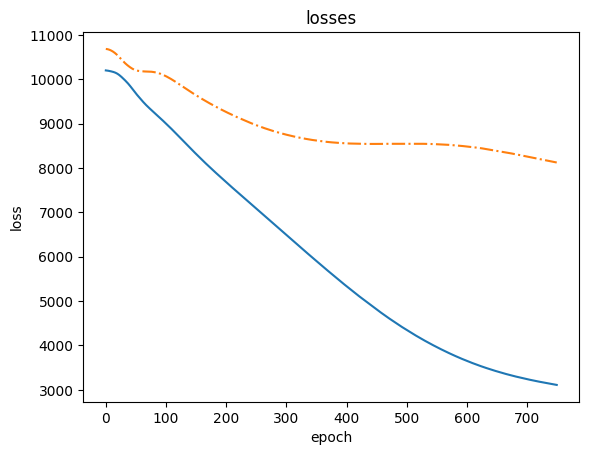

In [91]:
plt.plot(losses)
plt.plot(losses_val, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('losses')
plt.show()




# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])


